In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import random
import re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, precision_recall_curve # Import necessary sklearn metrics
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from torch.nn.utils import spectral_norm  # + spectral normalization for GAN D
from sklearn.metrics import average_precision_score, precision_recall_curve  # + PR-AUC (already imported above)
from torch.nn.attention import sdpa_kernel, SDPBackend  # updated SDPA context manager
import os
from sklearn.preprocessing import StandardScaler
from torch.utils.data import WeightedRandomSampler
from difflib import SequenceMatcher

# Set device
USE_CUDA = True
device = torch.device("cuda" if (USE_CUDA and torch.cuda.is_available()) else "cpu")
torch.backends.cudnn.benchmark = True
print(f"Using device: {device}")

# Mount Google Drive for Colab
# from google.colab import drive
# drive.mount('/content/drive')
try:
    from google.colab import drive as _colab_drive
    IN_COLAB = True
    _colab_drive.mount('/content/drive')
except Exception:
    IN_COLAB = False

# Global plotting theme (single source of truth)
COLOR_PALETTE = ["#cc0000", "#990000", "#000000", "#550000"]
FACE_COLOR = "#f6f5f5"

# + output helpers (Colab or local/Windows)
def get_output_dir():
    if IN_COLAB and os.path.isdir('/content/drive/MyDrive'):
        out = '/content/drive/MyDrive'
    else:
        out = os.getenv('OUTPUT_DIR', os.path.join(os.getcwd(), 'outputs'))
    os.makedirs(out, exist_ok=True)
    return out

def save_fig(filename, dpi=150):
    path = os.path.join(get_output_dir(), filename)
    plt.savefig(path, dpi=dpi)
    return path

# Key changes for stability:
SEED = 42
AMP_ENABLED = True
EMA_DECAY = 0.999
N_CRITIC = 4  # Keep at 5 for WGAN-GP
G_LR = 1e-4   # Increase generator learning rate
D_LR = 1e-4   # Decrease discriminator learning rate (2:1 ratio)
G_BETAS = (0.5, 0.9)  # WGAN-GP standard
D_BETAS = (0.5, 0.9)  # WGAN-GP standard
D_MODEL = 256
NHEAD = 8
NUM_LAYERS = 4
DROPOUT = 0.1
LAMBDA_GP = 10.0  # Standard for WGAN-GP

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(SEED)

sns.set_theme(style="white")
sns.set_palette(COLOR_PALETTE)
plt.rcParams["axes.facecolor"] = FACE_COLOR
plt.rcParams["figure.facecolor"] = FACE_COLOR

# Distinct, explicit styles for GAN curves
GEN_COLOR = COLOR_PALETTE[0]
DISC_COLOR = COLOR_PALETTE[1]
GEN_LS = "-"
DISC_LS = "--"

def style_axes(ax):
    """Apply consistent axis styling."""
    ax.grid(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(False)
    ax.set_facecolor(FACE_COLOR)


class DirectSequenceEncoder(nn.Module):
    """
    Direct amino acid encoder using nn.Embedding over indexed tokens (PAD, UNK, 20 AAs),
    with packed LSTM and masked attention. Provides a fast one-hot helper for GAN.

    Args:
        latent_dim: Output latent feature dimension per sequence.
        hidden_dim: Hidden size per LSTM direction.
        num_layers: Number of LSTM layers.
        dropout: Dropout applied inside LSTM stack and MLP head.

    Notes:
        Vocabulary indices: PAD=0, UNK=1, AAs=2..21 (A..Y without B/J/O/U/X/Z).
        All tensors are moved to the current device.
    """
    def __init__(self, latent_dim=64, hidden_dim=256, num_layers=2, dropout=0.2):
        super().__init__()
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim

        # Alphabet and vocabulary (PAD=0, UNK=1, AAs start at 2)
        self.amino_acids = "ACDEFGHIKLMNPQRSTVWY"  # 20
        self.pad_idx = 0
        self.unk_idx = 1
        self.aa_to_idx = {aa: i + 2 for i, aa in enumerate(self.amino_acids)}
        # Store the index for 'M' (Methionine)
        self.m_idx = self.aa_to_idx.get('M', -1)
        if self.m_idx == -1:
            raise ValueError("Amino acid 'M' not found in the defined alphabet.")

        self.num_amino_acids = len(self.amino_acids)       # 20 classes for targets
        self.vocab_size = self.num_amino_acids + 2         # PAD + UNK + 20 AAs

        # Learned embedding for indexed tokens
        self.aa_embedding = nn.Embedding(self.vocab_size, 128, padding_idx=self.pad_idx)

        # Bidirectional LSTM for sequence processing
        self.lstm = nn.LSTM(
            128, hidden_dim, num_layers,
            batch_first=True, dropout=dropout if num_layers > 1 else 0,
            bidirectional=True
        )

        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )

        # Encode to latent space
        self.fc_latent = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, latent_dim)
        )

        # Decoder for reconstruction (for autoencoder pretraining) → 20 AA logits
        self.decoder_lstm = nn.LSTM(
            latent_dim, hidden_dim, num_layers,
            batch_first=True, dropout=dropout if num_layers > 1 else 0
        )
        self.fc_decode = nn.Linear(hidden_dim, self.num_amino_acids)

    def sequences_to_indices(self, sequences, max_len=1000):
        """
        Tokenize and pad sequences to fixed length.

        Args:
            sequences: List of raw strings (AAs). Non-letter chars are stripped.
            max_len: Truncation/padding length.

        Returns:
            idx: LongTensor of shape [B, T] with PAD/UNK/AA indices.
            mask: FloatTensor of shape [B, T], 1.0 for non-PAD positions, else 0.0.
            lengths: LongTensor of shape [B] with unpadded lengths.

        Shapes:
            B = batch size, T = max_len.
        """
        batch_size = len(sequences)
        idx = torch.full((batch_size, max_len), self.pad_idx, dtype=torch.long, device=device)
        lengths = []

        for i, seq in enumerate(sequences):
            s = ""
            if isinstance(seq, str):
                s = re.sub('[^A-Za-z]', '', seq).upper()
            tokens = [self.aa_to_idx.get(ch, self.unk_idx) for ch in s[:max_len]]
            if tokens:
                L = len(tokens)
                idx[i, :L] = torch.tensor(tokens, dtype=torch.long, device=device)
                lengths.append(L)
            else:
                lengths.append(0)

        lengths = torch.tensor(lengths, dtype=torch.long, device=device)
        mask = (idx != self.pad_idx).float()
        return idx, mask, lengths

    def sequence_to_onehot(self, sequences, max_len=500):
        """
        Build fast 20-way one-hot from token indices for standard AAs (ignores PAD/UNK).

        Args:
            sequences: List of raw strings (AAs).
            max_len: Truncation/padding length.

        Returns:
            onehot: FloatTensor [B, T, 20] with 1.0 at AA class, else 0.0.
        """
        idx, _, _ = self.sequences_to_indices(sequences, max_len=max_len)  # [B,T]
        b, t = idx.shape
        out = torch.zeros(b, t, self.num_amino_acids, device=device)       # [B,T,20]
        valid = (idx >= 2)  # only standard AAs
        if valid.any():
            cls = (idx - 2).clamp_min(0)                                   # map 2..21 → 0..19
            out.scatter_(2, cls.unsqueeze(-1), valid.unsqueeze(-1).float())
        return out

    # + full-length helper (no truncation; strips non-letters)
    def cleaned_lengths(self, sequences):
        """
        Return full lengths of sequences after cleaning (no max_len truncation).
        """
        lens = []
        for seq in sequences:
            s = re.sub('[^A-Za-z]', '', seq).upper() if isinstance(seq, str) else ""
            lens.append(len(s))
        return torch.tensor(lens, dtype=torch.long, device=device)

    def encode(self, sequences):
        """
        Encode batch of sequences into latent features.

        Args:
            sequences: List[str] of length B.

        Returns:
            latent: FloatTensor [B, latent_dim].

        Notes:
            Uses pack_padded_sequence for efficiency and masked attention to ignore PADs.
        """
        idx, mask, lengths = self.sequences_to_indices(sequences)           # [B,T], [B,T], [B]
        embedded = self.aa_embedding(idx)                                   # [B,T,128]

        # Clamp zero-length samples to length 1 to satisfy pack_padded_sequence
        lengths_clamped = lengths.clamp_min(1)

        # Packed LSTM for efficiency
        packed = nn.utils.rnn.pack_padded_sequence(
            embedded, lengths_clamped.cpu(), batch_first=True, enforce_sorted=False
        )
        packed_out, _ = self.lstm(packed)
        lstm_out, _ = nn.utils.rnn.pad_packed_sequence(
            packed_out, batch_first=True, total_length=idx.size(1)
        )  # [B,T,2H]

        # Masked attention over time (ignore PAD positions)
        attn_scores = self.attention(lstm_out).squeeze(-1)                  # [B,T]
        attn_scores = attn_scores.masked_fill(mask == 0, -1e9)
        attn_weights = F.softmax(attn_scores, dim=1).unsqueeze(-1)          # [B,T,1]
        attended = torch.sum(attn_weights * lstm_out, dim=1)                # [B,2H]

        latent = self.fc_latent(attended)                                   # [B,D]
        return latent

    def decode(self, latent, seq_len=500):
        """
        Decode latent features back to per-position AA logits.

        Args:
            latent: FloatTensor [B, latent_dim].
            seq_len: Target decoded length (T).

        Returns:
            aa_logits: FloatTensor [B, T, 20] (unnormalized).
        """
        batch_size = latent.size(0)
        latent_expanded = latent.unsqueeze(1).repeat(1, seq_len, 1)
        decoded, _ = self.decoder_lstm(latent_expanded)
        aa_logits = self.fc_decode(decoded)                                 # [B,T,20]
        return aa_logits

    def forward(self, sequences, decode=False):
        """
        Forward pass.

        Args:
            sequences: List[str] of length B.
            decode: If True, also return per-position AA logits for autoencoding.

        Returns:
            latent: FloatTensor [B, latent_dim] (always).
            decoded: FloatTensor [B, T, 20] if decode=True.
        """
        latent = self.encode(sequences)
        if decode:
            decoded = self.decode(latent)
            return latent, decoded
        return latent


class ProteinGAN(nn.Module):
    """
    Sequence-aware GAN with Transformer G/D producing per-position AA distributions.
    - G: z -> [B, T, d_model] via linear + learned pos emb + Transformer, head -> 20-way softmax per pos.
    - D: [B, T, 20] -> proj to d_model + pos emb + Transformer, pooled critic score (no sigmoid).
    """
    def __init__(self, latent_dim=64, seq_len=100, hidden_dim=[256, 128], cond_dim=None):
        super().__init__()
        self.latent_dim = latent_dim
        self.seq_len = seq_len
        self.num_amino_acids = 20
        self.d_model = D_MODEL
        self.cond_dim = cond_dim

        # Need DirectSequenceEncoder instance to get 'M' index
        temp_encoder = DirectSequenceEncoder()
        self.m_aa_idx = temp_encoder.amino_acids.find('M') # Get the 0-indexed position in "ACDEFGHIKLMNPQRSTVWY"


        # Generator
        self.z_to_seq = nn.Linear(latent_dim, seq_len * self.d_model)
        self.g_pos = nn.Parameter(torch.zeros(1, seq_len, self.d_model))
        g_layer = nn.TransformerEncoderLayer(
            d_model=self.d_model, nhead=NHEAD, dim_feedforward=self.d_model * 4,
            dropout=DROPOUT, batch_first=True
        )
        self.g_tr = nn.TransformerEncoder(g_layer, num_layers=NUM_LAYERS)
        self.g_head = nn.Linear(self.d_model, self.num_amino_acids)
        # Optional conditioning for G
        if self.cond_dim is not None:
            self.g_cond_fc = nn.Linear(self.cond_dim, self.d_model)

        # Discriminator (critic)
        self.d_proj_in = spectral_norm(nn.Linear(self.num_amino_acids, self.d_model))
        self.d_pos = nn.Parameter(torch.zeros(1, seq_len, self.d_model))
        d_layer = nn.TransformerEncoderLayer(
            d_model=self.d_model, nhead=NHEAD, dim_feedforward=self.d_model * 4,
            dropout=DROPOUT, batch_first=True
        )
        self.d_tr = nn.TransformerEncoder(d_layer, num_layers=NUM_LAYERS)
        self.d_head = spectral_norm(nn.Linear(self.d_model, 1))
        # Optional conditioning for D
        if self.cond_dim is not None:
            self.d_cond_fc = nn.Linear(self.cond_dim, self.d_model)

        # init
        nn.init.normal_(self.g_pos, mean=0.0, std=0.02)
        nn.init.normal_(self.d_pos, mean=0.0, std=0.02)
        for m in [self.z_to_seq, self.g_head, self.d_proj_in, self.d_head]:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight); nn.init.zeros_(m.bias)
        # init cond layers if present
        for m in getattr(self, "g_cond_fc", []), getattr(self, "d_cond_fc", []):
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight); nn.init.zeros_(m.bias)

    def generate(self, batch_size, cond):
      """
      Sample sequences from the generator: [B, T, 20] probabilities.
      Enforces the first amino acid to be 'M' (index 10).
      """
      z = torch.randn(batch_size, self.latent_dim, device=device)
      x = self.z_to_seq(z).view(batch_size, self.seq_len, self.d_model)
      x = x + self.g_pos

      if cond is not None and hasattr(self, "g_cond_fc"):
          c = self.g_cond_fc(cond)
          c_expanded = c.unsqueeze(1).expand(-1, self.seq_len, -1)
          x = x + c_expanded

      x = self.g_tr(x)  # Don't forget this!
      logits = self.g_head(x)  # [B,T,20]

      # === Enforce first position is 'M' (index 10) ===
      # Set all positions to very negative
      logits[:, 0, :] = -100.0
      # Set M (index 10) to positive
      logits[:, 0, 10] = 10.0  # Hardcode index 10 for M

      probs = F.softmax(logits, dim=-1)

      # Debug: Verify first position
      if batch_size > 0:
          first_idx = probs[0, 0, :].argmax().item()
          if first_idx != 10:
              print(f"WARNING: First position is {self.amino_acids[first_idx]} not M!")

      return probs

    def discriminate(self, sequences, cond=None):
        """
        Critic score for real/fake sequences (no sigmoid).
        Args:
            sequences [B, T, 20] one-hot/probabilities.
            cond: Optional [B, cond_dim] conditioning vector.
        Returns: [B,1] critic scores.
        """
        b = sequences.size(0)
        x = self.d_proj_in(sequences) + self.d_pos           # [B,T,d]
        if cond is not None and hasattr(self, "d_cond_fc"):
            c = self.d_cond_fc(cond).unsqueeze(1)             # [B,1,d]
            x = x + c
        x = self.d_tr(x)                                      # [B,T,d]
        x = x.mean(dim=1)                                     # global average pool
        score = self.d_head(x)                                # [B,1]
        return score

# --- EMA helpers for generator ---
def _gen_param_items(gan: ProteinGAN):
    # Track only generator parameters by name
    for name, p in gan.named_parameters():
        if name.startswith("z_to_seq") or name.startswith("g_pos") or name.startswith("g_tr") or name.startswith("g_head") or name.startswith("g_cond_fc"):
            yield name, p

def init_generator_ema(gan: ProteinGAN):
    return {name: p.detach().clone().to(device) for name, p in _gen_param_items(gan)}

def update_generator_ema(ema, gan: ProteinGAN, decay=EMA_DECAY):
    for name, p in _gen_param_items(gan):
        ema[name].mul_(decay).add_(p.detach(), alpha=1.0 - decay)

def load_generator_ema_into_model(gan: ProteinGAN, ema):
    with torch.no_grad():
        for name, p in _gen_param_items(gan):
            p.copy_(ema[name].to(p.device))

class PULearningPPIModel(nn.Module):
    """
    MLP for PPI prediction in a PU-learning setting.

    Args:
        sequence_feature_dim: Dimension of concatenated sequence features (e.g., 4*latent_dim).
        structural_feature_dim: Dimension of structural features (99) in the pretarining datatset.
        hidden_dims: List of hidden layer sizes.

    Input/Output:
        forward(sequence_features [B, S], structural_features [B, D]) -> logits [B, 1]
    """
    def __init__(self, sequence_feature_dim, structural_feature_dim, hidden_dims=[256, 128]):
        super().__init__()

        total_input_dim = sequence_feature_dim + structural_feature_dim

        # Build network layers
        layers = []
        prev_dim = total_input_dim

        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Dropout(0.4)
            ])
            prev_dim = hidden_dim

        # Final layer
        layers.append(nn.Linear(prev_dim, 1))

        self.network = nn.Sequential(*layers)

    def forward(self, sequence_features, structural_features):
        """
        Concatenate inputs and compute interaction logits.

        Args:
            sequence_features: FloatTensor [B, S].
            structural_features: FloatTensor [B, D].

        Returns:
            logits: FloatTensor [B, 1].
        """
        x = torch.cat([sequence_features, structural_features], dim=1)
        return self.network(x)


class PULoss(nn.Module):
    """
    Non-negative PU (nnPU) loss per Kiryo et al., treating unlabeled as a mixture.

    Args:
        prior: Estimated positive prior π_p = P(y=1) in unlabeled data.
        loss_type: 'nnPU' for non-negative correction, otherwise unbiased PU.

    Notes:
        Expects raw logits; applies sigmoid internally.
    """
    def __init__(self, prior=0.05, loss_type='nnPU'):
        super().__init__()
        self.prior = prior  # Estimated fraction of positive samples in unlabeled data
        self.loss_type = loss_type

    def forward(self, outputs, labels):
        """
        Correct nnPU (Kiryo et al.) with BCE-with-logits.
        prior = P(y=1) in unlabeled mixture.
        """
        # flatten
        logits = outputs.view(-1)
        y = labels.view(-1)
        pos_mask = (y == 1)
        unl_mask = (y == 0)

        # risks
        if pos_mask.any():
            # R_p^+ = E_p[ℓ^+(g(x))], R_p^- = E_p[ℓ^-(g(x))]
            pos_logits = logits[pos_mask]
            R_p_pos = F.binary_cross_entropy_with_logits(
                pos_logits, torch.ones_like(pos_logits), reduction='mean'
            )
            R_p_neg = F.binary_cross_entropy_with_logits(
                pos_logits, torch.zeros_like(pos_logits), reduction='mean'
            )
        else:
            R_p_pos = torch.tensor(0.0, device=logits.device)
            R_p_neg = torch.tensor(0.0, device=logits.device)

        if unl_mask.any():
            unl_logits = logits[unl_mask]
            # R_u^- = E_u[ℓ^-(g(x))]
            R_u_neg = F.binary_cross_entropy_with_logits(
                unl_logits, torch.zeros_like(unl_logits), reduction='mean'
            )
        else:
            R_u_neg = torch.tensor(0.0, device=logits.device)

        # unbiased negative risk and nnPU clamp
        neg_risk_unbiased = R_u_neg - self.prior * R_p_neg
        neg_risk = torch.clamp(neg_risk_unbiased, min=0.0)

        # total risk
        loss = self.prior * R_p_pos + neg_risk
        return loss


class ProteinDataset(Dataset):
    """
    Dataset wrapper for PPI pairs with sequences and numeric structural covariates.

    Args:
        df: pandas.DataFrame containing columns SequenceA, SequenceB, optional MSAA/MSAB,
            numeric structural columns, and 'label' (1=positive, 0=unlabeled).
        sequence_encoder: Unused here (kept for API symmetry).
        structural_cols: List of column names for structural features.

    Notes:
        - Structural features are taken from the provided `structural_cols`.
    """
    def __init__(self, df, structural_cols, sequence_encoder=None):
        self.df = df.reset_index(drop=True)
        self.sequence_encoder = sequence_encoder
        self.structural_cols = structural_cols

    def __len__(self):
        """Number of samples."""
        return len(self.df)

    def __getitem__(self, idx):
        """
        Get a single item.

        Args:
            idx: Row index.

        Returns:
            dict with:
                - 'sequences': [seqA, seqB, msaA, msaB] as strings.
                - 'structural_features': FloatTensor of structural features.
                - 'label': FloatTensor scalar (0 or 1).
        """
        row = self.df.iloc[idx]

        # Get sequences, ensure strings and not NaN
        seqA = row['SequenceA'] if ('SequenceA' in self.df.columns and isinstance(row['SequenceA'], str)) else ""
        seqB = row['SequenceB'] if ('SequenceB' in self.df.columns and isinstance(row['SequenceB'], str)) else ""
        msaA = row['MSAA'] if ('MSAA' in self.df.columns and isinstance(row['MSAA'], str)) else ""
        msaB = row['MSAB'] if ('MSAB' in self.df.columns and isinstance(row['MSAB'], str)) else ""

        sequences = [seqA, seqB, msaA, msaB]

        # Get structural features
        if self.structural_cols:
            vals = row[self.structural_cols].values.astype(np.float32, copy=False)
            structural_vec = np.nan_to_num(vals, nan=0.0)
        else:
            structural_vec = np.zeros(0, dtype=np.float32)

        structural_tensor = torch.from_numpy(structural_vec)

        # Get label (1 for positive, 0 for unlabeled/negative)
        label = float(row['label']) if 'label' in self.df.columns else 0

        return {
            'sequences': sequences,
            'structural_features': structural_tensor,
            'labels': torch.tensor(label, dtype=torch.float32) # Fix: Use 'label' key (singular)
        }


def collate_fn(batch):
    """
    Collate a list of dataset items into a batch.

    Args:
        batch: List[dict] from ProteinDataset.__getitem__.

    Returns:
        dict with:
            - 'sequences': list of 4 lists (A, B, MSAA, MSAB), each length B.
            - 'structural_features': FloatTensor [B, num_structural_features].
            - 'labels': FloatTensor [B].
    """
    sequences_batch = [[], [], [], []]  # 4 sequence types

    for item in batch:
        for i, seq in enumerate(item['sequences']):
            sequences_batch[i].append(seq)

    return {
        'sequences': sequences_batch,
        'structural_features': torch.stack([item['structural_features'] for item in batch]),
        'labels': torch.stack([item['labels'] for item in batch]) # Fix: Use 'labels' key
    }


def compute_adaptive_gradient_penalty(discriminator_fn, real_samples, fake_samples, device=device):
    """
    Adaptive gradient penalty that adjusts lambda based on gradient magnitude.
    discriminator_fn: callable(tensor[B,T,20]) -> tensor[B,1]
    """
    b = real_samples.size(0)
    eps = torch.rand(b, 1, 1, device=device)
    interpolates = eps * real_samples + (1 - eps) * fake_samples
    interpolates.requires_grad_(True)

    # Use math attention kernel to ensure backward support
    with sdpa_kernel([SDPBackend.MATH]):
        d_interpolates = discriminator_fn(interpolates)
    grads = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones_like(d_interpolates),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    grads = grads.view(b, -1)
    grad_norm = grads.norm(2, dim=1)

    # Adaptive lambda based on gradient magnitude
    adaptive_lambda = 10.0 * (1.0 + (grad_norm.mean() - 1.0).abs())

    # Calculate the gradient penalty term
    gradient_penalty = torch.mean((grad_norm - 1)**2)


    return adaptive_lambda * gradient_penalty

def train_gan(gan, dataloader, encoder, num_epochs):
    """
    Improved GAN training with better stability measures.
    Uses PUL context: cond = [encode(A)||encode(B)||encode(MSAA)||encode(MSAB)||struct].
    """
    print("\nTraining GAN with improved stability measures...")

    # Separate optimizers with different learning rates
    gen_params = [p for name, p in gan.named_parameters()
                  if any(name.startswith(prefix) for prefix in ["z_to_seq", "g_pos", "g_tr", "g_head", "g_cond_fc"])]
    disc_params = [p for name, p in gan.named_parameters()
                   if any(name.startswith(prefix) for prefix in ["d_proj_in", "d_pos", "d_tr", "d_head", "d_cond_fc"])]

    g_optimizer = optim.Adam(gen_params, lr=G_LR, betas=G_BETAS)
    d_optimizer = optim.Adam(disc_params, lr=D_LR, betas=D_BETAS)

    # Learning rate schedulers for stability
    g_scheduler = optim.lr_scheduler.CosineAnnealingLR(g_optimizer, T_max=num_epochs * len(dataloader))
    d_scheduler = optim.lr_scheduler.CosineAnnealingLR(d_optimizer, T_max=num_epochs * len(dataloader))

    # Use modern AMP API
    scaler = torch.amp.GradScaler('cuda', enabled=(device.type == "cuda" and AMP_ENABLED))

    g_losses, d_losses = [], []
    temp_encoder = DirectSequenceEncoder().to(device)

    # EMA for generator
    ema = init_generator_ema(gan)

    # Add noise decay schedule
    noise_std = 0.1  # Initial noise standard deviation
    noise_decay = 0.95  # Decay factor per epoch


    for epoch in range(num_epochs):
        g_loss_epoch = 0.0
        d_loss_epoch = 0.0
        # + extra diagnostics
        wdist_epoch = 0.0
        gp_epoch = 0.0
        dreal_epoch = 0.0
        dfake_epoch = 0.0
        num_batches = 0
        # + full-length tracking
        full_len_sum = 0.0
        full_len_count = 0
        # Track samples used
        total_positive_samples = 0
        total_negative_samples = 0
        # Update noise level
        current_noise = noise_std * (noise_decay ** epoch)

        for batch_idx, batch in enumerate(tqdm(dataloader, desc=f'GAN Epoch {epoch+1}/{num_epochs}')):
            all_seqA = batch['sequences'][0]
            labels = batch['labels'].cpu().numpy()

            valid_idx = [i for i, s in enumerate(all_seqA)
                      if isinstance(s, str) and len(s) > 0]
            if len(valid_idx) < 2:
                continue

            # Identify positive and negative samples
            positive_idx = [i for i in valid_idx if labels[i] == 1]
            negative_idx = [i for i in valid_idx if labels[i] == 0]

            # unused...GAN is trained on only positive interacting samples
            if len(positive_idx) > 0 and len(negative_idx) > 0:
                # Option: Undersample the majority class to balance
                if len(positive_idx) > len(negative_idx) * 3:
                    # If positives are more than 3x negatives, subsample positives
                    positive_idx = random.sample(positive_idx, len(negative_idx) * 3)
                elif len(negative_idx) > len(positive_idx) * 3:
                    # If negatives are more than 3x positives, subsample negatives
                    negative_idx = random.sample(negative_idx, len(positive_idx) * 3)

            # Use both positive and negative samples
            combined_idx = positive_idx + negative_idx

            # Skip if we don't have enough samples
            if len(combined_idx) < 2:
                continue

            # Track statistics
            total_positive_samples += len(positive_idx)
            total_negative_samples += len(negative_idx)

            # Collect corresponding sequences for all 4 types using the combined indices
            real_seqA = [batch['sequences'][0][i] for i in combined_idx]
            real_seqB = [batch['sequences'][1][i] for i in combined_idx]
            real_msaA = [batch['sequences'][2][i] for i in combined_idx]
            real_msaB = [batch['sequences'][3][i] for i in combined_idx]
            struct = batch['structural_features'][combined_idx].to(device)

            # Build conditioning vector with all sequence encodings + structural features
            with torch.no_grad():
                enc_a = encoder(real_seqA)      # [B, LATENT_DIM]
                enc_b = encoder(real_seqB)      # [B, LATENT_DIM]
                enc_msaA = encoder(real_msaA)   # [B, LATENT_DIM]
                enc_msaB = encoder(real_msaB)   # [B, LATENT_DIM]
            cond = torch.cat([enc_a, enc_b, enc_msaA, enc_msaB, struct], dim=1)  # [B, 4*LATENT_DIM + struct_dim]

            # Build real samples from SequenceA as before
            real_onehot = encoder.sequence_to_onehot(real_seqA, max_len=gan.seq_len)
            cur_bs = real_onehot.size(0)

            # Add noise to real samples (label smoothing)
            if current_noise > 0:
                noise = torch.randn_like(real_onehot) * current_noise
                real_onehot_noisy = real_onehot + noise
                real_onehot_noisy = real_onehot_noisy.clamp(0, 1)
            else:
                real_onehot_noisy = real_onehot

            # + compute full lengths (no truncation)
            full_lens = encoder.cleaned_lengths(real_seqA)
            full_len_sum += full_lens.sum().item()
            full_len_count += full_lens.numel()

            # Train Discriminator
            for _ in range(N_CRITIC):
                d_optimizer.zero_grad(set_to_none=True)

                # Autocast and force math attention kernel for both G and D
                with torch.amp.autocast('cuda', enabled=(device.type == "cuda" and AMP_ENABLED)):
                    with sdpa_kernel([SDPBackend.MATH]):
                        fake = gan.generate(cur_bs, cond=cond).detach()
                        # Add instance noise to discriminator inputs
                        fake_noisy = fake + torch.randn_like(fake) * current_noise * 0.5
                        d_real = gan.discriminate(real_onehot_noisy, cond=cond).mean()
                        d_fake = gan.discriminate(fake_noisy, cond=cond).mean()
                        # Wasserstein loss (raw, without GP)
                        d_loss = d_fake - d_real

                # Gradient penalty (computed in fp32; internal call also uses math attention)
                gp = compute_adaptive_gradient_penalty(lambda x: gan.discriminate(x, cond=cond),
                                                       real_onehot, fake, device=device)

                # Total discriminator loss
                d_total = d_loss + gp

                scaler.scale(d_total).backward()

                # Gradient clipping for discriminator
                torch.nn.utils.clip_grad_norm_(disc_params, max_norm=1.0)

                scaler.step(d_optimizer)
                scaler.update()

            # Train Generator
            g_optimizer.zero_grad(set_to_none=True)
            with torch.amp.autocast('cuda', enabled=(device.type == "cuda" and AMP_ENABLED)):
                with sdpa_kernel([SDPBackend.MATH]):
                    fake = gan.generate(cur_bs, cond=cond)
                    g_loss = -gan.discriminate(fake, cond=cond).mean()

            scaler.scale(g_loss).backward()

            # Gradient clipping for generator
            torch.nn.utils.clip_grad_norm_(gen_params, max_norm=1.0)

            scaler.step(g_optimizer)
            scaler.update()

            # Update EMA
            update_generator_ema(ema, gan, decay=EMA_DECAY)

            # Update schedulers
            g_scheduler.step()
            d_scheduler.step()

            # After updates, accumulate diagnostics from the last critic step
            g_loss_epoch += g_loss.item()
            d_loss_epoch += d_total.item()
            # + diagnostics (detach to CPU-safe scalars)
            wdist_epoch += (d_real - d_fake).detach().item()
            gp_epoch += gp.detach().item()
            dreal_epoch += d_real.detach().item()
            dfake_epoch += d_fake.detach().item()
            num_batches += 1

            # Early stopping check every 10 batches
            if batch_idx % 10 == 0 and batch_idx > 0:
                if abs(d_loss.item()) < 0.01:  # Discriminator too strong
                    print(f"Warning: Discriminator loss too low ({d_loss.item():.4f}), potential mode collapse")
                if g_loss.item() > 10:  # Generator failing
                    print(f"Warning: Generator loss too high ({g_loss.item():.4f})")

        if num_batches > 0:
            avg_g_loss = g_loss_epoch / num_batches
            avg_d_loss = d_loss_epoch / num_batches
            # + averaged diagnostics
            avg_wdist = wdist_epoch / num_batches
            avg_gp = gp_epoch / num_batches
            avg_dreal = dreal_epoch / num_batches
            avg_dfake = dfake_epoch / num_batches
            g_losses.append(avg_g_loss)
            d_losses.append(avg_d_loss)
            # + report average full sequence length seen this epoch
            avg_full_len = (full_len_sum / max(1, full_len_count))
            print(f'Epoch {epoch+1}: G_Loss: {avg_g_loss:.4f}, D_Loss(total): {avg_d_loss:.4f}, Noise: {current_noise:.4f} | AvgSeqLen(full)={avg_full_len:.1f}')
            print(f'  Positive samples: {total_positive_samples} | Negative samples: {total_negative_samples} | Batches: {num_batches}')
            # + clearer critic report (Wasserstein estimate excludes GP)
            print(f'  Critic: W-dist≈{avg_wdist:.4f} | D_real={avg_dreal:.4f} | D_fake={avg_dfake:.4f} | GP={avg_gp:.4f}')



    # Attach EMA to model
    gan._ema = ema
    return g_losses, d_losses

def train_model(model, encoder, dataloader, val_loader, num_epochs):
    """
    Train the PPI model with PU loss, jointly optimizing the encoder.

    Args:
        model: PULearningPPIModel.
        encoder: DirectSequenceEncoder.
        dataloader: Training DataLoader.
        val_loader: Validation DataLoader.
        num_epochs: Number of epochs.

    Returns:
        (train_losses, val_losses): Lists of average losses per epoch.
    """
    print("\nTraining PPI model with PU learning...")

    optimizer = optim.Adam(
        list(model.parameters()) + list(encoder.parameters()),
        lr=0.00003,
        weight_decay=1e-5
    )

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)

    # PU learning loss: prior is expected fraction of positives in unlabeled mixture
    pu_loss = PULoss(prior=0.05)

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        # Training
        model.train()
        encoder.train()
        total_loss = 0

        for batch in tqdm(dataloader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            optimizer.zero_grad()

            # Encode sequences
            encoded_seqs = []
            for seq_type in batch['sequences']:
                encoded = encoder(seq_type)
                encoded_seqs.append(encoded)

            # Concatenate all sequence encodings
            seq_features = torch.cat(encoded_seqs, dim=1)

            # Get predictions
            outputs = model(seq_features, batch['structural_features'].to(device))

            # Calculate PU loss (keep last dim, even for batch size 1)
            loss = pu_loss(outputs.squeeze(-1), batch['labels'].to(device, non_blocking=True))

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            torch.nn.utils.clip_grad_norm_(encoder.parameters(), 1.0)
            optimizer.step()

            total_loss += loss.item()

        avg_train_loss = total_loss / len(dataloader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        encoder.eval()
        val_loss = 0

        with torch.no_grad():
            for batch in val_loader:
                encoded_seqs = []
                for seq_type in batch['sequences']:
                    encoded = encoder(seq_type)
                    encoded_seqs.append(encoded)

                seq_features = torch.cat(encoded_seqs, dim=1)
                outputs = model(seq_features, batch['structural_features'].to(device, non_blocking=True))
                loss = pu_loss(outputs.squeeze(-1), batch['labels'].to(device, non_blocking=True))
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        scheduler.step(avg_val_loss)

        print(f'Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

    return train_losses, val_losses


def evaluate_model(model, encoder, dataloader, dataset_name="Test"):
    """
    Evaluate model performance with ranking and threshold metrics using sklearn.

    Args:
        model: PULearningPPIModel.
        encoder: DirectSequenceEncoder.
        dataloader: DataLoader for evaluation split.
        dataset_name: Label for logs/plots.

    Returns:
        dict with AUC, AUPR, precision, recall, f1, accuracy, confusion_matrix,
        predictions, labels; or None if only one class present.
    """
    print(f"\n{'='*60}")
    print(f"Evaluating on {dataset_name} Dataset")
    print(f"{'='*60}")

    model.eval()
    encoder.eval()

    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc=f'Evaluating {dataset_name}'):
            encoded_seqs = []
            for seq_type in batch['sequences']:
                encoded = encoder(seq_type)
                encoded_seqs.append(encoded)

            seq_features = torch.cat(encoded_seqs, dim=1)
            outputs = model(seq_features, batch['structural_features'].to(device, non_blocking=True))
            probs = torch.sigmoid(outputs.squeeze(-1))

            all_labels.extend(batch['labels'].cpu().numpy())
            all_predictions.extend(probs.cpu().numpy())

    all_labels = np.array(all_labels)
    all_predictions = np.array(all_predictions)

    # Require both classes present to compute ROC AUC and other metrics
    if len(np.unique(all_labels)) < 2:
        print("Only one class present in labels; skipping ROC-based metrics.")
        return None

    # AUC-ROC
    auc = roc_auc_score(all_labels, all_predictions)
    print(f"AUC-ROC: {auc:.4f}")

    # PR-AUC
    aupr = average_precision_score(all_labels, all_predictions)
    print(f"AUPR: {aupr:.4f}")

    # Calculate metrics at a fixed threshold (0.92)
    fixed_threshold = 0.92
    binary_pred_fixed = (all_predictions > fixed_threshold).astype(int)

    precision_fixed = precision_score(all_labels, binary_pred_fixed)
    recall_fixed = recall_score(all_labels, binary_pred_fixed)
    f1_fixed = f1_score(all_labels, binary_pred_fixed)
    accuracy_fixed = accuracy_score(all_labels, binary_pred_fixed)
    cm_fixed = confusion_matrix(all_labels, binary_pred_fixed)


    print(f"\nMetrics at fixed threshold ({fixed_threshold:.2f}):")
    print(f"Precision: {precision_fixed:.4f}")
    print(f"Recall:    {recall_fixed:.4f}")
    print(f"F1 Score:  {f1_fixed:.4f}")
    print(f"Accuracy:  {accuracy_fixed:.4f}")
    print(f"Confusion Matrix:\n{cm_fixed}")


    # Plot distribution
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.hist(all_predictions[all_labels==1], bins=30, alpha=0.5, label='Positive', color=COLOR_PALETTE[0])
    plt.hist(all_predictions[all_labels==0], bins=30, alpha=0.5, label='Unlabeled', color=COLOR_PALETTE[1])
    plt.xlabel('Prediction Score')
    plt.ylabel('Count')
    plt.legend()
    plt.title(f'{dataset_name} Score Distribution')

    plt.subplot(1, 2, 2)
    fpr, tpr, _ = roc_curve(all_labels, all_predictions)
    plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}', color=COLOR_PALETTE[2])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{dataset_name} ROC Curve')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # PR curve
    precision_arr, recall_arr, _ = precision_recall_curve(all_labels, all_predictions)
    plt.figure(figsize=(5,4))
    plt.plot(recall_arr, precision_arr, color=COLOR_PALETTE[0], label=f'AUPR = {aupr:.3f}')
    plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title(f'{dataset_name} Precision-Recall')
    plt.legend(); plt.tight_layout(); plt.show()

    return {
        'auc': auc,
        'aupr': aupr,
        'precision': precision_fixed,
        'recall': recall_fixed,
        'f1': f1_fixed,
        'accuracy': accuracy_fixed,
        'confusion_matrix': cm_fixed,
        'predictions': all_predictions,
        'labels': all_labels,
    }

Using device: cuda
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
from typing import Dict, Any, Optional

import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler



def load_and_prepare_data(
    data_path: str = "/content/drive/MyDrive/pretraining.csv",
    batch_size: int = 128,
    unlabeled_weight: float = 5.0,   # weight for label==0 in the WeightedRandomSampler
    num_workers: int = 0,
    persistent_workers: bool = False,
    device: Optional[torch.device] = None,
) -> Dict[str, Any]:
    """
    Load data, split into train/val/test, scale features (fit on train only),
    and build DataLoaders. Also returns a positives-only train DataLoader for GANs.

    Returns:
      {
        'train_loader': DataLoader,
        'val_loader': DataLoader,
        'test_loader': DataLoader,
        'pos_train_loader': DataLoader,  # positives-only (label==1)
        'train_df': DataFrame,
        'val_df': DataFrame,
        'test_df': DataFrame,
        'structural_feature_names': List[str],
        'scaler': StandardScaler
      }
    """
    print("="*60)
    print("Loading and Preparing Data")
    print("="*60)

    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    pin_mem = (device.type == "cuda")

    # 1) Load
    print("\nLoading dataset...")
    df = pd.read_csv(data_path)
    print(f"Dataset shape: {df.shape}")

    # 2) Filter sequences
    df_filtered = df.dropna(subset=["SequenceA", "SequenceB"], how="all").copy()
    print(f"Filtered dataset shape: {df_filtered.shape}")

    # 3) Label distribution
    print("\nLabel distribution (1=Positive, 0=Unlabeled/Negative):")
    print(df_filtered["label"].value_counts())

    # 4) Structural features: keep stable order and intersect with existing columns
    candidate_features = ["Volume","CZ","CA","O","OD1","OG","N","NZ","DU","CZ40","CZ40.50","CZ50.60",
                          "CZ60.70","CZ70.80","CZ80.90","CZ90.100","CZ100.110","CZ110.120","CZ120",
                          "CA40","CA40.50","CA50.60","CA60.70","CA70.80","CA80.90","CA90.100","CA100.110",
                          "CA110.120","CA120","O40","O40.50","O50.60","O60.70","O70.80","O80.90","O90.100",
                          "O100.110","O110.120","O120","OD140","OD140.50","OD150.60","OD160.70","OD170.80",
                          "OD180.90","OD190.100","OD1100.110","OD1110.120","OD1120","OG40","OG40.50",
                          "OG50.60","OG60.70","OG70.80","OG80.90","OG90.100","OG100.110","OG110.120",
                          "OG120","N40","N40.50","N50.60","N60.70","N70.80","N80.90","N90.100","N100.110",
                          "N110.120","N120","NZ40","NZ40.50","NZ50.60","NZ60.70","NZ70.80","NZ80.90",
                          "NZ90.100","NZ100.110","NZ110.120","NZ120","DU40","DU40.50","DU50.60","DU60.70",
                          "DU70.80","DU80.90","DU90.100","DU100.110","DU110.120","DU120","T40","T40.50",
                          "T50.60","T60.70","T70.80","T80.90","T90.100","T100.110","T110.120","InertialShapeFactor"]

    structural_feature_names = [c for c in candidate_features if c in df_filtered.columns]
    if not structural_feature_names:
        raise ValueError("No structural feature columns found in the input CSV.")

    # 5) Split (stratified)
    train_df, temp_df = train_test_split(
        df_filtered, test_size=0.3, random_state=42, stratify=df_filtered["label"]
    )
    val_df, test_df = train_test_split(
        temp_df, test_size=0.5, random_state=42, stratify=temp_df["label"]
    )

    print("\nDataset splits:")
    print(f"Train: {train_df.shape[0]} samples")
    print(f"Validation: {val_df.shape[0]} samples")
    print(f"Test: {test_df.shape[0]} samples")

    # 6) Fit scaler on train only (no leakage), then transform val/test
    scaler = StandardScaler()
    train_df.loc[:, structural_feature_names] = scaler.fit_transform(train_df[structural_feature_names])
    val_df.loc[:, structural_feature_names] = scaler.transform(val_df[structural_feature_names])
    test_df.loc[:, structural_feature_names] = scaler.transform(test_df[structural_feature_names])

    # 7) Datasets
    train_dataset = ProteinDataset(train_df, structural_feature_names)
    val_dataset = ProteinDataset(val_df, structural_feature_names)
    test_dataset = ProteinDataset(test_df, structural_feature_names)

    # 8) Train sampler (PU setting: upweight unlabeled to appear more often in batches)
    if "label" not in train_df.columns:
        raise ValueError("Expected 'label' column in the dataset.")

    labels_np = train_df["label"].to_numpy()
    weights = np.where(labels_np == 1, 1.0, float(unlabeled_weight))
    sampler = WeightedRandomSampler(weights=weights, num_samples=len(weights), replacement=True)

    # 9) DataLoaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        pin_memory=pin_mem,
        num_workers=num_workers,
        persistent_workers=persistent_workers,
        sampler=sampler,
        drop_last=False,
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        pin_memory=pin_mem,
        num_workers=num_workers,
        persistent_workers=persistent_workers,
        shuffle=False,
        drop_last=False,
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        pin_memory=pin_mem,
        num_workers=num_workers,
        persistent_workers=persistent_workers,
        shuffle=False,
        drop_last=False,
    )

    # 10) Positives-only train DataLoader (for GAN)
    pos_train_df = train_df[train_df["label"] == 1].copy()
    pos_train_dataset = ProteinDataset(pos_train_df, structural_feature_names)
    pos_train_loader = DataLoader(
        pos_train_dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        pin_memory=pin_mem,
        num_workers=num_workers,
        persistent_workers=persistent_workers,
        shuffle=True,   # shuffle for GAN
        drop_last=True  # helps GAN stability
    )

    print(f"Dataloader batches - Train: {len(train_loader)}, Val: {len(val_loader)}, Test: {len(test_loader)}")
    print(f"Positives-only train batches (GAN): {len(pos_train_loader)}")

    return {
        "train_loader": train_loader,
        "val_loader": val_loader,
        "test_loader": test_loader,
        "pos_train_loader": pos_train_loader,  
        "train_df": train_df,
        "val_df": val_df,
        "test_df": test_df,
        "structural_feature_names": structural_feature_names,
        "scaler": scaler,
    }

In [10]:
def run_autoencoder_pu_pipeline():
    """Run the autoencoder pretraining and PU learning pipeline."""
    print("="*60)
    print("AUTOENCODER + PU LEARNING PIPELINE")
    print("="*60)

    # Load data
    data_dict = load_and_prepare_data()
    train_loader = data_dict['train_loader']
    val_loader = data_dict['val_loader']
    test_loader = data_dict['test_loader']
    structural_feature_names = data_dict['structural_feature_names']

    # Initialize encoder
    print("\n" + "="*60)
    print("Initializing Encoder")
    print("="*60)

    LATENT_DIM = 64
    encoder = DirectSequenceEncoder(
        latent_dim=LATENT_DIM,
        hidden_dim=256,
        num_layers=2,
        dropout=0.2
    ).to(device)

    print(f"Encoder parameters: {sum(p.numel() for p in encoder.parameters()):,}")

    # Initialize PPI model
    sequence_feature_dim = LATENT_DIM * 4  # 4 sequence types
    structural_feature_dim = len(structural_feature_names)

    ppi_model = PULearningPPIModel(
        sequence_feature_dim=sequence_feature_dim,
        structural_feature_dim=structural_feature_dim,
        hidden_dims=[256]
    ).to(device)

    print(f"PPI Model parameters: {sum(p.numel() for p in ppi_model.parameters()):,}")

    # Phase 1: Pre-train encoder with autoencoding
    print("\n" + "="*60)
    print("Phase 1: Pre-training Encoder with Autoencoding")
    print("="*60)

    ae_optimizer = optim.Adam(encoder.parameters(), lr=0.001)
    ae_train_losses = []  # Store autoencoder training losses

    for epoch in range(80):
        encoder.train()
        total_loss = 0
        for batch in tqdm(train_loader, desc=f'Autoencoder Epoch {epoch+1}/80'):
            ae_optimizer.zero_grad()

            # Use first sequence type for autoencoding
            sequences = batch['sequences'][0]

            # Encode and decode
            latent, decoded = encoder(sequences, decode=True)

            # Reconstruction loss
            target_onehot = encoder.sequence_to_onehot(sequences)
            loss = F.mse_loss(decoded, target_onehot)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(encoder.parameters(), 1.0)
            ae_optimizer.step()

            total_loss += loss.item()

        avg_train_loss = total_loss/len(train_loader)
        ae_train_losses.append(avg_train_loss)  # Store average loss per epoch
        print(f'Epoch {epoch+1}: Reconstruction Loss: {avg_train_loss:.4f}')

    print("Encoder pre-training complete!")

    # Phase 1 plots: Autoencoder training curves
    plt.figure(figsize=(10, 5))
    ax = sns.lineplot(x=range(1, len(ae_train_losses)+1), y=ae_train_losses, label='AE Train Loss', color=COLOR_PALETTE[0])
    ax.set_xlabel('Epoch'); ax.set_ylabel('Loss'); ax.set_title('Autoencoder Pre-training Loss')
    ax.legend()
    style_axes(ax)
    plt.tight_layout()
    save_fig('ae_training_curves.png')
    plt.show()


    # Phase 2: Train PPI model with PU learning
    print("\n" + "="*60)
    print("Phase 2: Training PPI Model with PU Learning")
    print("="*60)

    train_losses, val_losses = train_model(
        ppi_model, encoder, train_loader, val_loader, num_epochs=80
    )

    # Phase 2 plots: PPI training curves
    plt.figure(figsize=(10, 5))
    ax = sns.lineplot(x=range(1, len(train_losses)+1), y=train_losses, label='Train Loss', color=COLOR_PALETTE[0])
    ax = sns.lineplot(x=range(1, len(val_losses)+1), y=val_losses, label='Validation Loss', color=COLOR_PALETTE[1])
    ax.set_xlabel('Epoch'); ax.set_ylabel('Loss'); ax.set_title('PPI Model Training with PU Learning')
    ax.legend()
    style_axes(ax)
    plt.tight_layout()
    save_fig('pu_training_curves.png')
    plt.show()

    # Evaluate models
    print("\n" + "="*60)
    print("Evaluation")
    print("="*60)

    # Evaluate on training data
    print("\nEvaluating on TRAINING data...")
    train_results = evaluate_model(ppi_model, encoder, train_loader, "Training")

    # Evaluate on test data
    print("\nEvaluating on TEST data...")
    test_results = evaluate_model(ppi_model, encoder, test_loader, "Test")

    # Evaluate on Alzheimer's proteins
    alzheimer_results = evaluate_alzheimer_proteins(ppi_model, encoder, structural_feature_names)

    # Save models
    print("\n" + "="*60)
    print("Saving Models")
    print("="*60)

    torch.save({
        'encoder': encoder.state_dict(),
        'ppi_model': ppi_model.state_dict(),
        'train_metrics': train_results,
        'test_metrics': test_results,
        'alzheimer_results': alzheimer_results,
        'ae_train_losses': ae_train_losses, # Save autoencoder losses
        'train_losses': train_losses,
        'val_losses': val_losses
    }, os.path.join(get_output_dir(), 'autoencoder_pu_complete.pth'))

    print("Autoencoder + PU models saved successfully!")

    return {
        'encoder': encoder,
        'ppi_model': ppi_model,
        'results': {
            'train': train_results,
            'test': test_results,
            'alzheimer': alzheimer_results,
            'ae_train_losses': ae_train_losses, # Return autoencoder losses
            'train_losses': train_losses,
            'val_losses': val_losses
        }
    }

In [11]:
def run_gan_pipeline(pretrained_encoder=None):
    """Run the GAN training pipeline."""
    print("="*60)
    print("GAN TRAINING PIPELINE")
    print("="*60)

    # Load data
    data_dict = load_and_prepare_data()
    train_loader = data_dict['pos_train_loader']
    structural_feature_names = data_dict['structural_feature_names']

    # Initialize or load encoder
    LATENT_DIM = 64
    ppi_model_path = os.path.join(get_output_dir(), 'autoencoder_pu_complete.pth')
    ppi_checkpoint = torch.load(ppi_model_path, map_location=device, weights_only=False)
    LATENT_DIM = 64

    ppi_state = ppi_checkpoint['ppi_model']
    first_layer_weight = ppi_state['network.0.weight']
    total_input_dim = first_layer_weight.shape[1]

    encoder = DirectSequenceEncoder(
    latent_dim=LATENT_DIM,
    hidden_dim=256,
    num_layers=2,
    dropout=0.2
    ).to(device)

    print(f"Encoder parameters: {sum(p.numel() for p in encoder.parameters()):,}")

    # Initialize GAN
    print("\n" + "="*60)
    print("Initializing GAN")
    print("="*60)

    structural_feature_dim = len(structural_feature_names)
    gan = ProteinGAN(
        latent_dim=64,
        seq_len=100,
        hidden_dim=[256, 128],
        cond_dim=LATENT_DIM * 4 + structural_feature_dim
    ).to(device)

    # Calculate GAN parameter counts
    gen_params_count = sum(
        p.numel() for n, p in gan.named_parameters()
        if n.startswith(("z_to_seq", "g_pos", "g_tr", "g_head", "g_cond_fc"))
    )
    disc_params_count = sum(
        p.numel() for n, p in gan.named_parameters()
        if n.startswith(("d_proj_in", "d_pos", "d_tr", "d_head", "d_cond_fc"))
    )

    print(f"GAN Generator parameters: {gen_params_count:,}")
    print(f"GAN Discriminator parameters: {disc_params_count:,}")

    # Train GAN
    print("\n" + "="*60)
    print("Training GAN for Sequence Generation")
    print("="*60)


    g_losses, d_losses = train_gan(gan, train_loader, encoder, num_epochs=80)

    # GAN training curves
    fig, ax = plt.subplots(figsize=(10, 5))
    epochs = range(1, len(g_losses) + 1)
    ax.plot(epochs, g_losses, label='Generator Loss', color=GEN_COLOR, linestyle=GEN_LS, linewidth=2.0)
    ax.plot(epochs, d_losses, label='Discriminator Loss', color=DISC_COLOR, linestyle=DISC_LS, linewidth=2.0)
    ax.set_xlabel('Epoch'); ax.set_ylabel('Loss'); ax.set_title('GAN Training Progress')
    ax.legend()
    style_axes(ax)
    plt.tight_layout()
    save_fig('gan_training_curves.png')
    plt.show()

    # Generate novel sequences
    print("\n" + "="*60)
    print("Generating Novel Protein Sequences with GAN")
    print("="*60)

    # Generate sample sequences using the GAN
    with torch.no_grad():
        gan.eval()
        sample_probs = gan.generate(10, cond=None)  # Generate 10 sample sequences
        amino_acids = "ACDEFGHIKLMNPQRSTVWY"
        novel_sequences = []
        for i in range(sample_probs.size(0)):
            # Convert probabilities to sequence using argmax sampling
            indices = torch.argmax(sample_probs[i], dim=-1)
            seq = "".join(amino_acids[idx] for idx in indices if idx < len(amino_acids))
            novel_sequences.append(seq[:200])  # Truncate for display

    print(f"Generated {len(novel_sequences)} novel sequences (first 200 chars shown):")
    for i, seq in enumerate(novel_sequences[:3]):  # Show first 3
        print(f"  Seq {i+1}: {seq}...")

    # Save GAN models
    print("\n" + "="*60)
    print("Saving GAN Models")
    print("="*60)

    torch.save({
        'encoder': encoder.state_dict(),
        'gan': gan.state_dict(),
        'gan_ema': getattr(gan, "_ema", None),
        'g_losses': g_losses,
        'd_losses': d_losses,
        'novel_sequences': novel_sequences
    }, os.path.join(get_output_dir(), 'gan_complete.pth'))

    print("GAN models saved successfully!")

    return {
        'encoder': encoder,
        'gan': gan,
        'results': {
            'g_losses': g_losses,
            'd_losses': d_losses,
            'novel_sequences': novel_sequences
        }
    }


In [ ]:
def load_alzheimer_dataset():
    """Load and examine the Alzheimer interactome dataset"""
    data_path = '/content/drive/MyDrive/Alzheimer.csv'

    try:
        df = pd.read_csv(data_path)
        display(df.head())


        # Clean the dataset
        df_clean = df.dropna(subset=['SequenceA', 'SequenceB']).copy()

        return df_clean

    except FileNotFoundError:
        print(f"Error: Could not find {data_path}")
        print("Please ensure Alzheimer.csv is in  Google Drive root folder")
        return None

def evaluate_alzheimer_proteins(model, encoder, structural_feature_names, sample_size=None, batch_size=32, threshold=0.5):
    """
    Evaluate protein-protein interactions from the Alzheimer dataset with improved efficiency and functionality.

    Args:
        model: PULearningPPIModel - Trained PPI prediction model
        encoder: DirectSequenceEncoder - Trained sequence encoder
        structural_feature_names: List[str] - Names of structural feature columns
        sample_size: Optional[int] - Number of pairs to evaluate (None = all pairs)
        batch_size: int - Batch size for processing (default: 32)
        threshold: float - Probability threshold for binary classification (default: 0.5)

    Returns:
        Dict containing:
            - results: List[dict] with pair predictions
            - metrics: Dict with evaluation metrics
            - visualizations: Generated plots
    """
    print("\n" + "="*60)
    print("EVALUATING ALZHEIMER PROTEIN-PROTEIN INTERACTIONS")
    print("="*60)

    # Load dataset with error handling
    try:
        df = load_alzheimer_dataset()
        if df is None or df.empty:
            print("Error: No Alzheimer dataset loaded")
            return None
    except Exception as e:
        print(f"Error loading Alzheimer dataset: {e}")
        return None

    print(f"Loaded dataset with {len(df)} protein pairs")

    # Sample if requested
    if sample_size and sample_size < len(df):
        df = df.sample(n=sample_size, random_state=42).reset_index(drop=True)
        print(f"Sampling {sample_size} pairs for evaluation")

    # Set models to evaluation mode
    model.eval()
    encoder.eval()

    results = []
    processing_errors = 0

    # Process in batches for memory efficiency
    print(f"Processing {len(df)} pairs in batches of {batch_size}...")

    with torch.no_grad():
        for batch_start in tqdm(range(0, len(df), batch_size), desc="Processing batches"):
            batch_end = min(batch_start + batch_size, len(df))
            batch_df = df.iloc[batch_start:batch_end]

            # Prepare batch data
            batch_sequences = [[], [], [], []]  # 4 sequence types
            batch_pairs = []
            batch_valid_indices = []

            for idx, (_, row) in enumerate(batch_df.iterrows()):
                # Validate sequences
                if pd.isna(row['SequenceA']) or pd.isna(row['SequenceB']):
                    processing_errors += 1
                    continue

                seqA = str(row['SequenceA']).strip()
                seqB = str(row['SequenceB']).strip()

                if len(seqA) == 0 or len(seqB) == 0:
                    processing_errors += 1
                    continue

                # Add to batch
                batch_sequences[0].append(seqA)    # SequenceA
                batch_sequences[1].append(seqB)    # SequenceB
                batch_sequences[2].append("")      # Empty MSAA
                batch_sequences[3].append("")      # Empty MSAB

                batch_pairs.append({
                    'UniProt_A': row['UniProt_A'],
                    'UniProt_B': row['UniProt_B'],
                    'seq_len_A': len(seqA),
                    'seq_len_B': len(seqB)
                })
                batch_valid_indices.append(idx)

            if not batch_sequences[0]:  # No valid sequences in batch
                continue

            try:
                # Encode sequences in batch
                encoded_seqs = []
                for seq_type in batch_sequences:
                    encoded = encoder(seq_type)
                    encoded_seqs.append(encoded)

                seq_features = torch.cat(encoded_seqs, dim=1)

                # Create structural features (zeros for dummy features)
                batch_size_actual = len(batch_sequences[0])
                struct_features = torch.zeros(batch_size_actual, len(structural_feature_names), device=device)

                # Predict interactions
                outputs = model(seq_features, struct_features)
                probabilities = torch.sigmoid(outputs.squeeze(-1))

                # Store results
                for i, (pair_info, prob) in enumerate(zip(batch_pairs, probabilities)):
                    pair_name = f"{pair_info['UniProt_A']}-{pair_info['UniProt_B']}"

                    results.append({
                        'pair': pair_name,
                        'UniProt_A': pair_info['UniProt_A'],
                        'UniProt_B': pair_info['UniProt_B'],
                        'probability': prob.item(),
                        'predicted': prob.item() > threshold,
                        'seq_len_A': pair_info['seq_len_A'],
                        'seq_len_B': pair_info['seq_len_B'],
                        'confidence': 'high' if abs(prob.item() - 0.5) > 0.3 else 'low'
                    })

            except Exception as e:
                print(f"Error processing batch {batch_start}-{batch_end}: {e}")
                processing_errors += len(batch_sequences[0])
                continue

    print(f"Processing complete. Errors encountered: {processing_errors}")

    if not results:
        print("No valid results generated")
        return None

    # Sort by probability (highest first)
    results.sort(key=lambda x: x['probability'], reverse=True)

    # Generate analysis and metrics
    analysis = _analyze_alzheimer_results(results, threshold)

    # Create visualizations
    visualizations = _create_alzheimer_visualizations(results, threshold)

    return {
        'results': results,
        'metrics': analysis,
        'visualizations': visualizations,
        'processing_errors': processing_errors,
        'total_processed': len(results)
    }


def _analyze_alzheimer_results(results, threshold=0.92):
    """Analyze results and compute detailed metrics."""
    positive_predictions = [r for r in results if r['predicted']]
    negative_predictions = [r for r in results if not r['predicted']]

    # Basic statistics
    total_pairs = len(results)
    pos_count = len(positive_predictions)
    neg_count = len(negative_predictions)

    # Probability statistics
    all_probs = [r['probability'] for r in results]
    prob_stats = {
        'mean': np.mean(all_probs),
        'std': np.std(all_probs),
        'median': np.median(all_probs),
        'min': np.min(all_probs),
        'max': np.max(all_probs)
    }

    # Confidence distribution
    conf_counts = {'high': 0, 'low': 0}
    for r in results:
        conf_counts[r['confidence']] += 1

    # Sequence length statistics
    seq_len_stats = {
        'mean_len_A': np.mean([r['seq_len_A'] for r in results]),
        'mean_len_B': np.mean([r['seq_len_B'] for r in results]),
        'total_residues': sum(r['seq_len_A'] + r['seq_len_B'] for r in results)
    }

    # Print detailed analysis
    print("\n" + "="*60)
    print("DETAILED ANALYSIS RESULTS")
    print("="*60)

    print(f"Total pairs evaluated: {total_pairs}")
    print(f"Predicted interactions (YES): {pos_count} ({pos_count/total_pairs*100:.1f}%)")
    print(f"Predicted non-interactions (NO): {neg_count} ({neg_count/total_pairs*100:.1f}%)")
    print(f"High confidence predictions: {conf_counts['high']} ({conf_counts['high']/total_pairs*100:.1f}%)")
    print(f"Low confidence predictions: {conf_counts['low']} ({conf_counts['low']/total_pairs*100:.1f}%)")


    print(f"\nProbability Statistics:")
    print(f"  Mean: {prob_stats['mean']:.4f}")
    print(f"  Std:  {prob_stats['std']:.4f}")
    print(f"  Range: [{prob_stats['min']:.4f}, {prob_stats['max']:.4f}]")

    # Top predictions
    print("\n" + "="*60)
    print("TOP 10 PREDICTED INTERACTIONS")
    print("-" * 60)
    for i, res in enumerate(positive_predictions[:10], 1):
        print(f"{i:2}. {res['pair']:30} | Prob: {res['probability']:.4f} | "
              f"Conf: {res['confidence']:4} | Lengths: {res['seq_len_A']:3d}, {res['seq_len_B']:3d}")

    if not positive_predictions:
        print("No positive interactions predicted")

    # Bottom predictions
    print("\n" + "="*60)
    print("TOP 10 CONFIDENT NON-INTERACTIONS")
    print("-" * 60)
    bottom_predictions = sorted(negative_predictions, key=lambda x: x['probability'])[:10]
    for i, res in enumerate(bottom_predictions, 1):
        print(f"{i:2}. {res['pair']:30} | Prob: {res['probability']:.4f} | "
              f"Conf: {res['confidence']:4} | Lengths: {res['seq_len_A']:3d}, {res['seq_len_B']:3d}")

    return {
        'total_pairs': total_pairs,
        'positive_predictions': pos_count,
        'negative_predictions': neg_count,
        'probability_stats': prob_stats,
        'confidence_stats': conf_counts,
        'sequence_stats': seq_len_stats,
        'threshold_used': threshold
    }


def _create_alzheimer_visualizations(results, threshold=0.92):
    """Create comprehensive visualizations for Alzheimer results."""
    import matplotlib.pyplot as plt
    import seaborn as sns

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # 1. Probability distribution
    probs = [r['probability'] for r in results]
    axes[0, 0].hist(probs, bins=30, alpha=0.7, color=COLOR_PALETTE[0], edgecolor='black')
    axes[0, 0].axvline(threshold, color='red', linestyle='--', label=f'Threshold: {threshold}')
    axes[0, 0].axvline(np.mean(probs), color='orange', linestyle='--', label=f'Mean: {np.mean(probs):.3f}')
    axes[0, 0].set_xlabel('Interaction Probability')
    axes[0, 0].set_ylabel('Count')
    axes[0, 0].set_title('Distribution of Interaction Probabilities')
    style_axes(axes[0, 0]) # Apply styling to individual axis
    axes[0, 0].legend()

    # 2. Sequence length distribution
    len_A = [r['seq_len_A'] for r in results]
    len_B = [r['seq_len_B'] for r in results]

    from matplotlib.colors import LinearSegmentedColormap
    custom_colors = COLOR_PALETTE[:3]  
    custom_cmap = LinearSegmentedColormap.from_list("custom", custom_colors)

    scatter = axes[0, 1].scatter(len_A, len_B, alpha=0.6, c=probs, cmap=custom_cmap, s=20)
    axes[0, 1].set_xlabel('Sequence A Length')
    axes[0, 1].set_ylabel('Sequence B Length')
    axes[0, 1].set_title('Sequence Lengths vs Interaction Probability')
    style_axes(axes[0, 1]) # Apply styling to individual axis
    cbar = plt.colorbar(scatter, ax=axes[0, 1]) # Use the scatter object for colorbar
    cbar.set_label('Interaction Probability')


    # 3. Confidence distribution
    conf_counts = {'high': 0, 'low': 0}
    for r in results:
        conf_counts[r['confidence']] += 1

    axes[1, 0].bar(conf_counts.keys(), conf_counts.values(),
                   color=[COLOR_PALETTE[0], COLOR_PALETTE[1]], alpha=0.7)
    axes[1, 0].set_ylabel('Count')
    axes[1, 0].set_title('Prediction Confidence Distribution')
    style_axes(axes[1, 0]) # Apply styling to individual axis


    # 4. Top interactions network-style plot
    top_results = sorted(results, key=lambda x: x['probability'], reverse=True)[:20]
    probs_top = [r['probability'] for r in top_results]
    x_pos = range(len(top_results))

    bars = axes[1, 1].bar(x_pos, probs_top, color=COLOR_PALETTE[2], alpha=0.7)
    axes[1, 1].axhline(threshold, color='red', linestyle='--', alpha=0.7)
    axes[1, 1].set_xlabel('Protein Pair Rank')
    axes[1, 1].set_ylabel('Interaction Probability')
    axes[1, 1].set_title('Top 20 Protein Pair Predictions')
    style_axes(axes[1, 1]) # Apply styling to individual axis
    plt.tight_layout()

    # Save visualization
    viz_path = save_fig('alzheimer_evaluation_analysis.png')
    plt.show()

    print(f"Visualization saved to: {viz_path}")

    return {
        'plot_path': viz_path,
        'figure': fig
    }


In [32]:
def load_trained_models_for_alzheimer():
    """Load  pre-trained models for Alzheimer analysis"""

    LATENT_DIM = 64

    # Load checkpoints
    gan_model_path = os.path.join(get_output_dir(), 'gan_complete.pth')
    ppi_model_path = os.path.join(get_output_dir(), 'autoencoder_pu_complete.pth')

    if not os.path.exists(gan_model_path):
        print(f"Error: GAN model file not found at {gan_model_path}")
        print("Please run GAN training script first to create the models")
        return None, None, None, None
    if not os.path.exists(ppi_model_path):
        print(f"Error: PPI model file not found at {ppi_model_path}")
        print("Please run Autoencoder + PU pipeline script first to create the models")
        return None, None, None, None

    # Load checkpoints
    try:
        gan_checkpoint = torch.load(gan_model_path, map_location=device, weights_only=False)
        ppi_checkpoint = torch.load(ppi_model_path, map_location=device, weights_only=False)
    except Exception as e:
        print(f"Error loading with weights_only=False: {e}")
        try:
            import numpy
            torch.serialization.add_safe_globals([numpy.core.multiarray.scalar])
            gan_checkpoint = torch.load(gan_model_path, map_location=device, weights_only=True)
            ppi_checkpoint = torch.load(ppi_model_path, map_location=device, weights_only=True)
            print("Loaded checkpoints with safe globals")
        except Exception as e2:
            print(f"Failed to load checkpoints: {e2}")
            return None, None, None, None

    # Inspect the PPI model structure to get actual dimensions
    ppi_state = ppi_checkpoint['ppi_model']
    first_layer_weight = ppi_state['network.0.weight']
    total_input_dim = first_layer_weight.shape[1]


    sequence_feature_dim = LATENT_DIM * 4  # 4 sequence types = 256
    structural_feature_dim = total_input_dim - sequence_feature_dim

    print(f"Detected dimensions:")
    print(f"  Total input: {total_input_dim}")
    print(f"  Sequence features: {sequence_feature_dim}")
    print(f"  Structural features: {structural_feature_dim}")


    # Initialize models with correct dimensions
    encoder = DirectSequenceEncoder(
        latent_dim=LATENT_DIM,
        hidden_dim=256,
        num_layers=2,
        dropout=0.2
    ).to(device)

    ppi_model = PULearningPPIModel(
        sequence_feature_dim=sequence_feature_dim,
        structural_feature_dim=structural_feature_dim,
        hidden_dims=[256]
    ).to(device)

    gan = ProteinGAN(
        latent_dim=LATENT_DIM,
        seq_len=100,
        hidden_dim=256,
        cond_dim=LATENT_DIM * 4 + structural_feature_dim
    ).to(device)

    # Load the model states
    try:
        encoder.load_state_dict(gan_checkpoint['encoder']) # Encoder is saved in GAN checkpoint
        ppi_model.load_state_dict(ppi_checkpoint['ppi_model']) # PPI model in its own checkpoint
        gan.load_state_dict(gan_checkpoint['gan']) # GAN in its own checkpoint


        # Load EMA weights if available
        if 'gan_ema' in gan_checkpoint and gan_checkpoint['gan_ema'] is not None:
            gan._ema = gan_checkpoint['gan_ema']

        print("Models loaded successfully!")
        return encoder, ppi_model, gan, structural_feature_dim

    except Exception as e:
        print(f"Error loading model states: {e}")
        return None, None, None, None
# --- top-k temperature sampling helper ---
def generate_interacting_proteins_for_alzheimer_target(
    gan, encoder, ppi_model, target_name, target_sequence,
    structural_feature_dim, num_candidates=1000, top_k=50, min_prob=0.92
):
    """
    Generate novel proteins that are predicted to interact with a specific Alzheimer protein.

    This version uses CONDITIONAL generation, where the target protein's own
    encoded features are used as a condition for the GAN. This guides the
    generator to produce sequences that are more likely to be relevant to the target.

    Args:
        target_name: Name of target protein (e.g., 'APP', 'TAU')
        target_sequence: Amino acid sequence of target protein
        num_candidates: Number of candidates to generate and test
        top_k: Number of top candidates to return
        min_prob: Minimum interaction probability threshold
    """
    print(f"\n{'='*80}")
    print(f"GENERATING INTERACTING PROTEINS FOR {target_name}")
    print(f"{'='*80}")


    gan.eval()
    encoder.eval()
    ppi_model.eval()

    # Load EMA weights if available
    if hasattr(gan, "_ema"):
        load_generator_ema_into_model(gan, gan._ema)

    amino_acids = "ACDEFGHIKLMNPQRSTVWY"
    candidates = []

    # Create the conditioning vector for the target protein ONCE
    with torch.no_grad():
        target_sequences_for_cond = [
            [target_sequence], [target_sequence], [target_sequence], [target_sequence]
        ]
        encoded_seqs_cond = [encoder(seq_type) for seq_type in target_sequences_for_cond]

        # Dummy structural features for the conditioning vector
        struct_features_cond = torch.zeros(1, structural_feature_dim, device=device)

        # The final conditioning vector
        conditioning_vector = torch.cat(encoded_seqs_cond + [struct_features_cond], dim=1)

    def is_repetitive(sequence):
        """Check if a sequence is repetitive"""
        if len(sequence) < 6:
            return True

        # Check for short repeats (4-mers)
        for j in range(len(sequence) - 3):
            if len(set(sequence[j:j+3])) <= 1:  # All same character in 3-mer
                return True

        # Check for longer repeats (6-mers with low diversity)
        #for j in range(len(sequence) - 4):
         #   if len(set(sequence[j:j+5])) <= 2:  # Low diversity in 6-mer
          #      return True

        # Check for runs of 5+ identical characters
        #if len(sequence) >= 5:
         #   for j in range(len(sequence) - 3):
          #      if sequence[j] == sequence[j+1] == sequence[j+2] == sequence[j+3] == sequence[j+4]:
           #         return True

        return False

    def generate_single_sequence():
        """Generate a single non-repetitive sequence"""
        max_attempts = 10  # Maximum attempts to generate a non-repetitive sequence

        for attempt in range(max_attempts):
            # Generate single sequence
            batch_cond_vector = conditioning_vector  # [1, cond_dim]
            generated_probs = gan.generate(1, cond=batch_cond_vector)  # [1, T, 20]

            pos_probs = generated_probs[0]  # [T, 20]

            # Sample with temperature for diversity (increase temperature for more diversity)
            temperature = 1.2 + (attempt * 0.1)  # Increase temperature with each attempt
            token_indices = _sample_tokens_from_probs(pos_probs, temperature=temperature, top_k=10)
            generated_seq = "".join(amino_acids[idx] for idx in token_indices
                                  if idx < len(amino_acids))

            # Check if sequence is valid (not repetitive)
            if not is_repetitive(generated_seq):
                return generated_seq

        # If all attempts failed, return None
        return None

    with torch.no_grad():
        # Statistics tracking
        total_generated = 0
        total_filtered_short = 0
        total_filtered_repetitive = 0
        total_tested = 0

        pbar = tqdm(total=num_candidates, desc=f"Generating for {target_name}")

        while total_tested < num_candidates:
            # Generate a single sequence
            generated_seq = generate_single_sequence()
            total_generated += 1

            if generated_seq is None:
                # Failed to generate non-repetitive sequence after max attempts
                total_filtered_repetitive += 1
                continue

            # Test interaction with target protein
            sequences = [
                [target_sequence],    # SequenceA (target)
                [generated_seq],      # SequenceB (generated candidate)
                [""],                 # MSAA (empty)
                [""]                  # MSAB (empty)
            ]

            # Encode all sequences
            try:
                encoded_seqs = []
                for seq_type in sequences:
                    encoded = encoder(seq_type)
                    encoded_seqs.append(encoded)

                seq_features = torch.cat(encoded_seqs, dim=1)

                # Create dummy structural features (zeros, like in training)
                struct_features = torch.zeros(1, structural_feature_dim, device=device)

                # Predict interaction probability
                output = ppi_model(seq_features, struct_features)
                prob = torch.sigmoid(output).item()

                total_tested += 1

                # Only keep high-probability candidates
                if prob >= min_prob:
                    candidates.append({
                        'target_protein': target_name,
                        'generated_sequence': generated_seq,
                        'interaction_probability': prob,
                        'sequence_length': len(generated_seq),
                        'sequence_id': f'{target_name}_CAND_{len(candidates)+1}'
                    })

                # Update progress bar
                pbar.update(1)

            except Exception as e:
                print(f"Error processing sequence: {e}")
                continue

        pbar.close()

    # Sort by probability (highest first)
    candidates.sort(key=lambda x: x['interaction_probability'], reverse=True)

    # Return top candidates
    top_candidates = candidates[:top_k]

    print(f"\nResults for {target_name}:")
    print(f"  Total generation attempts: {total_generated}")
    print(f"  Filtered (repetitive): {total_filtered_repetitive}")
    print(f"  Successfully tested: {total_tested}")
    print(f"  Candidates above threshold: {len(candidates)}")
    print(f"  Returning top: {len(top_candidates)}")

    if total_filtered_repetitive > 0:
        print(f"  Repetition filter efficiency: {(total_filtered_repetitive/total_generated)*100:.1f}% filtered")

    if top_candidates:
        print(f"\nTop 10 candidates for {target_name}:")
        print("-" * 90)
        for i, candidate in enumerate(top_candidates[:10], 1):
            prob = candidate['interaction_probability']
            seq_len = candidate['sequence_length']
            seq_preview = candidate['generated_sequence'][:50] + "..." if len(candidate['generated_sequence']) > 50 else candidate['generated_sequence']
            print(f"  {i:2d}. Prob: {prob:.4f} | Len: {seq_len:3d} | {seq_preview}")

    return top_candidates

# --- top-k temperature sampling helper (updated to add more randomness) ---
def _sample_tokens_from_probs(probs, temperature=1.0, top_k=10):
    """
    probs: [T, 20] probabilities; returns List[int] sampled per position.
    Updated to add more randomness for diverse sequence generation.
    """
    if temperature <= 0:
        # argmax
        return torch.argmax(probs, dim=-1).tolist()

    # convert to logits, apply temperature
    # Add a small epsilon before log for numerical stability
    logits = torch.log(probs.clamp(min=1e-9)) / temperature  # [T,20]


    if top_k and top_k < logits.size(-1):
        # Filter top_k values
        topk_vals, topk_idx = torch.topk(logits, top_k, dim=-1)
        # Create a mask to zero out values not in top_k
        mask = torch.full_like(logits, fill_value=-float('inf')) # Use -inf for log-space
        logits = mask.scatter(-1, topk_idx, topk_vals)


    # Add small amount of noise for additional diversity
    noise = torch.randn_like(logits) * 0.05 # Increased noise std slightly
    logits = logits + noise

    # Sample from the modified logits
    return torch.distributions.Categorical(logits=logits).sample().tolist()


def check_similarity_with_alzheimer_data(generated_sequences, alzheimer_sequences, threshold=0.3):
    """Check if generated sequences are similar to known Alzheimer proteins"""

    similarities = []

    for i, gen_seq in enumerate(generated_sequences):
        best_similarity = 0.0
        best_match = None

        for alz_seq in alzheimer_sequences:
            # Calculate sequence similarity ratio
            similarity = SequenceMatcher(None, gen_seq, alz_seq).ratio()

            if similarity > best_similarity:
                best_similarity = similarity
                best_match = alz_seq

        if best_similarity >= threshold:
            similarities.append({
                'generated_sequence': gen_seq,
                'alzheimer_sequence': best_match,
                'similarity_score': best_similarity,
                'generated_id': f'GEN_{i+1}'
            })

    print(f"Found {len(similarities)} sequences with similarity >= {threshold}")

    if similarities:
        print("\nTop similarity matches:")
        print("-" * 80)
        for sim in similarities[:5]:  # Show top 5
            gen_preview = sim['generated_sequence'][:40] + "..." if len(sim['generated_sequence']) > 40 else sim['generated_sequence']
            alz_preview = sim['alzheimer_sequence'][:40] + "..." if len(sim['alzheimer_sequence']) > 40 else sim['alzheimer_sequence']
            print(f"  {sim['generated_id']}: Similarity = {sim['similarity_score']:.3f}")
            print(f"    Generated: {gen_preview}")
            print(f"    Alzheimer: {alz_preview}\n")

    return similarities

def get_interaction_partners(target_protein):
    """
    Get all interaction partner sequences for a target protein

    Args:
        target_protein: The protein identifier to look for

    Returns:
        Set of partner sequences
    """
    alzheimer_df = load_alzheimer_dataset()

    if alzheimer_df is None:
        return set()

    partner_sequences = set()

    # Check SequenceA column - if target is here, add SequenceB partners
    mask_A = alzheimer_df['UniProt_A'].str.contains(target_protein, na=False)
    if mask_A.any():
        partners_from_B = alzheimer_df.loc[mask_A, 'SequenceB'].dropna().tolist()
        partner_sequences.update(partners_from_B)

    # Check SequenceB column - if target is here, add SequenceA partners
    mask_B = alzheimer_df['UniProt_B'].str.contains(target_protein, na=False)
    if mask_B.any():
        partners_from_A = alzheimer_df.loc[mask_B, 'SequenceA'].dropna().tolist()
        partner_sequences.update(partners_from_A)
    print(f"Found {len(partner_sequences)} interaction partners for {target_protein}")
    return partner_sequences

def analyze_alzheimer_protein(target_protein, target_sequence=None,
                            num_candidates=1000, top_k=50, min_prob=0.92):
    """
    Main function to analyze a single Alzheimer protein

    Args:
        target_protein: Name of target protein ('APP', 'TAU', 'PSEN1', 'PSEN2')
        target_sequence: Optional custom sequence (uses default if None)
        num_candidates: Number of candidates to generate
        top_k: Number of top results to return
        min_prob: Minimum interaction probability threshold
    """

    # Map protein names to UniProt IDs
    alzheimer_proteins_uniprot = {
        'APP': 'P05067',
        'TAU': 'P10636',
        'PSEN1': 'P49768',
        'MAPT': 'P10636-8'
    }

    # Default Alzheimer protein sequences (actual amino acid sequences)
    alzheimer_proteins_sequences = {
        'APP': 'MLPGLALLLLAAWTARALEVPTDGNAGLLAEPQIAMFCGRLNMHMNVQNGKWDSDPSGTKTCIDTKEGILQYCQEVYPELQITNVVEANQPVTIQNWCKRGRKQCKTHPHFVIPYRCLVGEFVSDALLVPDKCKFLHQERMDVCETHLHWHTVAKETCSEKSTNLHDYGMLLPCGIDKFRGVEFVCCPLAEESDNVDSADAEEDDSDVWWGGADTDYADGSEDKVVEVAEEEEVAEVEEEEADDDEDDEDGDEVEEEAEEPYEEATERTTSIATTTTTTTESVEEVVREVCSEQAETGPCRAMISRWYFDVTEGKCAPFFYGGCGGNRNNFDTEEYCMAVCGSAMSQSLLKTTQEPLARDPVKLPTTAASTPDAVDKYLETPGDENEHAHFQKAKERLEAKHRERMSQVMREWEEAERQAKNLPKADKKAVIQHFQEKVESLEQEAANERQQLVETHMARVEAMLNDRRRLALENYITALQAVPPRPRHVFNMLKKYVRAEQKDRQHTLKHFEHVRMVDPKKAAQIRSQVMTHLRVIYERMNQSLSLLYNVPAVAEEIQDEVDELLKKEQNYSDDVLANMISEPRISYGNDALMPSLTETKTTVELLPVNGEFSLDDLQPWHSFGADSVPANTENEVEPVDARPAADRGLTTRPGSGLTNIKTEEISEVKMDAEFRHDSGYEVHHQKLVFFAEDVGSNKGAIIGLMVGGVVIATVIVITLVMLKKKQYTSIHHGVVEVDAAVTPEERHLSKMQQNGYENPTYKFFEQMQN',
        'TAU': 'MAEPRQEFEVMEDHAGTYGLGDRKDQGGYTMHQDQEGDTDAGLKESPLQTPTEDGSEEPGSETSDAKSTPTAEDVTAPLVDEGAPGKQAAAQPHTEIPEGTTAEEAGIGDTPSLEDEAAGHVTQARMVSKSKDGTGSDDKKAKGADGKTKIATPRGAAPPGQKGQANATRIPAKTPPAPKTPPSSGEPPKSGDRSGYSSPGSPGTPGSRSRTPSLPTPPTREPKKVAVVRTPPKSPSSAKSRLQTAPVPMPDLKNVKSKIGSTENLKHQPGGGKVQIINKKLDLSNVQSKCGSKDNIKHVPGGGSVQIVYKPVDLSKVTSKCGSLGNIHHKPGGGQVEVKSEKLDFKDRVQSKIGSLDNITHVPGGGNKKIETHKLTFRENAKAKTDHGAEIVYKSPVVSGDTSPRHLSNVSSTGSIDMVDSPQLATLADEVSASLAKQGL',
        'PSEN1': 'MTELPAPLSYFQNAQMSEDNHLSNTVRSQNDNRERQEHNDRRSLGHPEPLSNGRPQGNSRQVVEQDEEEDEELTLKYGAKHVIMLFVPVTLCMVVVVATIKSVSFYTRKDGQLIYTPFTEDTETVGQRALHSILNAAIMISVIVVMTILLVVLYKYRCYKVIHAWLIISSLLLLFFFSFIYLGEVFKTYNVAVDYITVALLIWNFGVVGMISIHWKGPLRLQQAYLIMISALMALVFIKYLPEWTAWLILAVISVYDLVAVLCPKGPLRMLVETAQERNETLFPALIYSSTMVWLVNMAEGDPEAQRRVSKNSKYNAESTERESQDTVAENDDGGFSEEWEAQRDSHLGPHRSTPESRAAVQELSSSILAGEDPEERGVKLGLGDFIFYSVLVGKASATASGDWNTTIACFVAILIGLCLTLLLLAIFKKALPALPISITFGLVFYFATDYLVQPFMDQLAFHQFYI',
        'MAPT': 'MAEPRQEFEVMEDHAGTYGLGDRKDQGGYTMHQDQEGDTDAGLKESPLQTPTEDGSEEPGSETSDAKSTPTAEDVTAPLVDEGAPGKQAAAQPHTEIPEGTTAEEAGIGDTPSLEDEAAGHVTQARMVSKSKDGTGSDDKKAKGADGKTKIATPRGAAPPGQKGQANATRIPAKTPPAPKTPPSSGEPPKSGDRSGYSSPGSPGTPGSRSRTPSLPTPPTREPKKVAVVRTPPKSPSSAKSRLQTAPVPMPDLKNVKSKIGSTENLKHQPGGGKVQIINKKLDLSNVQSKCGSKDNIKHVPGGGSVQIVYKPVDLSKVTSKCGSLGNIHHKPGGGQVEVKSEKLDFKDRVQSKIGSLDNITHVPGGGNKKIETHKLTFRENAKAKTDHGAEIVYKSPVVSGDTSPRHLSNVSSTGSIDMVDSPQLATLADEVSASLAKQGL'
    }

    # Load models and data
    encoder, ppi_model, gan, structural_feature_dim = load_trained_models_for_alzheimer()
    if encoder is None:
        return None

    # Get the actual sequence for the target protein
    if target_sequence is None:
        if target_protein.upper() in alzheimer_proteins_sequences:
            target_sequence = alzheimer_proteins_sequences[target_protein.upper()]
        else:
            print(f"Error: No default sequence for {target_protein}")
            print("Available targets:", list(alzheimer_proteins_sequences.keys()))
            return None

    # Get known interaction partners for similarity checking
    alzheimer_partner_sequences = []
    if target_protein.upper() in alzheimer_proteins_uniprot:
        uniprot_id = alzheimer_proteins_uniprot[target_protein.upper()]
        alzheimer_partner_sequences = list(get_interaction_partners(uniprot_id))

    # Generate interacting proteins
    candidates = generate_interacting_proteins_for_alzheimer_target(
        gan, encoder, ppi_model, target_protein, target_sequence,
        structural_feature_dim, num_candidates, top_k, min_prob
    )

    if not candidates:
        print(f"No candidates found for {target_protein} with probability >= {min_prob}")
        return {'target': target_protein, 'candidates': [], 'similarities': []}

    # Check similarities with known Alzheimer interaction partners
    generated_sequences = [c['generated_sequence'] for c in candidates]

    # If we have known partners, check similarity with them
    # Otherwise, check similarity with the target sequence itself
    comparison_sequences = alzheimer_partner_sequences if alzheimer_partner_sequences else [target_sequence]

    similarities = check_similarity_with_alzheimer_data(generated_sequences, comparison_sequences, threshold=0.3)

    # Create visualization
    create_alzheimer_analysis_plot(target_protein, candidates, similarities)

    # Summary
    print(f"\n{'='*60}")
    print(f"SUMMARY FOR {target_protein}")
    print(f"{'='*60}")
    print(f"Total candidates found: {len(candidates)}")
    if candidates:
        print(f"Average probability: {np.mean([c['interaction_probability'] for c in candidates]):.3f}")
        print(f"Average sequence length: {np.mean([c['sequence_length'] for c in candidates]):.1f}")
    print(f"Similarity matches: {len(similarities)}")

    return {
        'target': target_protein,
        'target_sequence': target_sequence,
        'candidates': candidates,
        'similarities': similarities,
        'models': {'encoder': encoder, 'ppi_model': ppi_model, 'gan': gan}
    }

def create_alzheimer_analysis_plot(target_protein, candidates, similarities):
    """Create comprehensive visualization for Alzheimer protein analysis"""
    import matplotlib.pyplot as plt
    import seaborn as sns

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # 1. Probability distribution
    probs = [c['interaction_probability'] for c in candidates]
    axes[0, 0].hist(probs, bins=15, color=COLOR_PALETTE[0], alpha=0.7, edgecolor='black')
    axes[0, 0].set_title(f'Interaction Probabilities with {target_protein}')
    axes[0, 0].set_xlabel('Probability')
    axes[0, 0].set_ylabel('Count')
    axes[0, 0].axvline(np.mean(probs), color='red', linestyle='--',
                      label=f'Mean: {np.mean(probs):.3f}')
    axes[0, 0].legend()

    # 2. Sequence lengths
    lengths = [c['sequence_length'] for c in candidates]
    axes[0, 1].hist(lengths, bins=15, color=COLOR_PALETTE[1], alpha=0.7, edgecolor='black')
    axes[0, 1].set_title(f'Generated Sequence Lengths for {target_protein}')
    axes[0, 1].set_xlabel('Sequence Length')
    axes[0, 1].set_ylabel('Count')
    axes[0, 1].axvline(np.mean(lengths), color='red', linestyle='--',
                      label=f'Mean: {np.mean(lengths):.1f}')
    axes[0, 1].legend()

    # 3. Top candidates
    top_10 = candidates[:10]
    x_pos = range(len(top_10))
    top_probs = [c['interaction_probability'] for c in top_10]

    bars = axes[1, 0].bar(x_pos, top_probs, color=COLOR_PALETTE[2], alpha=0.7)
    axes[1, 0].set_title(f'Top 10 Candidates for {target_protein}')
    axes[1, 0].set_xlabel('Candidate Rank')
    axes[1, 0].set_ylabel('Interaction Probability')
    axes[1, 0].set_xticks(x_pos)
    axes[1, 0].set_xticklabels([f'{i+1}' for i in x_pos])

    # Add probability labels on bars
    for bar, prob in zip(bars, top_probs):
        height = bar.get_height()
        axes[1, 0].text(bar.get_x() + bar.get_width()/2., height + 0.005,
                       f'{prob:.3f}', ha='center', va='bottom', fontsize=8)

    # 4. Similarity analysis
    if similarities:
        sim_scores = [s['similarity_score'] for s in similarities]
        axes[1, 1].hist(sim_scores, bins=10, color=COLOR_PALETTE[3], alpha=0.7, edgecolor='black')
        axes[1, 1].set_title(f'Similarity with Alzheimer Dataset\n({target_protein})')
        axes[1, 1].set_xlabel('Similarity Score')
        axes[1, 1].set_ylabel('Count')
        axes[1, 1].axvline(np.mean(sim_scores), color='red', linestyle='--',
                          label=f'Mean: {np.mean(sim_scores):.3f}')
        axes[1, 1].legend()
    else:
        axes[1, 1].text(0.5, 0.5, 'No significant\nsimilarity matches\nfound',
                       ha='center', va='center', transform=axes[1, 1].transAxes,
                       fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
        axes[1, 1].set_title(f'Similarity with Alzheimer Dataset\n({target_protein})')

    plt.suptitle(f'Generated Protein Analysis for {target_protein}', fontsize=16, fontweight='bold')
    plt.tight_layout()

    # Save the plot
    filename = f'{target_protein.lower()}_alzheimer_analysis.png'
    filepath = os.path.join(get_output_dir(), filename)
    plt.savefig(filepath, dpi=150, bbox_inches='tight')
    plt.show()

    print(f"Analysis plot saved as {filename}")

# Convenience functions for each Alzheimer protein
def analyze_app(num_candidates=1000, top_k=50, min_prob=0.92):
    """Analyze APP interactions"""
    return analyze_alzheimer_protein('APP', num_candidates=num_candidates,
                                   top_k=top_k, min_prob=min_prob)

def analyze_tau(num_candidates=1000, top_k=50, min_prob=0.92):
    """Analyze TAU interactions"""
    return analyze_alzheimer_protein('TAU', num_candidates=num_candidates,
                                   top_k=top_k, min_prob=min_prob)

def analyze_psen1(num_candidates=1000, top_k=50, min_prob=0.92):
    """Analyze PSEN1 interactions"""
    return analyze_alzheimer_protein('PSEN1', num_candidates=num_candidates,
                                   top_k=top_k, min_prob=min_prob)

def analyze_mapt(num_candidates=1000, top_k=50, min_prob=0.92):
    """Analyze PSEN2 interactions"""
    return analyze_alzheimer_protein('MAPT', num_candidates=num_candidates,
                                   top_k=top_k, min_prob=min_prob)

def analyze_all_alzheimer_proteins(num_candidates=500, top_k=30, min_prob=0.92):
    """Analyze all Alzheimer proteins and create comparative report"""
    print("="*80)
    print("COMPREHENSIVE ALZHEIMER PROTEIN ANALYSIS")
    print("="*80)

    proteins = ['APP', 'TAU', 'PSEN1', 'MAPT']
    results = {}

    for protein in proteins:
        print(f"\n{'-'*50}")
        print(f"Analyzing {protein}")
        print(f"{'-'*50}")
        results[protein] = analyze_alzheimer_protein(protein, num_candidates=num_candidates,
                                                   top_k=top_k, min_prob=min_prob)

    # Create comparative summary
    print(f"\n{'='*80}")
    print("COMPARATIVE SUMMARY")
    print(f"{'Protein':<8} {'Candidates':<10} {'Avg Prob':<10} {'Avg Length':<11} {'Similarities':<12}")
    print("-" * 60)

    for protein, result in results.items():
        if result and result['candidates']:
            candidates = result['candidates']
            avg_prob = np.mean([c['interaction_probability'] for c in candidates])
            avg_len = np.mean([c['sequence_length'] for c in candidates])
            similarities = len(result['similarities'])
            print(f"{protein:<8} {len(candidates):<10} {avg_prob:<10.3f} {avg_len:<11.1f} {similarities:<12}")
        else:
            print(f"{protein:<8} {'0':<10} {'N/A':<10} {'N/A':<11} {'0':<12}")

    return results

AUTOENCODER + PU LEARNING PIPELINE
Loading and Preparing Data

Loading dataset...
Dataset shape: (10782, 105)
Filtered dataset shape: (10680, 105)

Label distribution (1=Positive, 0=Unlabeled/Negative):
label
1    10180
0      500
Name: count, dtype: int64

Dataset splits:
Train: 7476 samples
Validation: 1602 samples
Test: 1602 samples
Dataloader batches - Train: 59, Val: 13, Test: 13
Positives-only train batches (GAN): 55

Initializing Encoder
Encoder parameters: 3,510,869
PPI Model parameters: 91,905

Phase 1: Pre-training Encoder with Autoencoding


Autoencoder Epoch 1/80: 100%|██████████| 59/59 [00:19<00:00,  2.95it/s]


Epoch 1: Reconstruction Loss: 0.0349


Autoencoder Epoch 2/80: 100%|██████████| 59/59 [00:19<00:00,  2.96it/s]


Epoch 2: Reconstruction Loss: 0.0351


Autoencoder Epoch 3/80: 100%|██████████| 59/59 [00:19<00:00,  2.96it/s]


Epoch 3: Reconstruction Loss: 0.0350


Autoencoder Epoch 4/80: 100%|██████████| 59/59 [00:19<00:00,  2.97it/s]


Epoch 4: Reconstruction Loss: 0.0347


Autoencoder Epoch 5/80: 100%|██████████| 59/59 [00:19<00:00,  2.97it/s]


Epoch 5: Reconstruction Loss: 0.0345


Autoencoder Epoch 6/80: 100%|██████████| 59/59 [00:19<00:00,  2.99it/s]


Epoch 6: Reconstruction Loss: 0.0345


Autoencoder Epoch 7/80: 100%|██████████| 59/59 [00:19<00:00,  2.98it/s]


Epoch 7: Reconstruction Loss: 0.0347


Autoencoder Epoch 8/80: 100%|██████████| 59/59 [00:19<00:00,  3.00it/s]


Epoch 8: Reconstruction Loss: 0.0344


Autoencoder Epoch 9/80: 100%|██████████| 59/59 [00:19<00:00,  2.98it/s]


Epoch 9: Reconstruction Loss: 0.0342


Autoencoder Epoch 10/80: 100%|██████████| 59/59 [00:19<00:00,  2.98it/s]


Epoch 10: Reconstruction Loss: 0.0344


Autoencoder Epoch 11/80: 100%|██████████| 59/59 [00:19<00:00,  3.00it/s]


Epoch 11: Reconstruction Loss: 0.0346


Autoencoder Epoch 12/80: 100%|██████████| 59/59 [00:19<00:00,  2.98it/s]


Epoch 12: Reconstruction Loss: 0.0345


Autoencoder Epoch 13/80: 100%|██████████| 59/59 [00:19<00:00,  2.98it/s]


Epoch 13: Reconstruction Loss: 0.0345


Autoencoder Epoch 14/80: 100%|██████████| 59/59 [00:19<00:00,  2.99it/s]


Epoch 14: Reconstruction Loss: 0.0345


Autoencoder Epoch 15/80: 100%|██████████| 59/59 [00:19<00:00,  2.99it/s]


Epoch 15: Reconstruction Loss: 0.0347


Autoencoder Epoch 16/80: 100%|██████████| 59/59 [00:19<00:00,  2.98it/s]


Epoch 16: Reconstruction Loss: 0.0345


Autoencoder Epoch 17/80: 100%|██████████| 59/59 [00:19<00:00,  2.97it/s]


Epoch 17: Reconstruction Loss: 0.0343


Autoencoder Epoch 18/80: 100%|██████████| 59/59 [00:20<00:00,  2.92it/s]


Epoch 18: Reconstruction Loss: 0.0344


Autoencoder Epoch 19/80: 100%|██████████| 59/59 [00:19<00:00,  2.96it/s]


Epoch 19: Reconstruction Loss: 0.0342


Autoencoder Epoch 20/80: 100%|██████████| 59/59 [00:19<00:00,  2.95it/s]


Epoch 20: Reconstruction Loss: 0.0343


Autoencoder Epoch 21/80: 100%|██████████| 59/59 [00:19<00:00,  2.95it/s]


Epoch 21: Reconstruction Loss: 0.0345


Autoencoder Epoch 22/80: 100%|██████████| 59/59 [00:19<00:00,  2.96it/s]


Epoch 22: Reconstruction Loss: 0.0342


Autoencoder Epoch 23/80: 100%|██████████| 59/59 [00:20<00:00,  2.95it/s]


Epoch 23: Reconstruction Loss: 0.0344


Autoencoder Epoch 24/80: 100%|██████████| 59/59 [00:20<00:00,  2.95it/s]


Epoch 24: Reconstruction Loss: 0.0343


Autoencoder Epoch 25/80: 100%|██████████| 59/59 [00:20<00:00,  2.94it/s]


Epoch 25: Reconstruction Loss: 0.0340


Autoencoder Epoch 26/80: 100%|██████████| 59/59 [00:19<00:00,  2.95it/s]


Epoch 26: Reconstruction Loss: 0.0342


Autoencoder Epoch 27/80: 100%|██████████| 59/59 [00:19<00:00,  2.97it/s]


Epoch 27: Reconstruction Loss: 0.0342


Autoencoder Epoch 28/80: 100%|██████████| 59/59 [00:19<00:00,  2.97it/s]


Epoch 28: Reconstruction Loss: 0.0340


Autoencoder Epoch 29/80: 100%|██████████| 59/59 [00:19<00:00,  2.97it/s]


Epoch 29: Reconstruction Loss: 0.0341


Autoencoder Epoch 30/80: 100%|██████████| 59/59 [00:19<00:00,  2.96it/s]


Epoch 30: Reconstruction Loss: 0.0341


Autoencoder Epoch 31/80: 100%|██████████| 59/59 [00:19<00:00,  2.98it/s]


Epoch 31: Reconstruction Loss: 0.0339


Autoencoder Epoch 32/80: 100%|██████████| 59/59 [00:19<00:00,  2.98it/s]


Epoch 32: Reconstruction Loss: 0.0338


Autoencoder Epoch 33/80: 100%|██████████| 59/59 [00:19<00:00,  2.97it/s]


Epoch 33: Reconstruction Loss: 0.0339


Autoencoder Epoch 34/80: 100%|██████████| 59/59 [00:19<00:00,  2.99it/s]


Epoch 34: Reconstruction Loss: 0.0338


Autoencoder Epoch 35/80: 100%|██████████| 59/59 [00:19<00:00,  2.98it/s]


Epoch 35: Reconstruction Loss: 0.0340


Autoencoder Epoch 36/80: 100%|██████████| 59/59 [00:19<00:00,  2.98it/s]


Epoch 36: Reconstruction Loss: 0.0335


Autoencoder Epoch 37/80: 100%|██████████| 59/59 [00:19<00:00,  3.00it/s]


Epoch 37: Reconstruction Loss: 0.0336


Autoencoder Epoch 38/80: 100%|██████████| 59/59 [00:19<00:00,  2.99it/s]


Epoch 38: Reconstruction Loss: 0.0333


Autoencoder Epoch 39/80: 100%|██████████| 59/59 [00:19<00:00,  2.99it/s]


Epoch 39: Reconstruction Loss: 0.0334


Autoencoder Epoch 40/80: 100%|██████████| 59/59 [00:19<00:00,  2.98it/s]


Epoch 40: Reconstruction Loss: 0.0335


Autoencoder Epoch 41/80: 100%|██████████| 59/59 [00:19<00:00,  2.99it/s]


Epoch 41: Reconstruction Loss: 0.0334


Autoencoder Epoch 42/80: 100%|██████████| 59/59 [00:19<00:00,  2.96it/s]


Epoch 42: Reconstruction Loss: 0.0336


Autoencoder Epoch 43/80: 100%|██████████| 59/59 [00:19<00:00,  2.97it/s]


Epoch 43: Reconstruction Loss: 0.0334


Autoencoder Epoch 44/80: 100%|██████████| 59/59 [00:19<00:00,  2.96it/s]


Epoch 44: Reconstruction Loss: 0.0334


Autoencoder Epoch 45/80: 100%|██████████| 59/59 [00:19<00:00,  2.97it/s]


Epoch 45: Reconstruction Loss: 0.0331


Autoencoder Epoch 46/80: 100%|██████████| 59/59 [00:19<00:00,  2.98it/s]


Epoch 46: Reconstruction Loss: 0.0334


Autoencoder Epoch 47/80: 100%|██████████| 59/59 [00:19<00:00,  2.96it/s]


Epoch 47: Reconstruction Loss: 0.0330


Autoencoder Epoch 48/80: 100%|██████████| 59/59 [00:19<00:00,  2.97it/s]


Epoch 48: Reconstruction Loss: 0.0333


Autoencoder Epoch 49/80: 100%|██████████| 59/59 [00:19<00:00,  2.97it/s]


Epoch 49: Reconstruction Loss: 0.0331


Autoencoder Epoch 50/80: 100%|██████████| 59/59 [00:19<00:00,  2.98it/s]


Epoch 50: Reconstruction Loss: 0.0332


Autoencoder Epoch 51/80: 100%|██████████| 59/59 [00:19<00:00,  2.98it/s]


Epoch 51: Reconstruction Loss: 0.0330


Autoencoder Epoch 52/80: 100%|██████████| 59/59 [00:19<00:00,  2.98it/s]


Epoch 52: Reconstruction Loss: 0.0327


Autoencoder Epoch 53/80: 100%|██████████| 59/59 [00:19<00:00,  2.97it/s]


Epoch 53: Reconstruction Loss: 0.0329


Autoencoder Epoch 54/80: 100%|██████████| 59/59 [00:19<00:00,  2.97it/s]


Epoch 54: Reconstruction Loss: 0.0328


Autoencoder Epoch 55/80: 100%|██████████| 59/59 [00:19<00:00,  2.97it/s]


Epoch 55: Reconstruction Loss: 0.0327


Autoencoder Epoch 56/80: 100%|██████████| 59/59 [00:19<00:00,  2.98it/s]


Epoch 56: Reconstruction Loss: 0.0322


Autoencoder Epoch 57/80: 100%|██████████| 59/59 [00:19<00:00,  2.97it/s]


Epoch 57: Reconstruction Loss: 0.0324


Autoencoder Epoch 58/80: 100%|██████████| 59/59 [00:20<00:00,  2.93it/s]


Epoch 58: Reconstruction Loss: 0.0325


Autoencoder Epoch 59/80: 100%|██████████| 59/59 [00:19<00:00,  2.98it/s]


Epoch 59: Reconstruction Loss: 0.0326


Autoencoder Epoch 60/80: 100%|██████████| 59/59 [00:19<00:00,  2.99it/s]


Epoch 60: Reconstruction Loss: 0.0321


Autoencoder Epoch 61/80: 100%|██████████| 59/59 [00:19<00:00,  2.98it/s]


Epoch 61: Reconstruction Loss: 0.0323


Autoencoder Epoch 62/80: 100%|██████████| 59/59 [00:19<00:00,  2.99it/s]


Epoch 62: Reconstruction Loss: 0.0321


Autoencoder Epoch 63/80: 100%|██████████| 59/59 [00:19<00:00,  2.96it/s]


Epoch 63: Reconstruction Loss: 0.0322


Autoencoder Epoch 64/80: 100%|██████████| 59/59 [00:19<00:00,  2.97it/s]


Epoch 64: Reconstruction Loss: 0.0321


Autoencoder Epoch 65/80: 100%|██████████| 59/59 [00:19<00:00,  2.96it/s]


Epoch 65: Reconstruction Loss: 0.0322


Autoencoder Epoch 66/80: 100%|██████████| 59/59 [00:19<00:00,  2.95it/s]


Epoch 66: Reconstruction Loss: 0.0320


Autoencoder Epoch 67/80: 100%|██████████| 59/59 [00:19<00:00,  2.98it/s]


Epoch 67: Reconstruction Loss: 0.0323


Autoencoder Epoch 68/80: 100%|██████████| 59/59 [00:19<00:00,  2.99it/s]


Epoch 68: Reconstruction Loss: 0.0323


Autoencoder Epoch 69/80: 100%|██████████| 59/59 [00:19<00:00,  2.99it/s]


Epoch 69: Reconstruction Loss: 0.0325


Autoencoder Epoch 70/80: 100%|██████████| 59/59 [00:19<00:00,  2.97it/s]


Epoch 70: Reconstruction Loss: 0.0324


Autoencoder Epoch 71/80: 100%|██████████| 59/59 [00:19<00:00,  2.98it/s]


Epoch 71: Reconstruction Loss: 0.0326


Autoencoder Epoch 72/80: 100%|██████████| 59/59 [00:19<00:00,  2.97it/s]


Epoch 72: Reconstruction Loss: 0.0325


Autoencoder Epoch 73/80: 100%|██████████| 59/59 [00:19<00:00,  2.96it/s]


Epoch 73: Reconstruction Loss: 0.0321


Autoencoder Epoch 74/80: 100%|██████████| 59/59 [00:19<00:00,  2.99it/s]


Epoch 74: Reconstruction Loss: 0.0320


Autoencoder Epoch 75/80: 100%|██████████| 59/59 [00:19<00:00,  2.98it/s]


Epoch 75: Reconstruction Loss: 0.0318


Autoencoder Epoch 76/80: 100%|██████████| 59/59 [00:19<00:00,  2.99it/s]


Epoch 76: Reconstruction Loss: 0.0318


Autoencoder Epoch 77/80: 100%|██████████| 59/59 [00:19<00:00,  2.99it/s]


Epoch 77: Reconstruction Loss: 0.0317


Autoencoder Epoch 78/80: 100%|██████████| 59/59 [00:19<00:00,  2.97it/s]


Epoch 78: Reconstruction Loss: 0.0323


Autoencoder Epoch 79/80: 100%|██████████| 59/59 [00:19<00:00,  2.98it/s]


Epoch 79: Reconstruction Loss: 0.0319


Autoencoder Epoch 80/80: 100%|██████████| 59/59 [00:19<00:00,  2.99it/s]


Epoch 80: Reconstruction Loss: 0.0320
Encoder pre-training complete!


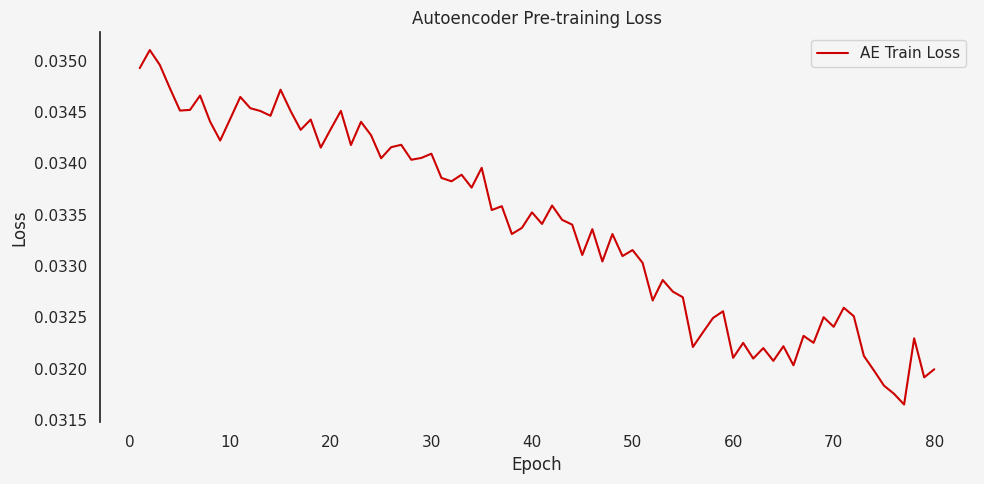


Phase 2: Training PPI Model with PU Learning

Training PPI model with PU learning...


Epoch 1/80: 100%|██████████| 59/59 [00:54<00:00,  1.08it/s]


Epoch 1: Train Loss: 0.7367, Val Loss: 0.6626


Epoch 2/80: 100%|██████████| 59/59 [00:54<00:00,  1.08it/s]


Epoch 2: Train Loss: 0.5291, Val Loss: 0.5395


Epoch 3/80: 100%|██████████| 59/59 [00:54<00:00,  1.08it/s]


Epoch 3: Train Loss: 0.3767, Val Loss: 0.4372


Epoch 4/80: 100%|██████████| 59/59 [00:54<00:00,  1.08it/s]


Epoch 4: Train Loss: 0.2802, Val Loss: 0.3361


Epoch 5/80: 100%|██████████| 59/59 [00:54<00:00,  1.08it/s]


Epoch 5: Train Loss: 0.1878, Val Loss: 0.2501


Epoch 6/80: 100%|██████████| 59/59 [00:54<00:00,  1.08it/s]


Epoch 6: Train Loss: 0.1277, Val Loss: 0.1827


Epoch 7/80: 100%|██████████| 59/59 [00:54<00:00,  1.09it/s]


Epoch 7: Train Loss: 0.0871, Val Loss: 0.1245


Epoch 8/80: 100%|██████████| 59/59 [00:54<00:00,  1.08it/s]


Epoch 8: Train Loss: 0.0624, Val Loss: 0.0858


Epoch 9/80: 100%|██████████| 59/59 [00:54<00:00,  1.08it/s]


Epoch 9: Train Loss: 0.0523, Val Loss: 0.0658


Epoch 10/80: 100%|██████████| 59/59 [00:54<00:00,  1.08it/s]


Epoch 10: Train Loss: 0.0474, Val Loss: 0.0628


Epoch 11/80: 100%|██████████| 59/59 [00:54<00:00,  1.09it/s]


Epoch 11: Train Loss: 0.0437, Val Loss: 0.0535


Epoch 12/80: 100%|██████████| 59/59 [00:54<00:00,  1.08it/s]


Epoch 12: Train Loss: 0.0433, Val Loss: 0.0502


Epoch 13/80: 100%|██████████| 59/59 [00:54<00:00,  1.08it/s]


Epoch 13: Train Loss: 0.0403, Val Loss: 0.0485


Epoch 14/80: 100%|██████████| 59/59 [00:54<00:00,  1.08it/s]


Epoch 14: Train Loss: 0.0390, Val Loss: 0.0428


Epoch 15/80: 100%|██████████| 59/59 [00:54<00:00,  1.08it/s]


Epoch 15: Train Loss: 0.0358, Val Loss: 0.0416


Epoch 16/80: 100%|██████████| 59/59 [00:54<00:00,  1.08it/s]


Epoch 16: Train Loss: 0.0328, Val Loss: 0.0420


Epoch 17/80: 100%|██████████| 59/59 [00:54<00:00,  1.08it/s]


Epoch 17: Train Loss: 0.0331, Val Loss: 0.0356


Epoch 18/80: 100%|██████████| 59/59 [00:54<00:00,  1.08it/s]


Epoch 18: Train Loss: 0.0307, Val Loss: 0.0364


Epoch 19/80: 100%|██████████| 59/59 [00:54<00:00,  1.09it/s]


Epoch 19: Train Loss: 0.0285, Val Loss: 0.0323


Epoch 20/80: 100%|██████████| 59/59 [00:54<00:00,  1.08it/s]


Epoch 20: Train Loss: 0.0267, Val Loss: 0.0347


Epoch 21/80: 100%|██████████| 59/59 [00:54<00:00,  1.08it/s]


Epoch 21: Train Loss: 0.0263, Val Loss: 0.0301


Epoch 22/80: 100%|██████████| 59/59 [00:54<00:00,  1.08it/s]


Epoch 22: Train Loss: 0.0249, Val Loss: 0.0276


Epoch 23/80: 100%|██████████| 59/59 [00:54<00:00,  1.08it/s]


Epoch 23: Train Loss: 0.0239, Val Loss: 0.0273


Epoch 24/80: 100%|██████████| 59/59 [00:54<00:00,  1.08it/s]


Epoch 24: Train Loss: 0.0230, Val Loss: 0.0239


Epoch 25/80: 100%|██████████| 59/59 [00:54<00:00,  1.08it/s]


Epoch 25: Train Loss: 0.0213, Val Loss: 0.0212


Epoch 26/80: 100%|██████████| 59/59 [00:54<00:00,  1.08it/s]


Epoch 26: Train Loss: 0.0214, Val Loss: 0.0235


Epoch 27/80: 100%|██████████| 59/59 [00:54<00:00,  1.08it/s]


Epoch 27: Train Loss: 0.0192, Val Loss: 0.0238


Epoch 28/80: 100%|██████████| 59/59 [00:54<00:00,  1.08it/s]


Epoch 28: Train Loss: 0.0182, Val Loss: 0.0236


Epoch 29/80: 100%|██████████| 59/59 [00:54<00:00,  1.08it/s]


Epoch 29: Train Loss: 0.0173, Val Loss: 0.0226


Epoch 30/80: 100%|██████████| 59/59 [00:54<00:00,  1.08it/s]


Epoch 30: Train Loss: 0.0171, Val Loss: 0.0205


Epoch 31/80: 100%|██████████| 59/59 [00:54<00:00,  1.08it/s]


Epoch 31: Train Loss: 0.0159, Val Loss: 0.0201


Epoch 32/80: 100%|██████████| 59/59 [00:54<00:00,  1.08it/s]


Epoch 32: Train Loss: 0.0174, Val Loss: 0.0152


Epoch 33/80: 100%|██████████| 59/59 [00:54<00:00,  1.09it/s]


Epoch 33: Train Loss: 0.0154, Val Loss: 0.0138


Epoch 34/80: 100%|██████████| 59/59 [00:54<00:00,  1.08it/s]


Epoch 34: Train Loss: 0.0144, Val Loss: 0.0167


Epoch 35/80: 100%|██████████| 59/59 [00:54<00:00,  1.08it/s]


Epoch 35: Train Loss: 0.0137, Val Loss: 0.0157


Epoch 36/80: 100%|██████████| 59/59 [00:54<00:00,  1.08it/s]


Epoch 36: Train Loss: 0.0130, Val Loss: 0.0134


Epoch 37/80: 100%|██████████| 59/59 [00:54<00:00,  1.08it/s]


Epoch 37: Train Loss: 0.0126, Val Loss: 0.0139


Epoch 38/80: 100%|██████████| 59/59 [00:54<00:00,  1.08it/s]


Epoch 38: Train Loss: 0.0119, Val Loss: 0.0186


Epoch 39/80: 100%|██████████| 59/59 [00:54<00:00,  1.09it/s]


Epoch 39: Train Loss: 0.0120, Val Loss: 0.0158


Epoch 40/80: 100%|██████████| 59/59 [00:54<00:00,  1.09it/s]


Epoch 40: Train Loss: 0.0105, Val Loss: 0.0237


Epoch 41/80: 100%|██████████| 59/59 [00:54<00:00,  1.08it/s]


Epoch 41: Train Loss: 0.0105, Val Loss: 0.0195


Epoch 42/80: 100%|██████████| 59/59 [00:54<00:00,  1.08it/s]


Epoch 42: Train Loss: 0.0114, Val Loss: 0.0124


Epoch 43/80: 100%|██████████| 59/59 [00:54<00:00,  1.09it/s]


Epoch 43: Train Loss: 0.0106, Val Loss: 0.0102


Epoch 44/80: 100%|██████████| 59/59 [00:54<00:00,  1.08it/s]


Epoch 44: Train Loss: 0.0099, Val Loss: 0.0121


Epoch 45/80: 100%|██████████| 59/59 [00:54<00:00,  1.08it/s]


Epoch 45: Train Loss: 0.0102, Val Loss: 0.0126


Epoch 46/80: 100%|██████████| 59/59 [00:54<00:00,  1.08it/s]


Epoch 46: Train Loss: 0.0092, Val Loss: 0.0119


Epoch 47/80: 100%|██████████| 59/59 [00:54<00:00,  1.08it/s]


Epoch 47: Train Loss: 0.0089, Val Loss: 0.0106


Epoch 48/80: 100%|██████████| 59/59 [00:54<00:00,  1.08it/s]


Epoch 48: Train Loss: 0.0087, Val Loss: 0.0128


Epoch 49/80: 100%|██████████| 59/59 [00:54<00:00,  1.08it/s]


Epoch 49: Train Loss: 0.0086, Val Loss: 0.0106


Epoch 50/80: 100%|██████████| 59/59 [00:54<00:00,  1.09it/s]


Epoch 50: Train Loss: 0.0082, Val Loss: 0.0092


Epoch 51/80: 100%|██████████| 59/59 [00:54<00:00,  1.08it/s]


Epoch 51: Train Loss: 0.0080, Val Loss: 0.0096


Epoch 52/80: 100%|██████████| 59/59 [00:54<00:00,  1.09it/s]


Epoch 52: Train Loss: 0.0080, Val Loss: 0.0077


Epoch 53/80: 100%|██████████| 59/59 [00:54<00:00,  1.08it/s]


Epoch 53: Train Loss: 0.0076, Val Loss: 0.0077


Epoch 54/80: 100%|██████████| 59/59 [00:54<00:00,  1.08it/s]


Epoch 54: Train Loss: 0.0075, Val Loss: 0.0078


Epoch 55/80: 100%|██████████| 59/59 [00:54<00:00,  1.08it/s]


Epoch 55: Train Loss: 0.0064, Val Loss: 0.0074


Epoch 56/80: 100%|██████████| 59/59 [00:54<00:00,  1.08it/s]


Epoch 56: Train Loss: 0.0067, Val Loss: 0.0067


Epoch 57/80: 100%|██████████| 59/59 [00:54<00:00,  1.08it/s]


Epoch 57: Train Loss: 0.0065, Val Loss: 0.0065


Epoch 58/80: 100%|██████████| 59/59 [00:54<00:00,  1.08it/s]


Epoch 58: Train Loss: 0.0062, Val Loss: 0.0067


Epoch 59/80: 100%|██████████| 59/59 [00:54<00:00,  1.08it/s]


Epoch 59: Train Loss: 0.0061, Val Loss: 0.0066


Epoch 60/80: 100%|██████████| 59/59 [00:54<00:00,  1.08it/s]


Epoch 60: Train Loss: 0.0054, Val Loss: 0.0059


Epoch 61/80: 100%|██████████| 59/59 [00:54<00:00,  1.08it/s]


Epoch 61: Train Loss: 0.0053, Val Loss: 0.0057


Epoch 62/80: 100%|██████████| 59/59 [00:54<00:00,  1.08it/s]


Epoch 62: Train Loss: 0.0053, Val Loss: 0.0057


Epoch 63/80: 100%|██████████| 59/59 [00:54<00:00,  1.09it/s]


Epoch 63: Train Loss: 0.0052, Val Loss: 0.0054


Epoch 64/80: 100%|██████████| 59/59 [00:54<00:00,  1.08it/s]


Epoch 64: Train Loss: 0.0051, Val Loss: 0.0057


Epoch 65/80: 100%|██████████| 59/59 [00:54<00:00,  1.08it/s]


Epoch 65: Train Loss: 0.0048, Val Loss: 0.0055


Epoch 66/80: 100%|██████████| 59/59 [00:54<00:00,  1.08it/s]


Epoch 66: Train Loss: 0.0046, Val Loss: 0.0061


Epoch 67/80: 100%|██████████| 59/59 [00:54<00:00,  1.08it/s]


Epoch 67: Train Loss: 0.0041, Val Loss: 0.0073


Epoch 68/80: 100%|██████████| 59/59 [00:54<00:00,  1.08it/s]


Epoch 68: Train Loss: 0.0040, Val Loss: 0.0084


Epoch 69/80: 100%|██████████| 59/59 [00:54<00:00,  1.08it/s]


Epoch 69: Train Loss: 0.0039, Val Loss: 0.0081


Epoch 70/80: 100%|██████████| 59/59 [00:54<00:00,  1.08it/s]


Epoch 70: Train Loss: 0.0036, Val Loss: 0.0093


Epoch 71/80: 100%|██████████| 59/59 [00:54<00:00,  1.09it/s]


Epoch 71: Train Loss: 0.0036, Val Loss: 0.0095


Epoch 72/80: 100%|██████████| 59/59 [00:54<00:00,  1.08it/s]


Epoch 72: Train Loss: 0.0035, Val Loss: 0.0099


Epoch 73/80: 100%|██████████| 59/59 [00:54<00:00,  1.08it/s]


Epoch 73: Train Loss: 0.0038, Val Loss: 0.0128


Epoch 74/80: 100%|██████████| 59/59 [00:54<00:00,  1.08it/s]


Epoch 74: Train Loss: 0.0038, Val Loss: 0.0103


Epoch 75/80: 100%|██████████| 59/59 [00:54<00:00,  1.08it/s]


Epoch 75: Train Loss: 0.0037, Val Loss: 0.0099


Epoch 76/80: 100%|██████████| 59/59 [00:54<00:00,  1.08it/s]


Epoch 76: Train Loss: 0.0035, Val Loss: 0.0094


Epoch 77/80: 100%|██████████| 59/59 [00:54<00:00,  1.08it/s]


Epoch 77: Train Loss: 0.0040, Val Loss: 0.0052


Epoch 78/80: 100%|██████████| 59/59 [00:54<00:00,  1.08it/s]


Epoch 78: Train Loss: 0.0034, Val Loss: 0.0051


Epoch 79/80: 100%|██████████| 59/59 [00:54<00:00,  1.09it/s]


Epoch 79: Train Loss: 0.0034, Val Loss: 0.0062


Epoch 80/80: 100%|██████████| 59/59 [00:54<00:00,  1.08it/s]


Epoch 80: Train Loss: 0.0031, Val Loss: 0.0058


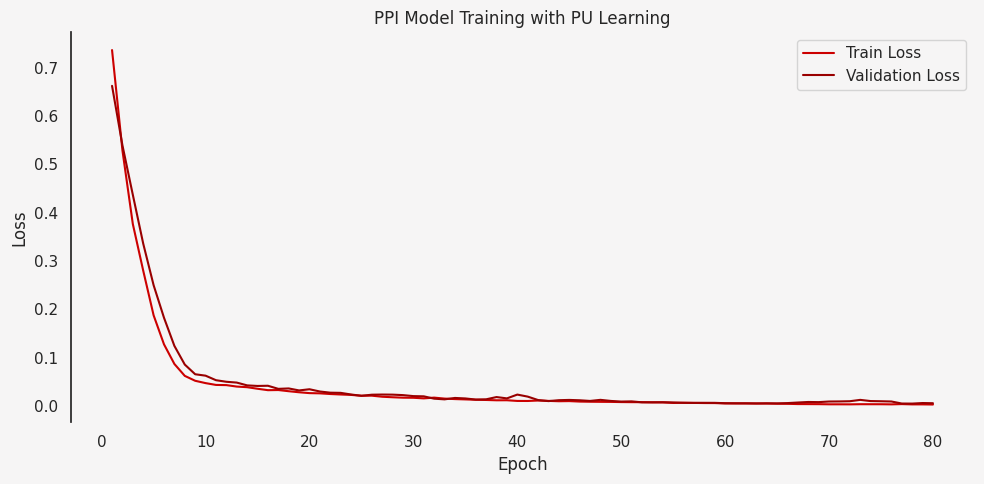


Evaluation

Evaluating on TRAINING data...

Evaluating on Training Dataset


Evaluating Training: 100%|██████████| 59/59 [00:20<00:00,  2.88it/s]


AUC-ROC: 0.9992
AUPR: 0.9998

Metrics at fixed threshold (0.92):
Precision: 1.0000
Recall:    0.9035
F1 Score:  0.9493
Accuracy:  0.9227
Confusion Matrix:
[[1489    0]
 [ 578 5409]]


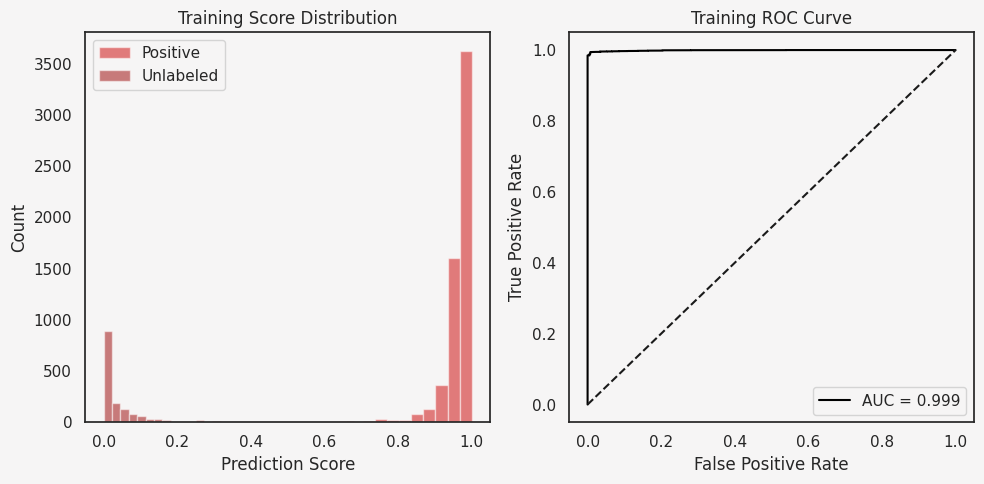

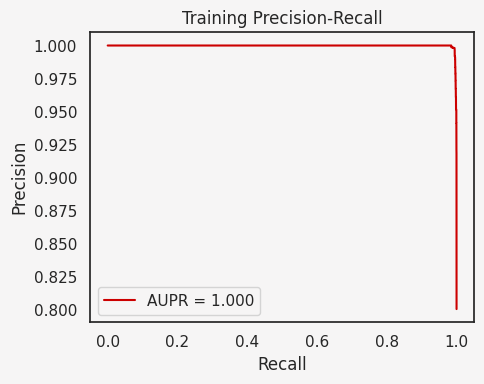


Evaluating on TEST data...

Evaluating on Test Dataset


Evaluating Test: 100%|██████████| 13/13 [00:04<00:00,  2.94it/s]


AUC-ROC: 0.9962
AUPR: 0.9998

Metrics at fixed threshold (0.92):
Precision: 1.0000
Recall:    0.8854
F1 Score:  0.9392
Accuracy:  0.8908
Confusion Matrix:
[[  75    0]
 [ 175 1352]]


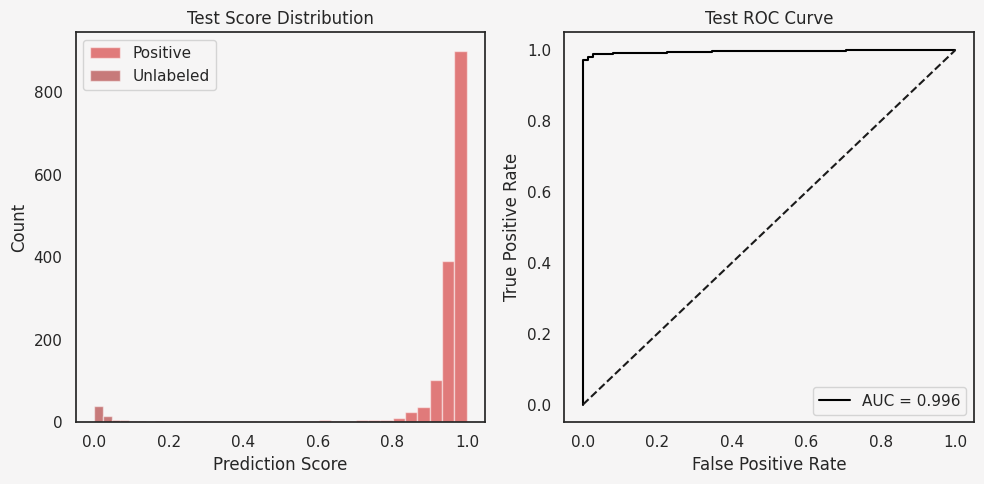

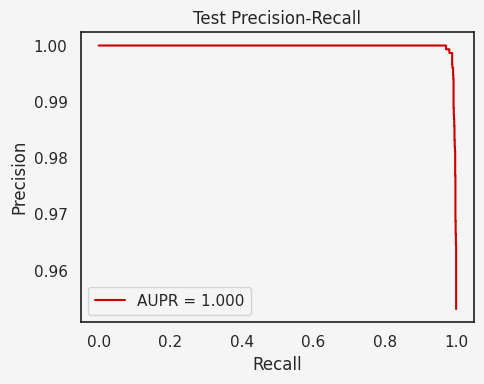


EVALUATING ALZHEIMER PROTEIN-PROTEIN INTERACTIONS


,UniProt_A,UniProt_B,SequenceA,SequenceB
0,P37840-1,P37840-1,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...
1,P37840-1,P37840-1,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...
2,P37840-1,P37840-1,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...
3,P37840-1,P37840-1,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...
4,P37840-1,P37840-1,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...


Loaded dataset with 10310 protein pairs
Processing 10310 pairs in batches of 32...


Processing batches: 100%|██████████| 323/323 [00:27<00:00, 11.85it/s]


Processing complete. Errors encountered: 0

DETAILED ANALYSIS RESULTS
Total pairs evaluated: 10310
Predicted interactions (YES): 10291 (99.8%)
Predicted non-interactions (NO): 19 (0.2%)
High confidence predictions: 9997 (97.0%)
Low confidence predictions: 313 (3.0%)

Probability Statistics:
  Mean: 0.9286
  Std:  0.0571
  Range: [0.1140, 0.9961]

TOP 10 PREDICTED INTERACTIONS
------------------------------------------------------------
 1. P23297-P04271                  | Prob: 0.9961 | Conf: high | Lengths:  94,  92
 2. Q8TB24-P35527                  | Prob: 0.9930 | Conf: high | Lengths: 985, 623
 3. Q8TB24-P02533                  | Prob: 0.9923 | Conf: high | Lengths: 985, 472
 4. Q9Y2W7-Q61144                  | Prob: 0.9911 | Conf: high | Lengths: 256, 448
 5. Q8TB24-P62829                  | Prob: 0.9909 | Conf: high | Lengths: 985, 140
 6. Q8TB24-P13645                  | Prob: 0.9909 | Conf: high | Lengths: 985, 584
 7. P21926-Q8IWA5                  | Prob: 0.9900 | Conf: high

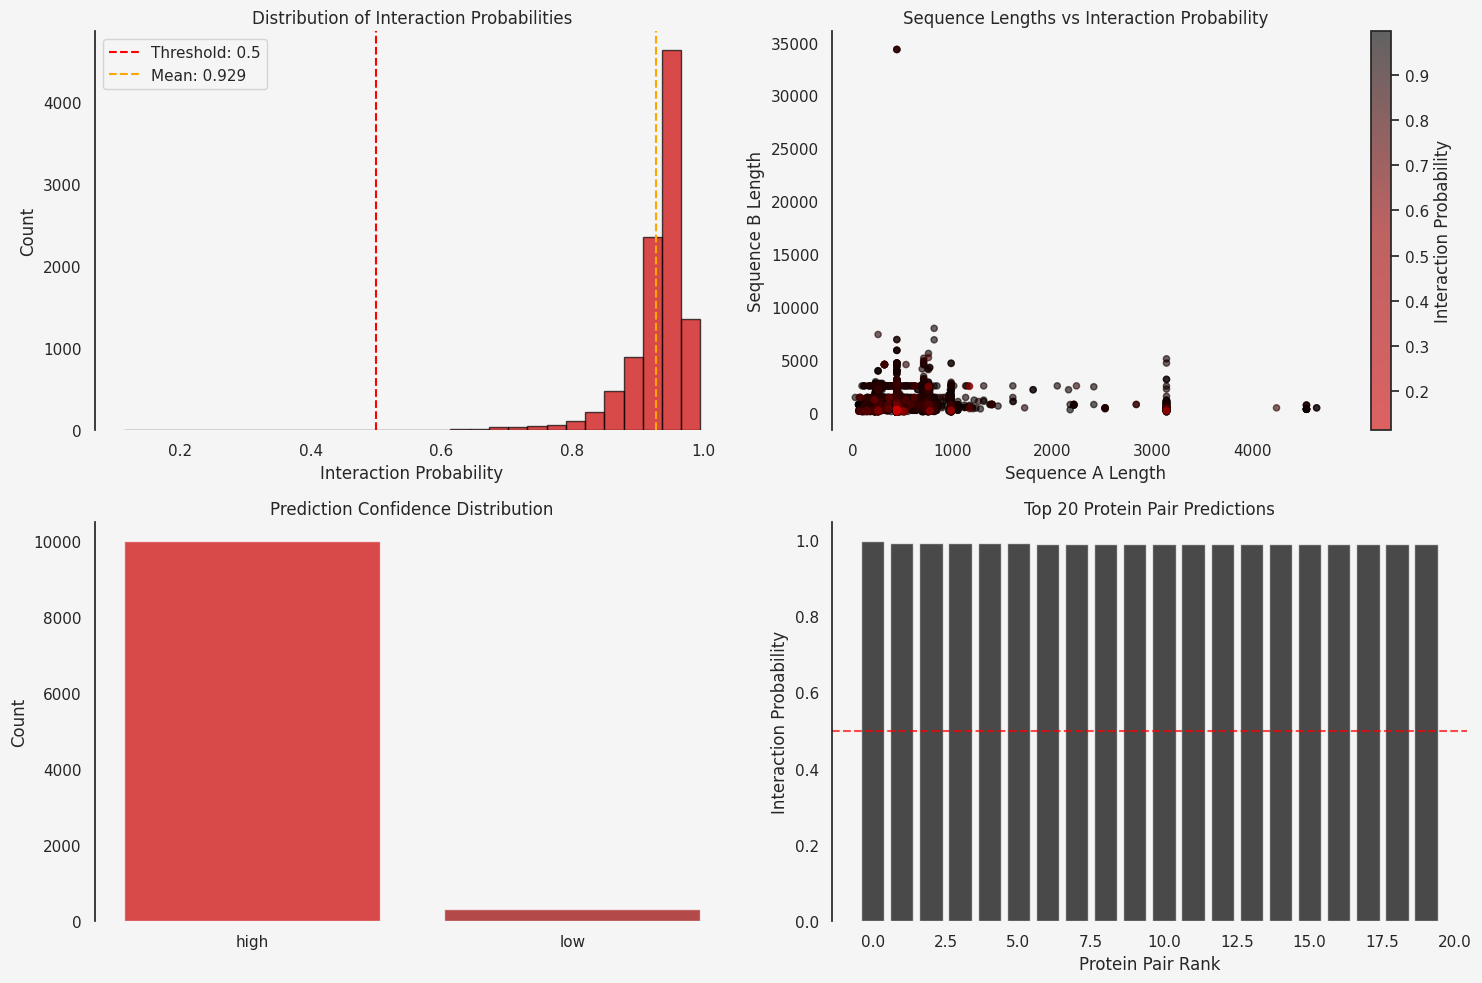

Visualization saved to: /content/drive/MyDrive/alzheimer_evaluation_analysis.png

Saving Models
Autoencoder + PU models saved successfully!


{'encoder': DirectSequenceEncoder(
   (aa_embedding): Embedding(22, 128, padding_idx=0)
   (lstm): LSTM(128, 256, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
   (attention): Sequential(
     (0): Linear(in_features=512, out_features=256, bias=True)
     (1): Tanh()
     (2): Linear(in_features=256, out_features=1, bias=True)
   )
   (fc_latent): Sequential(
     (0): Linear(in_features=512, out_features=256, bias=True)
     (1): ReLU()
     (2): Dropout(p=0.2, inplace=False)
     (3): Linear(in_features=256, out_features=64, bias=True)
   )
   (decoder_lstm): LSTM(64, 256, num_layers=2, batch_first=True, dropout=0.2)
   (fc_decode): Linear(in_features=256, out_features=20, bias=True)
 ),
 'ppi_model': PULearningPPIModel(
   (network): Sequential(
     (0): Linear(in_features=355, out_features=256, bias=True)
     (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU()
     (3): Dropout(p=0.4, inplace=False)
     (4): L

In [14]:
run_autoencoder_pu_pipeline()

GAN TRAINING PIPELINE
Loading and Preparing Data

Loading dataset...
Dataset shape: (10782, 105)
Filtered dataset shape: (10680, 105)

Label distribution (1=Positive, 0=Unlabeled/Negative):
label
1    10180
0      500
Name: count, dtype: int64

Dataset splits:
Train: 7476 samples
Validation: 1602 samples
Test: 1602 samples
Dataloader batches - Train: 59, Val: 13, Test: 13
Positives-only train batches (GAN): 55
Encoder parameters: 3,510,869

Initializing GAN
GAN Generator parameters: 4,944,916
GAN Discriminator parameters: 3,281,409

Training GAN for Sequence Generation

Training GAN with improved stability measures...


GAN Epoch 1/80: 100%|██████████| 55/55 [00:47<00:00,  1.16it/s]


Epoch 1: G_Loss: 1.9125, D_Loss(total): -2.1261, Noise: 0.1000 | AvgSeqLen(full)=539.2
  Positive samples: 7040 | Negative samples: 0 | Batches: 55
  Critic: W-dist≈4.9883 | D_real=2.9658 | D_fake=-2.0224 | GP=2.8622


GAN Epoch 2/80: 100%|██████████| 55/55 [00:47<00:00,  1.16it/s]


Epoch 2: G_Loss: 2.3302, D_Loss(total): -4.3918, Noise: 0.0950 | AvgSeqLen(full)=538.6
  Positive samples: 7040 | Negative samples: 0 | Batches: 55
  Critic: W-dist≈5.4772 | D_real=4.0318 | D_fake=-1.4454 | GP=1.0854


GAN Epoch 3/80: 100%|██████████| 55/55 [00:47<00:00,  1.16it/s]


Epoch 3: G_Loss: 2.5677, D_Loss(total): -5.3082, Noise: 0.0902 | AvgSeqLen(full)=539.1
  Positive samples: 7040 | Negative samples: 0 | Batches: 55
  Critic: W-dist≈6.7317 | D_real=5.6330 | D_fake=-1.0989 | GP=1.4235


GAN Epoch 4/80: 100%|██████████| 55/55 [00:47<00:00,  1.16it/s]


Epoch 4: G_Loss: 3.2273, D_Loss(total): -6.6663, Noise: 0.0857 | AvgSeqLen(full)=539.4
  Positive samples: 7040 | Negative samples: 0 | Batches: 55
  Critic: W-dist≈7.2238 | D_real=5.6109 | D_fake=-1.6130 | GP=0.5574


GAN Epoch 5/80: 100%|██████████| 55/55 [00:47<00:00,  1.16it/s]


Epoch 5: G_Loss: 1.4947, D_Loss(total): -6.8255, Noise: 0.0815 | AvgSeqLen(full)=537.8
  Positive samples: 7040 | Negative samples: 0 | Batches: 55
  Critic: W-dist≈9.1699 | D_real=6.5313 | D_fake=-2.6385 | GP=2.3443


GAN Epoch 6/80: 100%|██████████| 55/55 [00:47<00:00,  1.16it/s]


Epoch 6: G_Loss: 2.6909, D_Loss(total): -7.1117, Noise: 0.0774 | AvgSeqLen(full)=539.1
  Positive samples: 7040 | Negative samples: 0 | Batches: 55
  Critic: W-dist≈8.1599 | D_real=6.7974 | D_fake=-1.3626 | GP=1.0482


GAN Epoch 7/80: 100%|██████████| 55/55 [00:47<00:00,  1.16it/s]


Epoch 7: G_Loss: 1.9777, D_Loss(total): -7.0670, Noise: 0.0735 | AvgSeqLen(full)=538.4
  Positive samples: 7040 | Negative samples: 0 | Batches: 55
  Critic: W-dist≈8.1692 | D_real=7.5107 | D_fake=-0.6585 | GP=1.1021


GAN Epoch 8/80: 100%|██████████| 55/55 [00:47<00:00,  1.16it/s]


Epoch 8: G_Loss: -0.2208, D_Loss(total): -6.3167, Noise: 0.0698 | AvgSeqLen(full)=538.1
  Positive samples: 7040 | Negative samples: 0 | Batches: 55
  Critic: W-dist≈9.9183 | D_real=8.9080 | D_fake=-1.0107 | GP=3.6015


GAN Epoch 9/80: 100%|██████████| 55/55 [00:47<00:00,  1.16it/s]


Epoch 9: G_Loss: 0.6084, D_Loss(total): -6.0971, Noise: 0.0663 | AvgSeqLen(full)=538.7
  Positive samples: 7040 | Negative samples: 0 | Batches: 55
  Critic: W-dist≈9.6555 | D_real=8.4391 | D_fake=-1.2164 | GP=3.5584


GAN Epoch 10/80: 100%|██████████| 55/55 [00:47<00:00,  1.16it/s]


Epoch 10: G_Loss: 0.8068, D_Loss(total): -7.0673, Noise: 0.0630 | AvgSeqLen(full)=538.1
  Positive samples: 7040 | Negative samples: 0 | Batches: 55
  Critic: W-dist≈8.0790 | D_real=8.2605 | D_fake=0.1815 | GP=1.0117


GAN Epoch 11/80: 100%|██████████| 55/55 [00:47<00:00,  1.16it/s]


Epoch 11: G_Loss: -0.1686, D_Loss(total): -5.5160, Noise: 0.0599 | AvgSeqLen(full)=539.5
  Positive samples: 7040 | Negative samples: 0 | Batches: 55
  Critic: W-dist≈8.4448 | D_real=8.3826 | D_fake=-0.0624 | GP=2.9288


GAN Epoch 12/80: 100%|██████████| 55/55 [00:47<00:00,  1.16it/s]


Epoch 12: G_Loss: -1.6500, D_Loss(total): -4.9973, Noise: 0.0569 | AvgSeqLen(full)=538.6
  Positive samples: 7040 | Negative samples: 0 | Batches: 55
  Critic: W-dist≈6.3392 | D_real=8.2033 | D_fake=1.8640 | GP=1.3419


GAN Epoch 13/80: 100%|██████████| 55/55 [00:47<00:00,  1.16it/s]


Epoch 13: G_Loss: -2.0811, D_Loss(total): -4.7303, Noise: 0.0540 | AvgSeqLen(full)=539.3
  Positive samples: 7040 | Negative samples: 0 | Batches: 55
  Critic: W-dist≈5.9279 | D_real=8.1676 | D_fake=2.2394 | GP=1.1976


GAN Epoch 14/80: 100%|██████████| 55/55 [00:47<00:00,  1.16it/s]


Epoch 14: G_Loss: -3.2723, D_Loss(total): -3.4032, Noise: 0.0513 | AvgSeqLen(full)=538.9
  Positive samples: 7040 | Negative samples: 0 | Batches: 55
  Critic: W-dist≈4.2009 | D_real=7.7450 | D_fake=3.5440 | GP=0.7977


GAN Epoch 15/80: 100%|██████████| 55/55 [00:47<00:00,  1.16it/s]


Epoch 15: G_Loss: -2.8927, D_Loss(total): -2.7414, Noise: 0.0488 | AvgSeqLen(full)=538.8
  Positive samples: 7040 | Negative samples: 0 | Batches: 55
  Critic: W-dist≈3.8950 | D_real=6.9570 | D_fake=3.0620 | GP=1.1536


GAN Epoch 16/80: 100%|██████████| 55/55 [00:47<00:00,  1.16it/s]


Epoch 16: G_Loss: -3.0014, D_Loss(total): -2.5189, Noise: 0.0463 | AvgSeqLen(full)=539.2
  Positive samples: 7040 | Negative samples: 0 | Batches: 55
  Critic: W-dist≈3.1441 | D_real=6.3384 | D_fake=3.1942 | GP=0.6252


GAN Epoch 17/80: 100%|██████████| 55/55 [00:47<00:00,  1.16it/s]


Epoch 17: G_Loss: -2.9830, D_Loss(total): -2.3816, Noise: 0.0440 | AvgSeqLen(full)=534.5
  Positive samples: 7040 | Negative samples: 0 | Batches: 55
  Critic: W-dist≈3.0014 | D_real=6.2413 | D_fake=3.2398 | GP=0.6198


GAN Epoch 18/80: 100%|██████████| 55/55 [00:47<00:00,  1.16it/s]


Epoch 18: G_Loss: -3.5760, D_Loss(total): -2.1084, Noise: 0.0418 | AvgSeqLen(full)=539.2
  Positive samples: 7040 | Negative samples: 0 | Batches: 55
  Critic: W-dist≈2.7581 | D_real=6.4665 | D_fake=3.7083 | GP=0.6497


GAN Epoch 19/80: 100%|██████████| 55/55 [00:47<00:00,  1.16it/s]


Epoch 19: G_Loss: -3.8346, D_Loss(total): -1.7503, Noise: 0.0397 | AvgSeqLen(full)=538.1
  Positive samples: 7040 | Negative samples: 0 | Batches: 55
  Critic: W-dist≈2.2301 | D_real=6.1800 | D_fake=3.9498 | GP=0.4798


GAN Epoch 20/80: 100%|██████████| 55/55 [00:47<00:00,  1.16it/s]


Epoch 20: G_Loss: -3.6260, D_Loss(total): -1.8348, Noise: 0.0377 | AvgSeqLen(full)=539.7
  Positive samples: 7040 | Negative samples: 0 | Batches: 55
  Critic: W-dist≈2.3200 | D_real=6.0210 | D_fake=3.7010 | GP=0.4852


GAN Epoch 21/80: 100%|██████████| 55/55 [00:47<00:00,  1.16it/s]


Epoch 21: G_Loss: -3.5396, D_Loss(total): -1.6501, Noise: 0.0358 | AvgSeqLen(full)=537.7
  Positive samples: 7040 | Negative samples: 0 | Batches: 55
  Critic: W-dist≈2.1897 | D_real=5.7901 | D_fake=3.6005 | GP=0.5395


GAN Epoch 22/80: 100%|██████████| 55/55 [00:47<00:00,  1.16it/s]


Epoch 22: G_Loss: -3.4694, D_Loss(total): -1.4254, Noise: 0.0341 | AvgSeqLen(full)=539.2
  Positive samples: 7040 | Negative samples: 0 | Batches: 55
  Critic: W-dist≈1.7407 | D_real=5.2906 | D_fake=3.5499 | GP=0.3153


GAN Epoch 23/80: 100%|██████████| 55/55 [00:47<00:00,  1.16it/s]


Epoch 23: G_Loss: -2.9224, D_Loss(total): -1.6087, Noise: 0.0324 | AvgSeqLen(full)=539.1
  Positive samples: 7040 | Negative samples: 0 | Batches: 55
  Critic: W-dist≈1.8974 | D_real=4.9314 | D_fake=3.0340 | GP=0.2887


GAN Epoch 24/80: 100%|██████████| 55/55 [00:47<00:00,  1.16it/s]


Epoch 24: G_Loss: -2.7229, D_Loss(total): -1.7767, Noise: 0.0307 | AvgSeqLen(full)=538.6
  Positive samples: 7040 | Negative samples: 0 | Batches: 55
  Critic: W-dist≈2.0717 | D_real=4.8793 | D_fake=2.8077 | GP=0.2949


GAN Epoch 25/80: 100%|██████████| 55/55 [00:47<00:00,  1.16it/s]


Epoch 25: G_Loss: -2.1948, D_Loss(total): -2.0176, Noise: 0.0292 | AvgSeqLen(full)=539.5
  Positive samples: 7040 | Negative samples: 0 | Batches: 55
  Critic: W-dist≈2.4072 | D_real=4.7342 | D_fake=2.3270 | GP=0.3896


GAN Epoch 26/80: 100%|██████████| 55/55 [00:47<00:00,  1.17it/s]


Epoch 26: G_Loss: -1.6487, D_Loss(total): -2.1004, Noise: 0.0277 | AvgSeqLen(full)=538.7
  Positive samples: 7040 | Negative samples: 0 | Batches: 55
  Critic: W-dist≈2.5797 | D_real=4.2879 | D_fake=1.7080 | GP=0.4793


GAN Epoch 27/80: 100%|██████████| 55/55 [00:47<00:00,  1.17it/s]


Epoch 27: G_Loss: -1.5052, D_Loss(total): -2.1126, Noise: 0.0264 | AvgSeqLen(full)=539.2
  Positive samples: 7040 | Negative samples: 0 | Batches: 55
  Critic: W-dist≈2.6461 | D_real=4.1998 | D_fake=1.5537 | GP=0.5334


GAN Epoch 28/80: 100%|██████████| 55/55 [00:47<00:00,  1.17it/s]


Epoch 28: G_Loss: -0.9711, D_Loss(total): -1.8909, Noise: 0.0250 | AvgSeqLen(full)=538.5
  Positive samples: 7040 | Negative samples: 0 | Batches: 55
  Critic: W-dist≈2.4257 | D_real=3.4272 | D_fake=1.0015 | GP=0.5348


GAN Epoch 29/80: 100%|██████████| 55/55 [00:47<00:00,  1.17it/s]


Epoch 29: G_Loss: -1.1566, D_Loss(total): -1.9035, Noise: 0.0238 | AvgSeqLen(full)=538.5
  Positive samples: 7040 | Negative samples: 0 | Batches: 55
  Critic: W-dist≈2.2204 | D_real=3.4383 | D_fake=1.2180 | GP=0.3169


GAN Epoch 30/80: 100%|██████████| 55/55 [00:47<00:00,  1.17it/s]


Epoch 30: G_Loss: -1.2174, D_Loss(total): -1.8475, Noise: 0.0226 | AvgSeqLen(full)=538.2
  Positive samples: 7040 | Negative samples: 0 | Batches: 55
  Critic: W-dist≈2.2483 | D_real=3.5033 | D_fake=1.2551 | GP=0.4008


GAN Epoch 31/80: 100%|██████████| 55/55 [00:47<00:00,  1.17it/s]


Epoch 31: G_Loss: -1.1426, D_Loss(total): -1.8587, Noise: 0.0215 | AvgSeqLen(full)=539.0
  Positive samples: 7040 | Negative samples: 0 | Batches: 55
  Critic: W-dist≈2.3197 | D_real=3.5306 | D_fake=1.2108 | GP=0.4610


GAN Epoch 32/80: 100%|██████████| 55/55 [00:47<00:00,  1.17it/s]


Epoch 32: G_Loss: -0.5001, D_Loss(total): -1.9677, Noise: 0.0204 | AvgSeqLen(full)=538.9
  Positive samples: 7040 | Negative samples: 0 | Batches: 55
  Critic: W-dist≈2.3597 | D_real=2.8332 | D_fake=0.4735 | GP=0.3920


GAN Epoch 33/80: 100%|██████████| 55/55 [00:47<00:00,  1.17it/s]


Epoch 33: G_Loss: 0.2333, D_Loss(total): -2.0703, Noise: 0.0194 | AvgSeqLen(full)=539.1
  Positive samples: 7040 | Negative samples: 0 | Batches: 55
  Critic: W-dist≈2.4910 | D_real=2.3093 | D_fake=-0.1818 | GP=0.4208


GAN Epoch 34/80: 100%|██████████| 55/55 [00:47<00:00,  1.16it/s]


Epoch 34: G_Loss: 0.5613, D_Loss(total): -2.1525, Noise: 0.0184 | AvgSeqLen(full)=539.2
  Positive samples: 7040 | Negative samples: 0 | Batches: 55
  Critic: W-dist≈2.5121 | D_real=2.0388 | D_fake=-0.4734 | GP=0.3596


GAN Epoch 35/80: 100%|██████████| 55/55 [00:47<00:00,  1.17it/s]


Epoch 35: G_Loss: 1.1264, D_Loss(total): -2.2680, Noise: 0.0175 | AvgSeqLen(full)=538.9
  Positive samples: 7040 | Negative samples: 0 | Batches: 55
  Critic: W-dist≈2.7042 | D_real=1.6714 | D_fake=-1.0328 | GP=0.4361


GAN Epoch 36/80: 100%|██████████| 55/55 [00:47<00:00,  1.17it/s]


Epoch 36: G_Loss: 1.4980, D_Loss(total): -2.3064, Noise: 0.0166 | AvgSeqLen(full)=538.5
  Positive samples: 7040 | Negative samples: 0 | Batches: 55
  Critic: W-dist≈2.7003 | D_real=1.2141 | D_fake=-1.4863 | GP=0.3938


GAN Epoch 37/80: 100%|██████████| 55/55 [00:47<00:00,  1.16it/s]


Epoch 37: G_Loss: 1.7574, D_Loss(total): -2.3757, Noise: 0.0158 | AvgSeqLen(full)=538.9
  Positive samples: 7040 | Negative samples: 0 | Batches: 55
  Critic: W-dist≈2.7918 | D_real=1.0830 | D_fake=-1.7086 | GP=0.4161


GAN Epoch 38/80: 100%|██████████| 55/55 [00:47<00:00,  1.16it/s]


Epoch 38: G_Loss: 1.9682, D_Loss(total): -2.4922, Noise: 0.0150 | AvgSeqLen(full)=538.3
  Positive samples: 7040 | Negative samples: 0 | Batches: 55
  Critic: W-dist≈2.8581 | D_real=0.9706 | D_fake=-1.8877 | GP=0.3659


GAN Epoch 39/80: 100%|██████████| 55/55 [00:47<00:00,  1.16it/s]


Epoch 39: G_Loss: 2.1065, D_Loss(total): -2.5400, Noise: 0.0142 | AvgSeqLen(full)=538.4
  Positive samples: 7040 | Negative samples: 0 | Batches: 55
  Critic: W-dist≈2.9787 | D_real=0.9558 | D_fake=-2.0230 | GP=0.4387


GAN Epoch 40/80: 100%|██████████| 55/55 [00:47<00:00,  1.16it/s]


Epoch 40: G_Loss: 2.2401, D_Loss(total): -2.5971, Noise: 0.0135 | AvgSeqLen(full)=539.9
  Positive samples: 7040 | Negative samples: 0 | Batches: 55
  Critic: W-dist≈3.1075 | D_real=0.8458 | D_fake=-2.2617 | GP=0.5104


GAN Epoch 41/80: 100%|██████████| 55/55 [00:47<00:00,  1.16it/s]


Epoch 41: G_Loss: 2.5760, D_Loss(total): -2.6671, Noise: 0.0129 | AvgSeqLen(full)=538.7
  Positive samples: 7040 | Negative samples: 0 | Batches: 55
  Critic: W-dist≈3.0959 | D_real=0.5957 | D_fake=-2.5001 | GP=0.4288


GAN Epoch 42/80: 100%|██████████| 55/55 [00:47<00:00,  1.16it/s]


Epoch 42: G_Loss: 3.0461, D_Loss(total): -2.7396, Noise: 0.0122 | AvgSeqLen(full)=539.0
  Positive samples: 7040 | Negative samples: 0 | Batches: 55
  Critic: W-dist≈3.2052 | D_real=0.1256 | D_fake=-3.0796 | GP=0.4656


GAN Epoch 43/80: 100%|██████████| 55/55 [00:47<00:00,  1.17it/s]


Epoch 43: G_Loss: 3.2116, D_Loss(total): -2.8366, Noise: 0.0116 | AvgSeqLen(full)=539.2
  Positive samples: 7040 | Negative samples: 0 | Batches: 55
  Critic: W-dist≈3.2343 | D_real=0.1005 | D_fake=-3.1337 | GP=0.3977


GAN Epoch 44/80: 100%|██████████| 55/55 [00:47<00:00,  1.16it/s]


Epoch 44: G_Loss: 3.6708, D_Loss(total): -2.8857, Noise: 0.0110 | AvgSeqLen(full)=538.2
  Positive samples: 7040 | Negative samples: 0 | Batches: 55
  Critic: W-dist≈3.3550 | D_real=-0.3773 | D_fake=-3.7325 | GP=0.4694


GAN Epoch 45/80: 100%|██████████| 55/55 [00:47<00:00,  1.16it/s]


Epoch 45: G_Loss: 4.0470, D_Loss(total): -2.9095, Noise: 0.0105 | AvgSeqLen(full)=539.7
  Positive samples: 7040 | Negative samples: 0 | Batches: 55
  Critic: W-dist≈3.4218 | D_real=-0.6533 | D_fake=-4.0751 | GP=0.5123


GAN Epoch 46/80: 100%|██████████| 55/55 [00:47<00:00,  1.17it/s]


Epoch 46: G_Loss: 4.1132, D_Loss(total): -3.0144, Noise: 0.0099 | AvgSeqLen(full)=537.7
  Positive samples: 7040 | Negative samples: 0 | Batches: 55
  Critic: W-dist≈3.4914 | D_real=-0.7262 | D_fake=-4.2177 | GP=0.4771


GAN Epoch 47/80: 100%|██████████| 55/55 [00:47<00:00,  1.16it/s]


Epoch 47: G_Loss: 4.4667, D_Loss(total): -3.0410, Noise: 0.0094 | AvgSeqLen(full)=538.9
  Positive samples: 7040 | Negative samples: 0 | Batches: 55
  Critic: W-dist≈3.5599 | D_real=-0.9028 | D_fake=-4.4627 | GP=0.5190


GAN Epoch 48/80: 100%|██████████| 55/55 [00:47<00:00,  1.16it/s]


Epoch 48: G_Loss: 4.7045, D_Loss(total): -3.0674, Noise: 0.0090 | AvgSeqLen(full)=539.2
  Positive samples: 7040 | Negative samples: 0 | Batches: 55
  Critic: W-dist≈3.5648 | D_real=-1.1134 | D_fake=-4.6781 | GP=0.4974


GAN Epoch 49/80: 100%|██████████| 55/55 [00:47<00:00,  1.16it/s]


Epoch 49: G_Loss: 4.9159, D_Loss(total): -3.1437, Noise: 0.0085 | AvgSeqLen(full)=539.1
  Positive samples: 7040 | Negative samples: 0 | Batches: 55
  Critic: W-dist≈3.6674 | D_real=-1.2543 | D_fake=-4.9218 | GP=0.5237


GAN Epoch 50/80: 100%|██████████| 55/55 [00:47<00:00,  1.16it/s]


Epoch 50: G_Loss: 5.1688, D_Loss(total): -3.2291, Noise: 0.0081 | AvgSeqLen(full)=538.6
  Positive samples: 7040 | Negative samples: 0 | Batches: 55
  Critic: W-dist≈3.8002 | D_real=-1.2818 | D_fake=-5.0820 | GP=0.5712


GAN Epoch 51/80: 100%|██████████| 55/55 [00:47<00:00,  1.16it/s]


Epoch 51: G_Loss: 5.4011, D_Loss(total): -3.2841, Noise: 0.0077 | AvgSeqLen(full)=538.9
  Positive samples: 7040 | Negative samples: 0 | Batches: 55
  Critic: W-dist≈3.9014 | D_real=-1.5461 | D_fake=-5.4477 | GP=0.6173


GAN Epoch 52/80: 100%|██████████| 55/55 [00:47<00:00,  1.16it/s]


Epoch 52: G_Loss: 5.5489, D_Loss(total): -3.3181, Noise: 0.0073 | AvgSeqLen(full)=538.3
  Positive samples: 7040 | Negative samples: 0 | Batches: 55
  Critic: W-dist≈3.8404 | D_real=-1.6310 | D_fake=-5.4716 | GP=0.5224


GAN Epoch 53/80: 100%|██████████| 55/55 [00:47<00:00,  1.16it/s]


Epoch 53: G_Loss: 5.7593, D_Loss(total): -3.3928, Noise: 0.0069 | AvgSeqLen(full)=539.2
  Positive samples: 7040 | Negative samples: 0 | Batches: 55
  Critic: W-dist≈3.9315 | D_real=-1.8836 | D_fake=-5.8151 | GP=0.5388


GAN Epoch 54/80: 100%|██████████| 55/55 [00:47<00:00,  1.17it/s]


Epoch 54: G_Loss: 5.9786, D_Loss(total): -3.3875, Noise: 0.0066 | AvgSeqLen(full)=540.2
  Positive samples: 7040 | Negative samples: 0 | Batches: 55
  Critic: W-dist≈3.9952 | D_real=-1.9669 | D_fake=-5.9622 | GP=0.6077


GAN Epoch 55/80: 100%|██████████| 55/55 [00:47<00:00,  1.16it/s]


Epoch 55: G_Loss: 6.1161, D_Loss(total): -3.3834, Noise: 0.0063 | AvgSeqLen(full)=538.1
  Positive samples: 7040 | Negative samples: 0 | Batches: 55
  Critic: W-dist≈3.9895 | D_real=-2.1036 | D_fake=-6.0930 | GP=0.6061


GAN Epoch 56/80: 100%|██████████| 55/55 [00:47<00:00,  1.16it/s]


Epoch 56: G_Loss: 6.3653, D_Loss(total): -3.4668, Noise: 0.0060 | AvgSeqLen(full)=539.2
  Positive samples: 7040 | Negative samples: 0 | Batches: 55
  Critic: W-dist≈4.1133 | D_real=-2.2657 | D_fake=-6.3790 | GP=0.6465


GAN Epoch 57/80: 100%|██████████| 55/55 [00:47<00:00,  1.16it/s]


Epoch 57: G_Loss: 6.2938, D_Loss(total): -3.4562, Noise: 0.0057 | AvgSeqLen(full)=538.8
  Positive samples: 7040 | Negative samples: 0 | Batches: 55
  Critic: W-dist≈4.0249 | D_real=-2.2464 | D_fake=-6.2713 | GP=0.5686


GAN Epoch 58/80: 100%|██████████| 55/55 [00:47<00:00,  1.16it/s]


Epoch 58: G_Loss: 5.8867, D_Loss(total): -3.3275, Noise: 0.0054 | AvgSeqLen(full)=538.6
  Positive samples: 7040 | Negative samples: 0 | Batches: 55
  Critic: W-dist≈3.9412 | D_real=-1.8986 | D_fake=-5.8400 | GP=0.6137


GAN Epoch 59/80: 100%|██████████| 55/55 [00:47<00:00,  1.16it/s]


Epoch 59: G_Loss: 6.2060, D_Loss(total): -3.3871, Noise: 0.0051 | AvgSeqLen(full)=539.3
  Positive samples: 7040 | Negative samples: 0 | Batches: 55
  Critic: W-dist≈3.9681 | D_real=-2.2491 | D_fake=-6.2173 | GP=0.5811


GAN Epoch 60/80: 100%|██████████| 55/55 [00:47<00:00,  1.16it/s]


Epoch 60: G_Loss: 6.3798, D_Loss(total): -3.4465, Noise: 0.0048 | AvgSeqLen(full)=538.7
  Positive samples: 7040 | Negative samples: 0 | Batches: 55
  Critic: W-dist≈4.0130 | D_real=-2.3697 | D_fake=-6.3828 | GP=0.5664


GAN Epoch 61/80: 100%|██████████| 55/55 [00:47<00:00,  1.16it/s]


Epoch 61: G_Loss: 6.6038, D_Loss(total): -3.4774, Noise: 0.0046 | AvgSeqLen(full)=538.5
  Positive samples: 7040 | Negative samples: 0 | Batches: 55
  Critic: W-dist≈3.9723 | D_real=-2.6490 | D_fake=-6.6212 | GP=0.4949


GAN Epoch 62/80: 100%|██████████| 55/55 [00:47<00:00,  1.17it/s]


Epoch 62: G_Loss: 6.9001, D_Loss(total): -3.5103, Noise: 0.0044 | AvgSeqLen(full)=539.1
  Positive samples: 7040 | Negative samples: 0 | Batches: 55
  Critic: W-dist≈4.0633 | D_real=-2.8118 | D_fake=-6.8750 | GP=0.5530


GAN Epoch 63/80: 100%|██████████| 55/55 [00:47<00:00,  1.16it/s]


Epoch 63: G_Loss: 6.7949, D_Loss(total): -3.5174, Noise: 0.0042 | AvgSeqLen(full)=537.9
  Positive samples: 7040 | Negative samples: 0 | Batches: 55
  Critic: W-dist≈4.0355 | D_real=-2.7320 | D_fake=-6.7671 | GP=0.5181


GAN Epoch 64/80: 100%|██████████| 55/55 [00:47<00:00,  1.16it/s]


Epoch 64: G_Loss: 7.0872, D_Loss(total): -3.5198, Noise: 0.0039 | AvgSeqLen(full)=538.8
  Positive samples: 7040 | Negative samples: 0 | Batches: 55
  Critic: W-dist≈4.0012 | D_real=-3.0456 | D_fake=-7.0468 | GP=0.4815


GAN Epoch 65/80: 100%|██████████| 55/55 [00:47<00:00,  1.16it/s]


Epoch 65: G_Loss: 6.9030, D_Loss(total): -3.5040, Noise: 0.0038 | AvgSeqLen(full)=538.7
  Positive samples: 7040 | Negative samples: 0 | Batches: 55
  Critic: W-dist≈4.1085 | D_real=-2.7657 | D_fake=-6.8741 | GP=0.6046


GAN Epoch 66/80: 100%|██████████| 55/55 [00:47<00:00,  1.16it/s]


Epoch 66: G_Loss: 7.0495, D_Loss(total): -3.5131, Noise: 0.0036 | AvgSeqLen(full)=539.2
  Positive samples: 7040 | Negative samples: 0 | Batches: 55
  Critic: W-dist≈4.1005 | D_real=-2.9167 | D_fake=-7.0172 | GP=0.5874


GAN Epoch 67/80: 100%|██████████| 55/55 [00:47<00:00,  1.16it/s]


Epoch 67: G_Loss: 7.2565, D_Loss(total): -3.5442, Noise: 0.0034 | AvgSeqLen(full)=533.1
  Positive samples: 7040 | Negative samples: 0 | Batches: 55
  Critic: W-dist≈4.1480 | D_real=-3.0927 | D_fake=-7.2405 | GP=0.6038


GAN Epoch 68/80: 100%|██████████| 55/55 [00:47<00:00,  1.16it/s]


Epoch 68: G_Loss: 7.2510, D_Loss(total): -3.5650, Noise: 0.0032 | AvgSeqLen(full)=537.9
  Positive samples: 7040 | Negative samples: 0 | Batches: 55
  Critic: W-dist≈4.1248 | D_real=-3.1028 | D_fake=-7.2275 | GP=0.5598


GAN Epoch 69/80: 100%|██████████| 55/55 [00:47<00:00,  1.16it/s]


Epoch 69: G_Loss: 7.3467, D_Loss(total): -3.6202, Noise: 0.0031 | AvgSeqLen(full)=539.3
  Positive samples: 7040 | Negative samples: 0 | Batches: 55
  Critic: W-dist≈4.1400 | D_real=-3.1701 | D_fake=-7.3102 | GP=0.5198


GAN Epoch 70/80: 100%|██████████| 55/55 [00:47<00:00,  1.16it/s]


Epoch 70: G_Loss: 7.3973, D_Loss(total): -3.5838, Noise: 0.0029 | AvgSeqLen(full)=537.9
  Positive samples: 7040 | Negative samples: 0 | Batches: 55
  Critic: W-dist≈4.1439 | D_real=-3.2286 | D_fake=-7.3727 | GP=0.5601


GAN Epoch 71/80: 100%|██████████| 55/55 [00:47<00:00,  1.17it/s]


Epoch 71: G_Loss: 7.4199, D_Loss(total): -3.6046, Noise: 0.0028 | AvgSeqLen(full)=538.7
  Positive samples: 7040 | Negative samples: 0 | Batches: 55
  Critic: W-dist≈4.1697 | D_real=-3.2370 | D_fake=-7.4067 | GP=0.5651


GAN Epoch 72/80: 100%|██████████| 55/55 [00:47<00:00,  1.16it/s]


Epoch 72: G_Loss: 7.4922, D_Loss(total): -3.5603, Noise: 0.0026 | AvgSeqLen(full)=538.4
  Positive samples: 7040 | Negative samples: 0 | Batches: 55
  Critic: W-dist≈4.1461 | D_real=-3.3233 | D_fake=-7.4693 | GP=0.5859


GAN Epoch 73/80: 100%|██████████| 55/55 [00:47<00:00,  1.16it/s]


Epoch 73: G_Loss: 7.5063, D_Loss(total): -3.6488, Noise: 0.0025 | AvgSeqLen(full)=538.6
  Positive samples: 7040 | Negative samples: 0 | Batches: 55
  Critic: W-dist≈4.2091 | D_real=-3.3080 | D_fake=-7.5170 | GP=0.5602


GAN Epoch 74/80: 100%|██████████| 55/55 [00:47<00:00,  1.16it/s]


Epoch 74: G_Loss: 7.5049, D_Loss(total): -3.6311, Noise: 0.0024 | AvgSeqLen(full)=539.5
  Positive samples: 7040 | Negative samples: 0 | Batches: 55
  Critic: W-dist≈4.1649 | D_real=-3.3250 | D_fake=-7.4901 | GP=0.5338


GAN Epoch 75/80: 100%|██████████| 55/55 [00:47<00:00,  1.16it/s]


Epoch 75: G_Loss: 7.4634, D_Loss(total): -3.5759, Noise: 0.0022 | AvgSeqLen(full)=538.2
  Positive samples: 7040 | Negative samples: 0 | Batches: 55
  Critic: W-dist≈4.1603 | D_real=-3.3069 | D_fake=-7.4675 | GP=0.5844


GAN Epoch 76/80: 100%|██████████| 55/55 [00:47<00:00,  1.16it/s]


Epoch 76: G_Loss: 7.5278, D_Loss(total): -3.5882, Noise: 0.0021 | AvgSeqLen(full)=538.8
  Positive samples: 7040 | Negative samples: 0 | Batches: 55
  Critic: W-dist≈4.1710 | D_real=-3.3182 | D_fake=-7.4889 | GP=0.5827


GAN Epoch 77/80: 100%|██████████| 55/55 [00:47<00:00,  1.16it/s]


Epoch 77: G_Loss: 7.5124, D_Loss(total): -3.6128, Noise: 0.0020 | AvgSeqLen(full)=538.8
  Positive samples: 7040 | Negative samples: 0 | Batches: 55
  Critic: W-dist≈4.1899 | D_real=-3.3398 | D_fake=-7.5298 | GP=0.5771


GAN Epoch 78/80: 100%|██████████| 55/55 [00:47<00:00,  1.16it/s]


Epoch 78: G_Loss: 7.5379, D_Loss(total): -3.6039, Noise: 0.0019 | AvgSeqLen(full)=533.3
  Positive samples: 7040 | Negative samples: 0 | Batches: 55
  Critic: W-dist≈4.1766 | D_real=-3.3612 | D_fake=-7.5379 | GP=0.5727


GAN Epoch 79/80: 100%|██████████| 55/55 [00:47<00:00,  1.16it/s]


Epoch 79: G_Loss: 7.5753, D_Loss(total): -3.5954, Noise: 0.0018 | AvgSeqLen(full)=538.0
  Positive samples: 7040 | Negative samples: 0 | Batches: 55
  Critic: W-dist≈4.1704 | D_real=-3.3761 | D_fake=-7.5467 | GP=0.5750


GAN Epoch 80/80: 100%|██████████| 55/55 [00:47<00:00,  1.16it/s]


Epoch 80: G_Loss: 7.5325, D_Loss(total): -3.6128, Noise: 0.0017 | AvgSeqLen(full)=538.9
  Positive samples: 7040 | Negative samples: 0 | Batches: 55
  Critic: W-dist≈4.1934 | D_real=-3.3642 | D_fake=-7.5577 | GP=0.5806


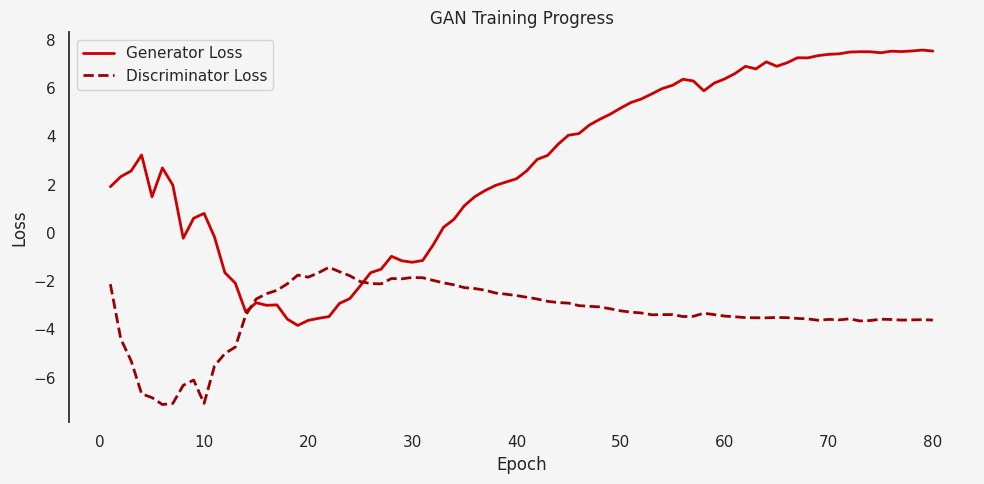


Generating Novel Protein Sequences with GAN
Generated 10 novel sequences (first 200 chars shown):
  Seq 1: MGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG...
  Seq 2: MLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLL...
  Seq 3: MMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMM...

Saving GAN Models
GAN models saved successfully!


{'encoder': DirectSequenceEncoder(
   (aa_embedding): Embedding(22, 128, padding_idx=0)
   (lstm): LSTM(128, 256, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
   (attention): Sequential(
     (0): Linear(in_features=512, out_features=256, bias=True)
     (1): Tanh()
     (2): Linear(in_features=256, out_features=1, bias=True)
   )
   (fc_latent): Sequential(
     (0): Linear(in_features=512, out_features=256, bias=True)
     (1): ReLU()
     (2): Dropout(p=0.2, inplace=False)
     (3): Linear(in_features=256, out_features=64, bias=True)
   )
   (decoder_lstm): LSTM(64, 256, num_layers=2, batch_first=True, dropout=0.2)
   (fc_decode): Linear(in_features=256, out_features=20, bias=True)
 ),
 'gan': ProteinGAN(
   (z_to_seq): Linear(in_features=64, out_features=25600, bias=True)
   (g_tr): TransformerEncoder(
     (layers): ModuleList(
       (0-3): 4 x TransformerEncoderLayer(
         (self_attn): MultiheadAttention(
           (out_proj): NonDynamicallyQuantizableLi

In [29]:
run_gan_pipeline()

COMPREHENSIVE ALZHEIMER PROTEIN ANALYSIS

--------------------------------------------------
Analyzing APP
--------------------------------------------------
Detected dimensions:
  Total input: 355
  Sequence features: 256
  Structural features: 99
Models loaded successfully!


,UniProt_A,UniProt_B,SequenceA,SequenceB
0,P37840-1,P37840-1,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...
1,P37840-1,P37840-1,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...
2,P37840-1,P37840-1,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...
3,P37840-1,P37840-1,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...
4,P37840-1,P37840-1,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...


Found 208 interaction partners for P05067

GENERATING INTERACTING PROTEINS FOR APP


Generating for APP: 100%|██████████| 200/200 [00:12<00:00, 15.66it/s]



Results for APP:
  Total generation attempts: 282
  Filtered (repetitive): 82
  Successfully tested: 200
  Candidates above threshold: 200
  Returning top: 100
  Repetition filter efficiency: 29.1% filtered

Top 10 candidates for APP:
------------------------------------------------------------------------------------------
   1. Prob: 0.9772 | Len: 100 | MGAREVPSESRSRRKLGRHSSHKRHHRRYGHYLSKRAHLRRGHRSGELRR...
   2. Prob: 0.9772 | Len: 100 | MLASSHARRHYSLSHRARARRKRGHKELAKGKLVERGAYRHRGEYRVEKL...
   3. Prob: 0.9772 | Len: 100 | MHHAYRRHHRYVARSHYAKRLGSHYYLGLPHYLRHRHLYRGARVRSSRLS...
   4. Prob: 0.9772 | Len: 100 | MKYKAYGRLHYYAGVRSASASRRHRHREEAHLGLRGLALPERYEYHRALV...
   5. Prob: 0.9772 | Len: 100 | MGYRELLEKGVLLVRLRHYHESVALEHESGHAARHGARRVVREERRVGKY...
   6. Prob: 0.9772 | Len: 100 | MAEHEVHELLAKLSYGESEGYEEGSRAYHHGASRHHEARVLRYRKYGLGL...
   7. Prob: 0.9772 | Len: 100 | MYRHLGGKLVGLRASALKSYRYGEHHLLYVYGGLGYLHRLLGSGAGLEYR...
   8. Prob: 0.9772 | Len: 100 | MVYARHSYYLAALEVRYYGRARKSAYRSRRVEGLALGHH

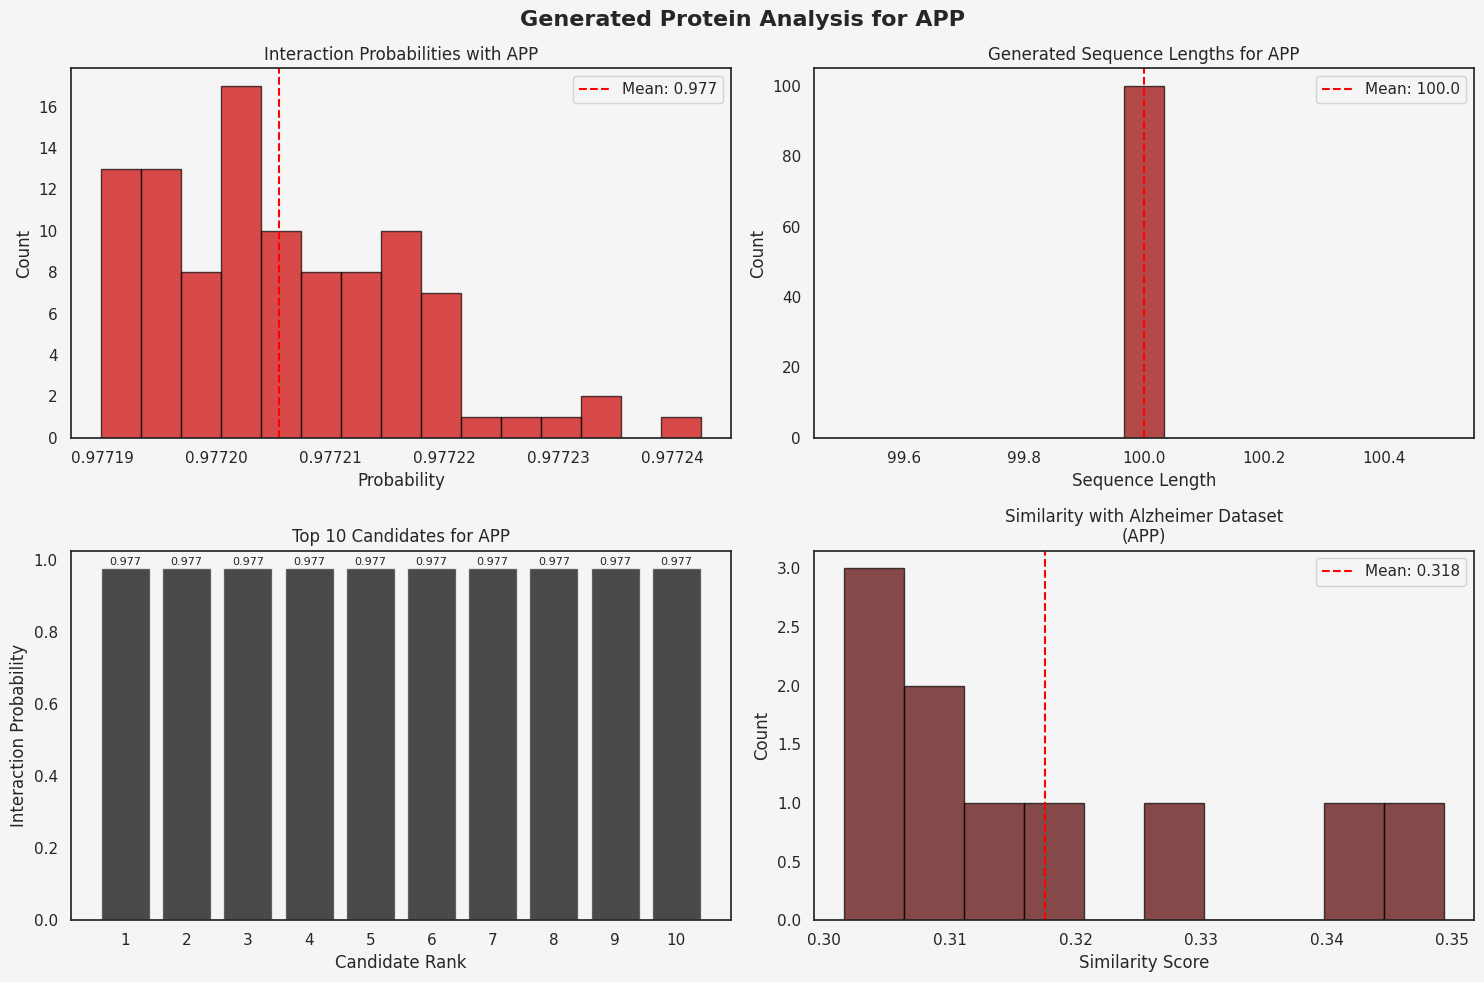

Analysis plot saved as app_alzheimer_analysis.png

SUMMARY FOR APP
Total candidates found: 100
Average probability: 0.977
Average sequence length: 100.0
Similarity matches: 10

--------------------------------------------------
Analyzing TAU
--------------------------------------------------
Detected dimensions:
  Total input: 355
  Sequence features: 256
  Structural features: 99
Models loaded successfully!


,UniProt_A,UniProt_B,SequenceA,SequenceB
0,P37840-1,P37840-1,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...
1,P37840-1,P37840-1,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...
2,P37840-1,P37840-1,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...
3,P37840-1,P37840-1,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...
4,P37840-1,P37840-1,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...


Found 2050 interaction partners for P10636

GENERATING INTERACTING PROTEINS FOR TAU


Generating for TAU: 100%|██████████| 200/200 [00:10<00:00, 19.18it/s]



Results for TAU:
  Total generation attempts: 284
  Filtered (repetitive): 84
  Successfully tested: 200
  Candidates above threshold: 200
  Returning top: 100
  Repetition filter efficiency: 29.6% filtered

Top 10 candidates for TAU:
------------------------------------------------------------------------------------------
   1. Prob: 0.9772 | Len: 100 | MKRRARYYSGLLHLARRERHAKRGRRGLHEHREYYLEGSLSRRKSSGELV...
   2. Prob: 0.9772 | Len: 100 | MHEKAHRLLRGSYRGERLSSHKYYLYHSHYLYGLARRHRRKHAYKREEYP...
   3. Prob: 0.9772 | Len: 100 | MAAVELKLHEGHHEAGLLEKRPHYEHHRYELEGGEERAAGRKYESHAKSR...
   4. Prob: 0.9772 | Len: 100 | MKHREREEGRYLRHLSRVLAELEAEHEGAKRKRVRGGLGSAVLEKSGSHK...
   5. Prob: 0.9772 | Len: 100 | MAHLLKYGHHGRRSRSEHEKERAGYVGELVYVRAYARVEGRYRLGARKSS...
   6. Prob: 0.9772 | Len: 100 | MESSLLRAYKHRLEHYYREGRYKRRKKGGHLLHLELGHAHLKRLLAGLSE...
   7. Prob: 0.9772 | Len: 100 | MSLAKHVERRYLGEAARGSYERAKSRYAERRVSYRLSLLYRRYKKGRRSH...
   8. Prob: 0.9772 | Len: 100 | MHYKLGHRELARRAARSERSRGYHYRKEARYSGEERRLL

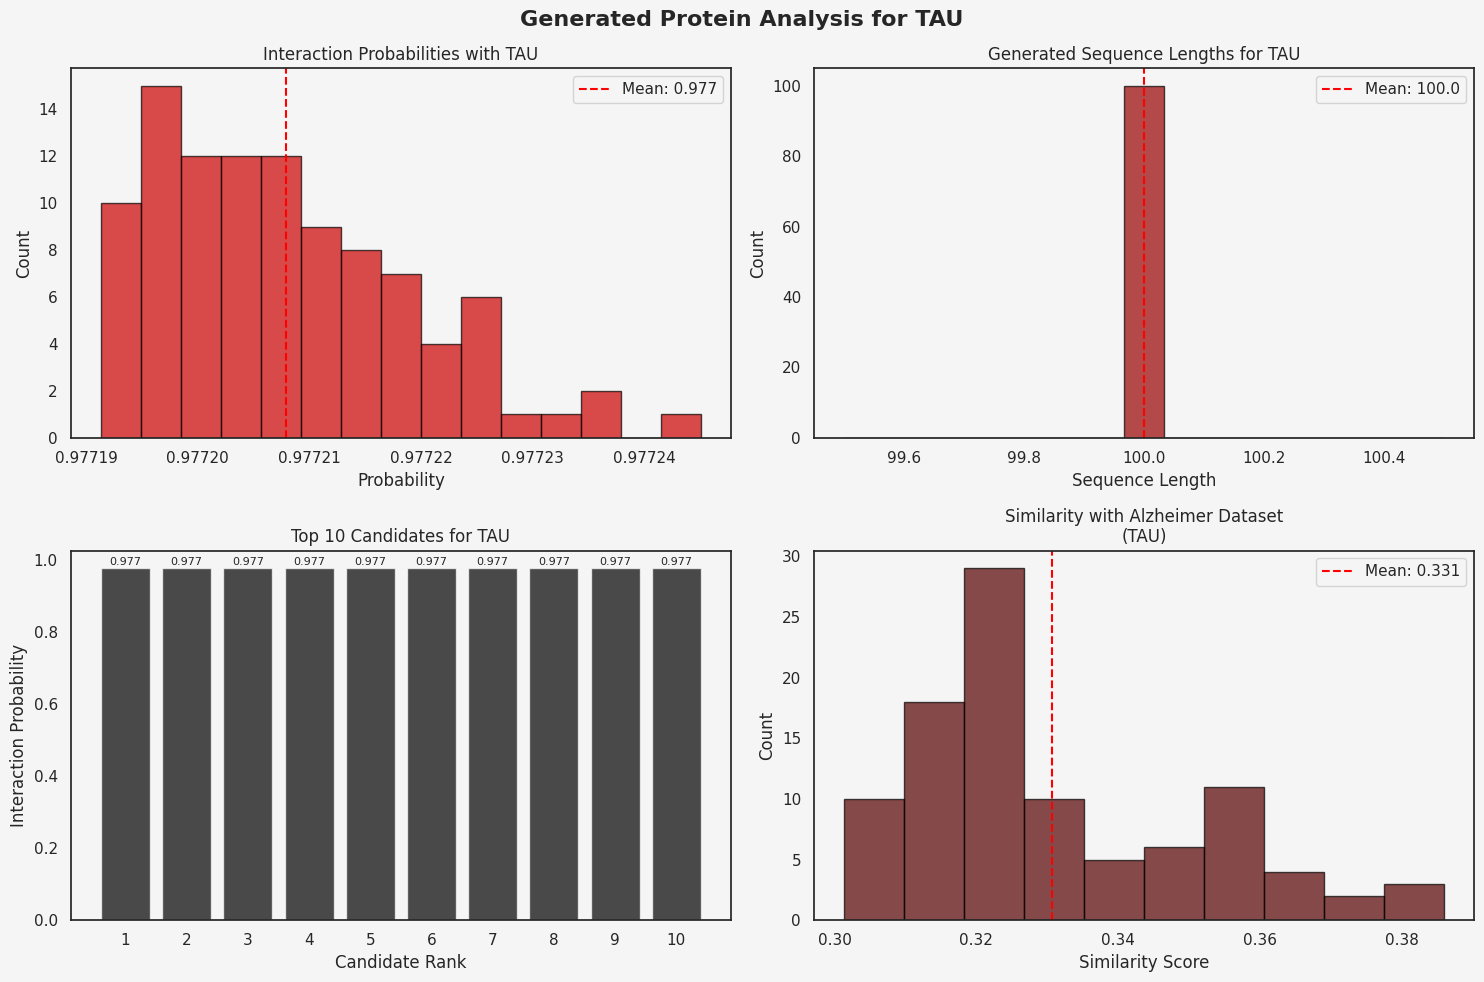

Analysis plot saved as tau_alzheimer_analysis.png

SUMMARY FOR TAU
Total candidates found: 100
Average probability: 0.977
Average sequence length: 100.0
Similarity matches: 98

--------------------------------------------------
Analyzing PSEN1
--------------------------------------------------
Detected dimensions:
  Total input: 355
  Sequence features: 256
  Structural features: 99
Models loaded successfully!


,UniProt_A,UniProt_B,SequenceA,SequenceB
0,P37840-1,P37840-1,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...
1,P37840-1,P37840-1,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...
2,P37840-1,P37840-1,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...
3,P37840-1,P37840-1,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...
4,P37840-1,P37840-1,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...


Found 201 interaction partners for P49768

GENERATING INTERACTING PROTEINS FOR PSEN1


Generating for PSEN1: 100%|██████████| 200/200 [00:10<00:00, 19.04it/s]



Results for PSEN1:
  Total generation attempts: 275
  Filtered (repetitive): 75
  Successfully tested: 200
  Candidates above threshold: 200
  Returning top: 100
  Repetition filter efficiency: 27.3% filtered

Top 10 candidates for PSEN1:
------------------------------------------------------------------------------------------
   1. Prob: 0.9772 | Len: 100 | MRARYRHERSVLEYERLSLELAVRGGKRYSHHEHSLAYHSHYGESGERSE...
   2. Prob: 0.9772 | Len: 100 | MKESRGRYRRHARRYYRSLLHEYSRLHGREEVLHYELGKAVERRKGSYRL...
   3. Prob: 0.9772 | Len: 100 | MGSHLARHHGRLSGRYPESKLGELKARYRSARSALHHLRLGAHRGRHSGK...
   4. Prob: 0.9772 | Len: 100 | MASRLERSAEALSVVAESRLHYESLHYYSESLKRLSGAHAEAKHRYSRHH...
   5. Prob: 0.9772 | Len: 100 | MRKLRLGLLVLSVLRRLHGEAVALYSERGYEAALYLHRGYLRKHHKSAVG...
   6. Prob: 0.9772 | Len: 100 | MKHLLREHLSRAAEGAELRRSSRGGASKAKEESYYARYRKEREHRAVRLK...
   7. Prob: 0.9772 | Len: 100 | MRRKGLYRVSRLKRRHRAYRGYSREHEEREYSYYGAGRVRVRLRAAEALL...
   8. Prob: 0.9772 | Len: 100 | MGHRALARSHELYARGRRYRKEGAHLKSSRGVEHE

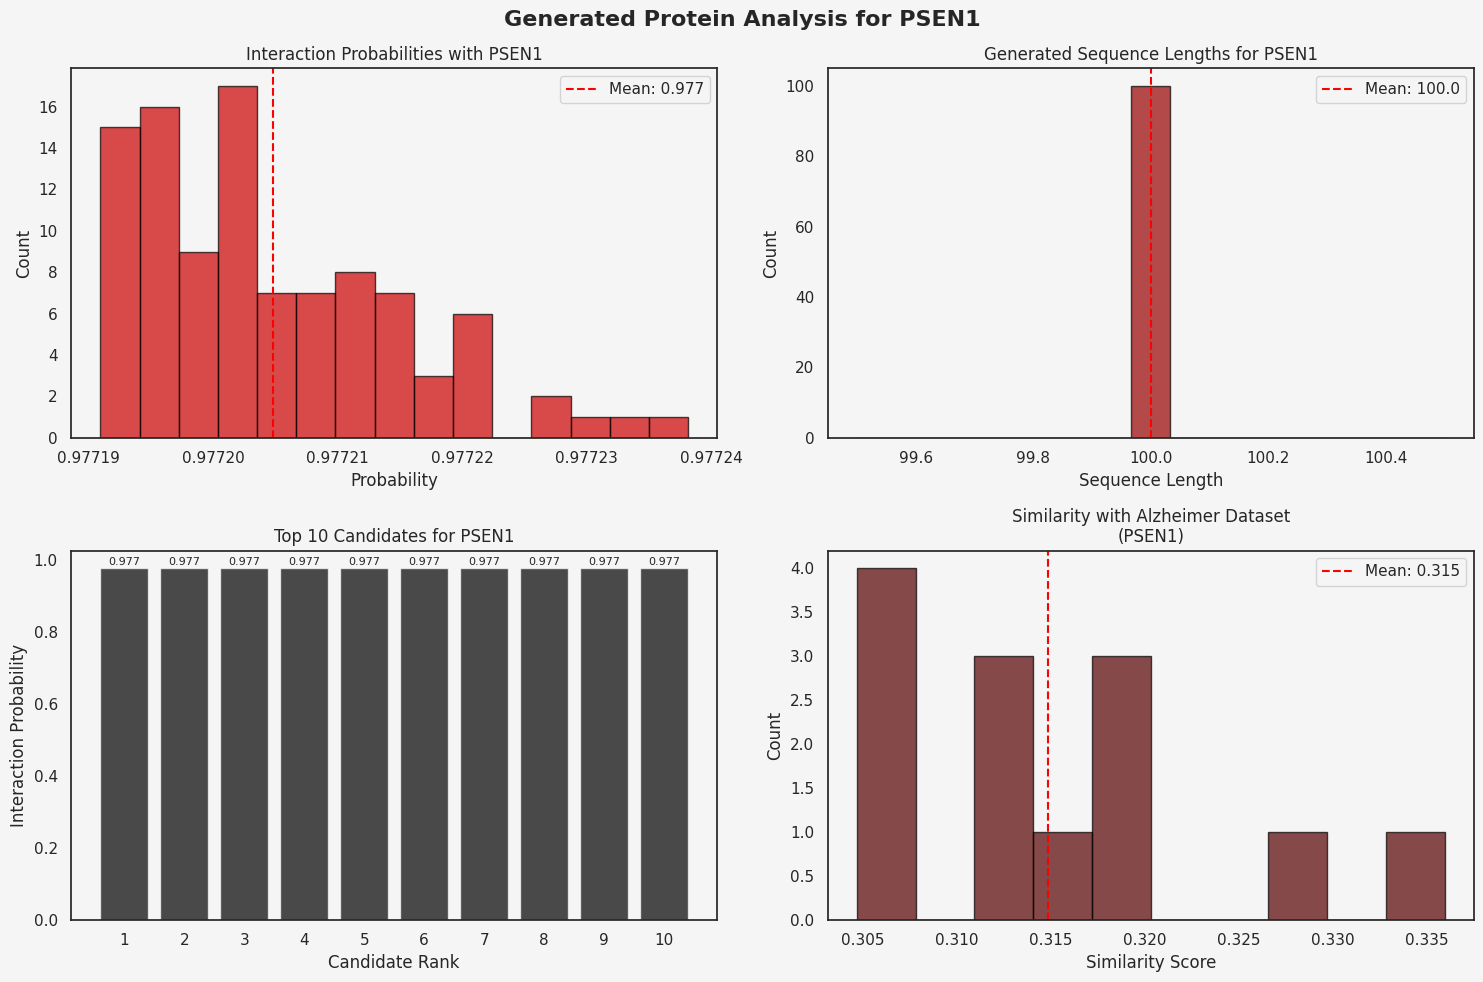

Analysis plot saved as psen1_alzheimer_analysis.png

SUMMARY FOR PSEN1
Total candidates found: 100
Average probability: 0.977
Average sequence length: 100.0
Similarity matches: 13

--------------------------------------------------
Analyzing MAPT
--------------------------------------------------
Detected dimensions:
  Total input: 355
  Sequence features: 256
  Structural features: 99
Models loaded successfully!


,UniProt_A,UniProt_B,SequenceA,SequenceB
0,P37840-1,P37840-1,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...
1,P37840-1,P37840-1,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...
2,P37840-1,P37840-1,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...
3,P37840-1,P37840-1,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...
4,P37840-1,P37840-1,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...


Found 1992 interaction partners for P10636-8

GENERATING INTERACTING PROTEINS FOR MAPT


Generating for MAPT: 100%|██████████| 200/200 [00:10<00:00, 18.90it/s]



Results for MAPT:
  Total generation attempts: 286
  Filtered (repetitive): 86
  Successfully tested: 200
  Candidates above threshold: 200
  Returning top: 100
  Repetition filter efficiency: 30.1% filtered

Top 10 candidates for MAPT:
------------------------------------------------------------------------------------------
   1. Prob: 0.9773 | Len: 100 | MSASELYSRGSEHSAREVERSGKYKLSEVSKLRRVHKRKGLEAGRKRHLL...
   2. Prob: 0.9772 | Len: 100 | MLKYAHKSEESRRLLHRHLLRLGLKLELYALRLAESRHHGGARLAEERSL...
   3. Prob: 0.9772 | Len: 100 | MRRSRRLLEAGYSREALESHEHPLHEYKLLRSLGRRGSKGEHAYSYEAKL...
   4. Prob: 0.9772 | Len: 100 | MRVRKLGGEREVSRSRSGRRVLGSEARRYKGGYRSRLSRLSGLLYRAEGK...
   5. Prob: 0.9772 | Len: 100 | MLLSLRESLRHRKRRSRGVYGSSYRSAKAAYRRLKAYLRGSYRHRELLSG...
   6. Prob: 0.9772 | Len: 100 | MRPRYHGLRRLRLLERSRSLRLGHLRGRLLELVEARYLGESEERSLAAGS...
   7. Prob: 0.9772 | Len: 100 | MRVRLVRGHPYREYYHEKRELHLRSRHYYVYHSAGHRKGGLYEGGYLRGY...
   8. Prob: 0.9772 | Len: 100 | MRLYYAGRAKSRYLEEGLLRHAKVRAYEGYSSRSYRA

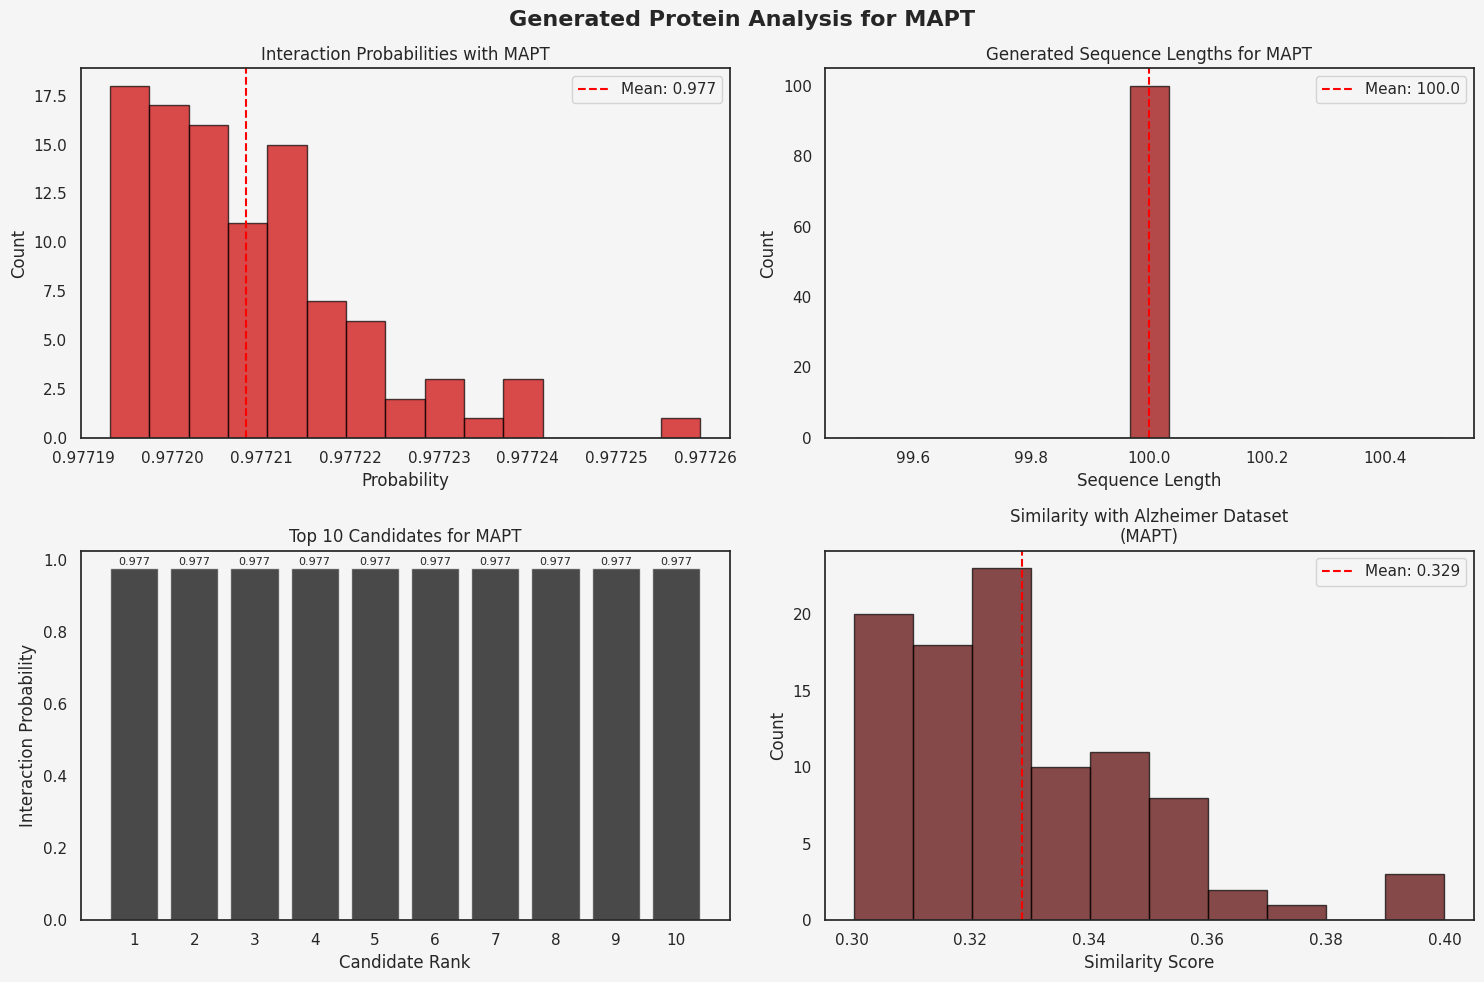

Analysis plot saved as mapt_alzheimer_analysis.png

SUMMARY FOR MAPT
Total candidates found: 100
Average probability: 0.977
Average sequence length: 100.0
Similarity matches: 96

COMPARATIVE SUMMARY
Protein  Candidates Avg Prob   Avg Length  Similarities
------------------------------------------------------------
APP      100        0.977      100.0       10          
TAU      100        0.977      100.0       98          
PSEN1    100        0.977      100.0       13          
MAPT     100        0.977      100.0       96          


{'APP': {'target': 'APP',
  'target_sequence': 'MLPGLALLLLAAWTARALEVPTDGNAGLLAEPQIAMFCGRLNMHMNVQNGKWDSDPSGTKTCIDTKEGILQYCQEVYPELQITNVVEANQPVTIQNWCKRGRKQCKTHPHFVIPYRCLVGEFVSDALLVPDKCKFLHQERMDVCETHLHWHTVAKETCSEKSTNLHDYGMLLPCGIDKFRGVEFVCCPLAEESDNVDSADAEEDDSDVWWGGADTDYADGSEDKVVEVAEEEEVAEVEEEEADDDEDDEDGDEVEEEAEEPYEEATERTTSIATTTTTTTESVEEVVREVCSEQAETGPCRAMISRWYFDVTEGKCAPFFYGGCGGNRNNFDTEEYCMAVCGSAMSQSLLKTTQEPLARDPVKLPTTAASTPDAVDKYLETPGDENEHAHFQKAKERLEAKHRERMSQVMREWEEAERQAKNLPKADKKAVIQHFQEKVESLEQEAANERQQLVETHMARVEAMLNDRRRLALENYITALQAVPPRPRHVFNMLKKYVRAEQKDRQHTLKHFEHVRMVDPKKAAQIRSQVMTHLRVIYERMNQSLSLLYNVPAVAEEIQDEVDELLKKEQNYSDDVLANMISEPRISYGNDALMPSLTETKTTVELLPVNGEFSLDDLQPWHSFGADSVPANTENEVEPVDARPAADRGLTTRPGSGLTNIKTEEISEVKMDAEFRHDSGYEVHHQKLVFFAEDVGSNKGAIIGLMVGGVVIATVIVITLVMLKKKQYTSIHHGVVEVDAAVTPEERHLSKMQQNGYENPTYKFFEQMQN',
  'candidates': [{'target_protein': 'APP',
    'generated_sequence': 'MGAREVPSESRSRRKLGRHSSHKRHHRRYGHYLSKRAHLRRGHRSGELRRAGRRVLLRGLHGGEGLHVVAVLERERHARSGSEAGYRRARPVSERKGEGH',
    'i

In [41]:
analyze_all_alzheimer_proteins(num_candidates=200, top_k=100, min_prob=0.92)

Model loaded successfully from /content/drive/MyDrive/autoencoder_pu_complete.pth
Detected dimensions from loaded model:
  Total input: 355
  Sequence features: 256
  Structural features: 99
Model states loaded into initialized models.
Created 99 structural feature names.

Evaluation on Alzheimer Dataset

EVALUATING ALZHEIMER PROTEIN-PROTEIN INTERACTIONS


,UniProt_A,UniProt_B,SequenceA,SequenceB
0,P37840-1,P37840-1,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...
1,P37840-1,P37840-1,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...
2,P37840-1,P37840-1,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...
3,P37840-1,P37840-1,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...
4,P37840-1,P37840-1,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...


Loaded dataset with 10310 protein pairs
Processing 10310 pairs in batches of 32...


Processing batches: 100%|██████████| 323/323 [00:27<00:00, 11.79it/s]


Processing complete. Errors encountered: 0

DETAILED ANALYSIS RESULTS
Total pairs evaluated: 10310
Predicted interactions (YES): 10291 (99.8%)
Predicted non-interactions (NO): 19 (0.2%)
High confidence predictions: 9997 (97.0%)
Low confidence predictions: 313 (3.0%)

Probability Statistics:
  Mean: 0.9286
  Std:  0.0571
  Range: [0.1140, 0.9961]

TOP 10 PREDICTED INTERACTIONS
------------------------------------------------------------
 1. P23297-P04271                  | Prob: 0.9961 | Conf: high | Lengths:  94,  92
 2. Q8TB24-P35527                  | Prob: 0.9930 | Conf: high | Lengths: 985, 623
 3. Q8TB24-P02533                  | Prob: 0.9923 | Conf: high | Lengths: 985, 472
 4. Q9Y2W7-Q61144                  | Prob: 0.9911 | Conf: high | Lengths: 256, 448
 5. Q8TB24-P62829                  | Prob: 0.9909 | Conf: high | Lengths: 985, 140
 6. Q8TB24-P13645                  | Prob: 0.9909 | Conf: high | Lengths: 985, 584
 7. P21926-Q8IWA5                  | Prob: 0.9900 | Conf: high

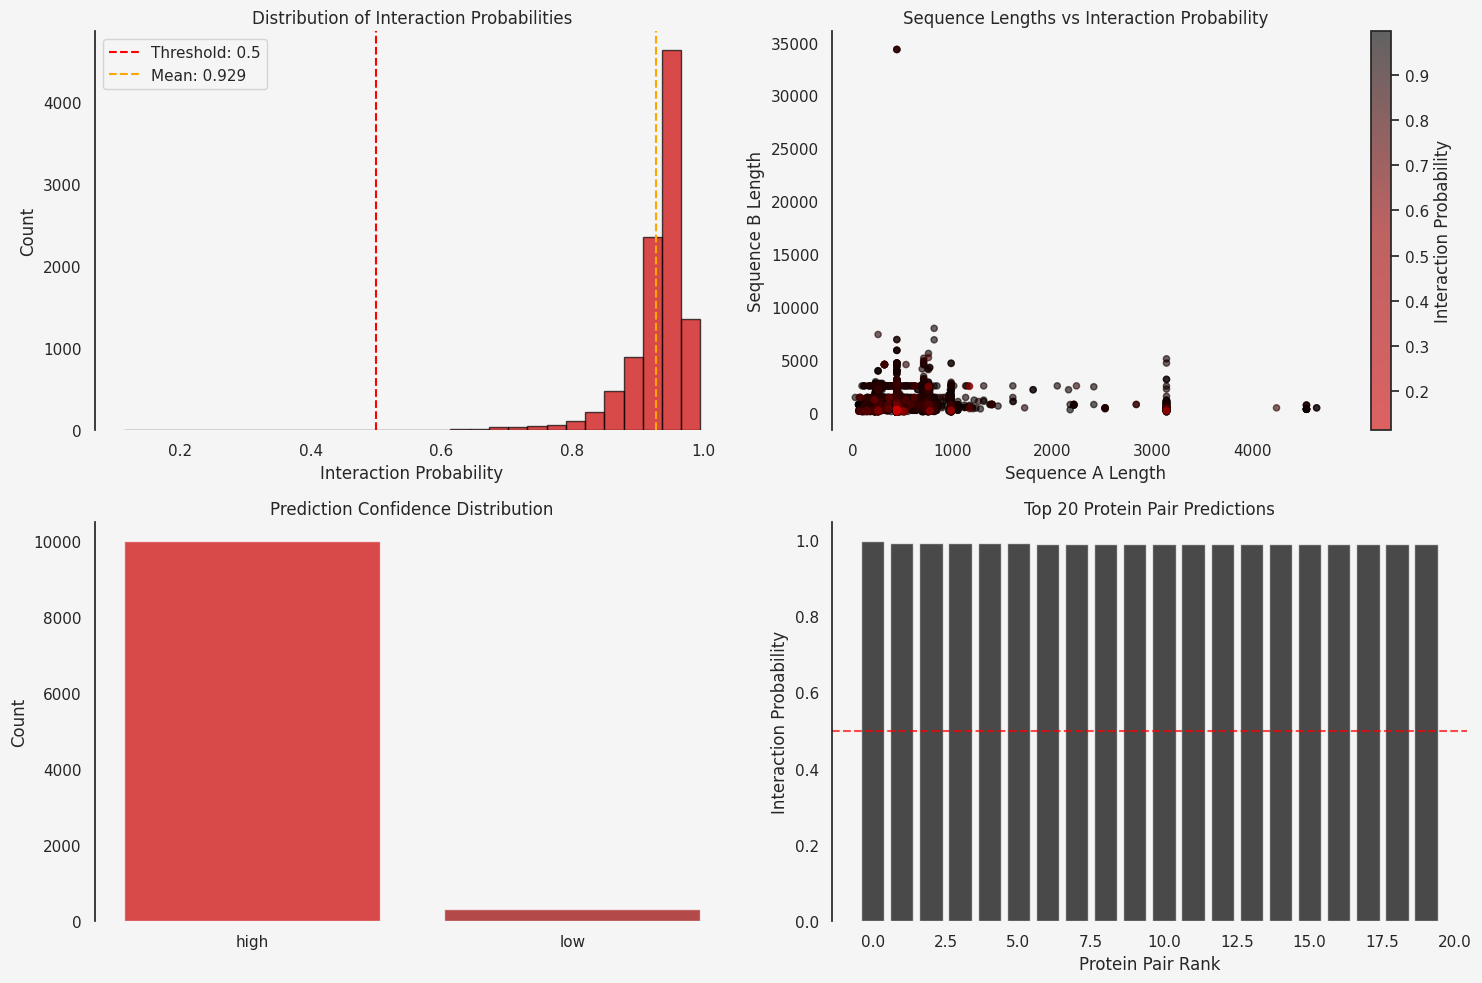

Visualization saved to: /content/drive/MyDrive/alzheimer_evaluation_analysis.png

Alzheimer evaluation complete.
Total pairs evaluated: 5


In [ ]:
import torch
import os

# Define the path to the saved model
model_path = os.path.join(get_output_dir(), 'autoencoder_pu_complete.pth')

# Load the saved model checkpoint
try:
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    print(f"Model loaded successfully from {model_path}")
except FileNotFoundError:
    print(f"Error: Model file not found at {model_path}")
    print("Please ensure 'autoencoder_pu_complete.pth' exists in Google Drive 'outputs' folder.")
    checkpoint = None

if checkpoint is not None:
    # Re-initialize the models with the correct dimensions
    LATENT_DIM = 64

    # Inspect the PPI model structure from the loaded state dict to get actual dimensions
    ppi_state = checkpoint['ppi_model']
    first_layer_weight = ppi_state['network.0.weight']
    total_input_dim = first_layer_weight.shape[1]

    sequence_feature_dim = LATENT_DIM * 4
    structural_feature_dim = total_input_dim - sequence_feature_dim

    print(f"Detected dimensions from loaded model:")
    print(f"  Total input: {total_input_dim}")
    print(f"  Sequence features: {sequence_feature_dim}")
    print(f"  Structural features: {structural_feature_dim}")

    encoder = DirectSequenceEncoder(
        latent_dim=LATENT_DIM,
        hidden_dim=256,
        num_layers=2,
        dropout=0.2
    ).to(device)

    ppi_model = PULearningPPIModel(
        sequence_feature_dim=sequence_feature_dim,
        structural_feature_dim=structural_feature_dim,
        hidden_dims=[256]
    ).to(device)

    # Load the state dictionaries
    try:
        encoder.load_state_dict(checkpoint['encoder'])
        ppi_model.load_state_dict(checkpoint['ppi_model'])
        print("Model states loaded into initialized models.")
    except Exception as e:
        print(f"Error loading model state dictionaries: {e}")
        encoder = None
        ppi_model = None

    if encoder is not None and ppi_model is not None:
        # Create structural feature names based on model dimensions
        structural_feature_names = [f'struct_feat_{i}' for i in range(structural_feature_dim)]
        print(f"Created {len(structural_feature_names)} structural feature names.")

        # Evaluate on Alzheimer's proteins using direct DataFrame processing
        print("\n" + "="*60)
        print("Evaluation on Alzheimer Dataset")
        print("="*60)

        alzheimer_results = evaluate_alzheimer_proteins(ppi_model, encoder, structural_feature_names, threshold=0.5)

        if alzheimer_results:
            print("\nAlzheimer evaluation complete.")
            print(f"Total pairs evaluated: {len(alzheimer_results)}")
        else:
            print("Alzheimer evaluation failed - no results returned.")

    else:
        print("Skipping evaluation due to model loading errors.")

Confusion matrix plot saved to: /content/drive/MyDrive/train_test_confusion_matrices.png


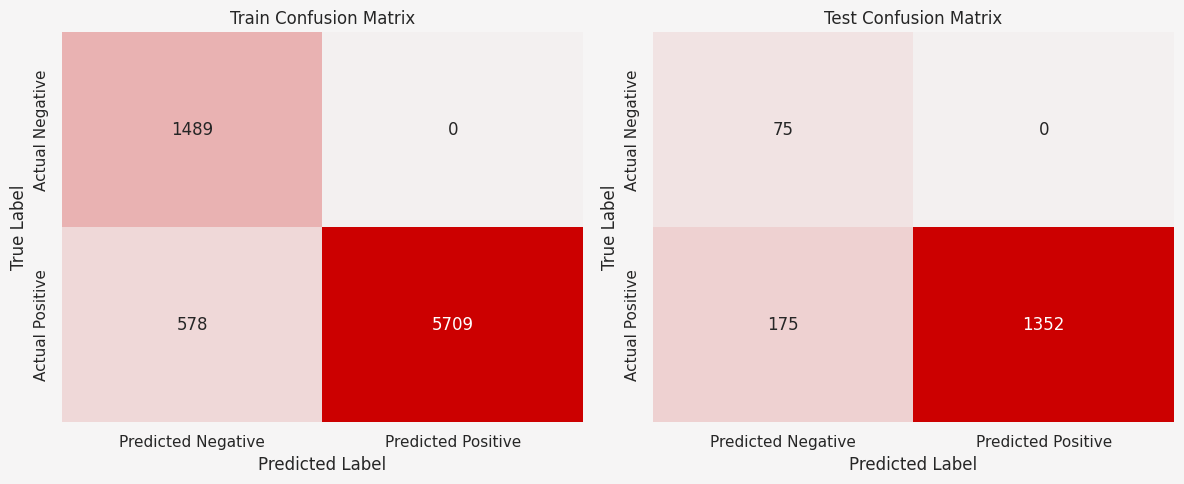

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Provided confusion matrix data
cm_data_test = np.array([[  75,    0],
                         [ 175, 1352]])

cm_data_train = np.array([[1489,    0],
                          [ 578, 5709]])


# Use the global COLOR_PALETTE for the colormap
custom_cmap = sns.light_palette(COLOR_PALETTE[0], as_cmap=True)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5)) # 1 row, 2 columns

# Plot the Train Confusion Matrix on the left subplot
sns.heatmap(cm_data_train, annot=True, fmt='d', cmap=custom_cmap, cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'],
            ax=axes[0]) # Specify the subplot axis

axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')
axes[0].set_title('Train Confusion Matrix')

# Plot the Test Confusion Matrix on the right subplot
sns.heatmap(cm_data_test, annot=True, fmt='d', cmap=custom_cmap, cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'],
            ax=axes[1]) # Specify the subplot axis

axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')
axes[1].set_title('Test Confusion Matrix')


plt.tight_layout()

# Save the figure using the helper function
save_path = save_fig('train_test_confusion_matrices.png')
print(f"Confusion matrix plot saved to: {save_path}")

plt.show()